# Compare 202405-2xrez to 202405 Bathymetry

Detailed, tile by tile, comparison of 202405-2xrez and 202405 bathymetries including preliminary river files.
This notebook is used iteratively with the `Process202405-2xrezBathymetry.ipynb` notebook to identify features
in the 2xrez bathymetry that need to be adjusted in the latter notebook.

This notebook is based on the ones that Susan created to do the same thing during the creation of the 202108
bathymetry (which was known as 202103d at the time):
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_andrivers.ipynb`
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_middle.ipynb`
* `analysis-susan/notebooks/bathymetry/lookat201702_201803d_upper.ipynb`

The conda environment file for this notebook is `environment-2xrez.yaml`.

In [11]:
from pathlib import Path
import sys

import cmocean.cm as cm
import matplotlib.pyplot as plt
import numpy
import xarray

from salishsea_tools import viz_tools

import matplotlib.colors as matcolors
import matplotlib.cm as cmx

Python and library versions:

In [12]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import netCDF4
import numpy
import pandas
import scipy
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'


## Load Bathymetry Datasets

In [13]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")
repos_prefix = repos_prefix if repos_prefix.exists() else Path("/data/dlatorne/MEOPAR/")

In [14]:
bathy_paths = {
    "final_202405": repos_prefix / "grid" / "bathymetry_202405.nc",
    "dbl_202405_base": repos_prefix / "grid" / "bathymetry_double_202405_base.nc",
    "dbl_202405": repos_prefix / "grid" / "bathymetry_double_202405.nc",
}

In [15]:
with xarray.open_dataset(bathy_paths["final_202405"], engine="h5netcdf") as bathy_ds:
    bathy = bathy_ds.Bathymetry
    lons = bathy_ds.nav_lon
    lats = bathy_ds.nav_lat

with xarray.open_dataset(bathy_paths["dbl_202405_base"], engine="h5netcdf") as dbl_bathy_base_ds:
    dbl_bathy_base_unmasked = dbl_bathy_base_ds.Bathymetry
    dbl_bathy_base = dbl_bathy_base_unmasked.where(dbl_bathy_base_unmasked != 0, numpy.nan)
    lons_dbl = dbl_bathy_base_ds.nav_lon
    lats_dbl = dbl_bathy_base_ds.nav_lat

with xarray.open_dataset(bathy_paths["dbl_202405"], engine="h5netcdf") as dbl_bathy_ds:
    dbl_bathy = dbl_bathy_ds.Bathymetry

Calculate expanded `lons` and `lats` arrays by extrapolating values on south and east edges.
This provides arrays that `pcoulormesh()` interprets as cell edges so that it doesn't a
`UserWarning` about the non-montonic lon/lat values that arise due to the rotated grid.
This code is based on Michael's `expandf()` function in
https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathy_helpers.py

In [16]:
lons_e = numpy.zeros((lons.shape[0]+1, lons.shape[1]+1))
lons_e[1:, 1:] = lons
lons_e[0, 1:] = lons[0, :] - (lons[1, :] - lons[0, :])
lons_e[:, 0] = lons_e[:, 1] - (lons_e[:, 2] - lons_e[:, 1])

lats_e = numpy.zeros((lats.shape[0]+1, lats.shape[1]+1))
lats_e[1:, 1:] = lats
lats_e[0, 1:] = lats[0, :] - (lats[1, :] - lats[0, :])
lats_e[:, 0] = lats_e[:, 1] - (lats_e[:, 2] - lats_e[:, 1])

lons_dbl_e = numpy.zeros((lons_dbl.shape[0]+1, lons_dbl.shape[1]+1))
lons_dbl_e[1:, 1:] = lons_dbl
lons_dbl_e[0, 1:] = lons_dbl[0, :] - (lons_dbl[1, :] - lons_dbl[0, :])
lons_dbl_e[:, 0] = lons_dbl_e[:, 1] - (lons_dbl_e[:, 2] - lons_dbl_e[:, 1])

lats_dbl_e = numpy.zeros((lats_dbl.shape[0]+1, lats_dbl.shape[1]+1))
lats_dbl_e[1:, 1:] = lats_dbl
lats_dbl_e[0, 1:] = lats_dbl[0, :] - (lats_dbl[1, :] - lats_dbl[0, :])
lats_dbl_e[:, 0] = lats_dbl_e[:, 1] - (lats_dbl_e[:, 2] - lats_dbl_e[:, 1])


## Tile Plotting Function and x-index Array

In [17]:
def plot_tile(x_min_max, y_slices, bathy, dbl_bathy_base, dbl_bathy=None):
    x_slices = {
        "sgl": slice(*x_min_max),
        "dbl": slice(*x_min_max * 2),
    }
    if dbl_bathy is None:
        fig, axs = plt.subplots(2, 2, figsize=(24, 12))
        ((ax_sgl, ax_dbl_base), (ax_sgl_map, ax_dbl_base_map)) = axs
    else:
        fig, axs = plt.subplots(2, 3, figsize=(36, 18))
        ((ax_sgl, ax_dbl_base, ax_dbl), (ax_sgl_map, ax_dbl_base_map, ax_dbl_map)) = axs

    # use spectral colour map to provide lots of contrast between grid cells
    cmap = "nipy_spectral"

    # single resolution bathymetry
    # grid index coordinates
    bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]).plot(ax=ax_sgl, cmap=cmap, vmax=15)
    viz_tools.set_aspect(ax_sgl)
    ax_sgl.set_title("bathymetry_202405")
    # lon/lat coordinates
    tile_lons = lons_e[y_slices["sgl"], x_slices["sgl"]]
    tile_lats = lats_e[y_slices["sgl"], x_slices["sgl"]]
    ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
    viz_tools.set_aspect(ax_sgl_map, coords="map")

    # double resolution base bathymetry
    # grid index coordinates
    dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]).plot(ax=ax_dbl_base, cmap=cmap, vmax=15)
    viz_tools.set_aspect(ax_dbl_base)
    ax_dbl_base.set_title("bathymetry_double_202405_base")
    # lon/lat coordinates
    tile_lons = lons_dbl_e[y_slices["dbl"], x_slices["dbl"]]
    tile_lats = lats_dbl_e[y_slices["dbl"], x_slices["dbl"]]
    ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)
    viz_tools.set_aspect(ax_dbl_base_map, coords="map")
    ax_dbl_base_map.grid(True)

    if dbl_bathy is not None:
        # final double resolution bathymetry
        # useful to show the effect of adjustments made in the Process202405-2xrezBathymetnry.ipynb notebook as we iterate
        # grid index coordintes
        dbl_bathy.isel(y=y_slices["dbl"], x=x_slices["dbl"]).plot(ax=ax_dbl, cmap=cmap, vmax=15)
        viz_tools.set_aspect(ax_dbl)
        ax_dbl.set_title("bathymetry_double_202405")
        # lon/lat coordinates
        ax_dbl_map.pcolormesh(tile_lons, tile_lats, dbl_bathy.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)
        viz_tools.set_aspect(ax_dbl_map, coords="map")
    fig.tight_layout()


In [18]:
tile_x_min_max = [
    numpy.array([0, 35]),
    numpy.array([30, 65]),
    numpy.array([60, 95]),
    numpy.array([90, 125]),
    numpy.array([120, 155]),
    numpy.array([150, 185]),
    numpy.array([180, 215]),
    numpy.array([210, 245]),
    numpy.array([240, 275]),
    numpy.array([270, 305]),
    numpy.array([300, 335]),
    numpy.array([330, 365]),
    numpy.array([360, 398]),
]

## Row 0 - South end of Puget Sound

In [19]:
y_min_max = numpy.array([0, 30])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 0, 0

* all land

### Tile 0, 1

* all land

### Tile 0, 2

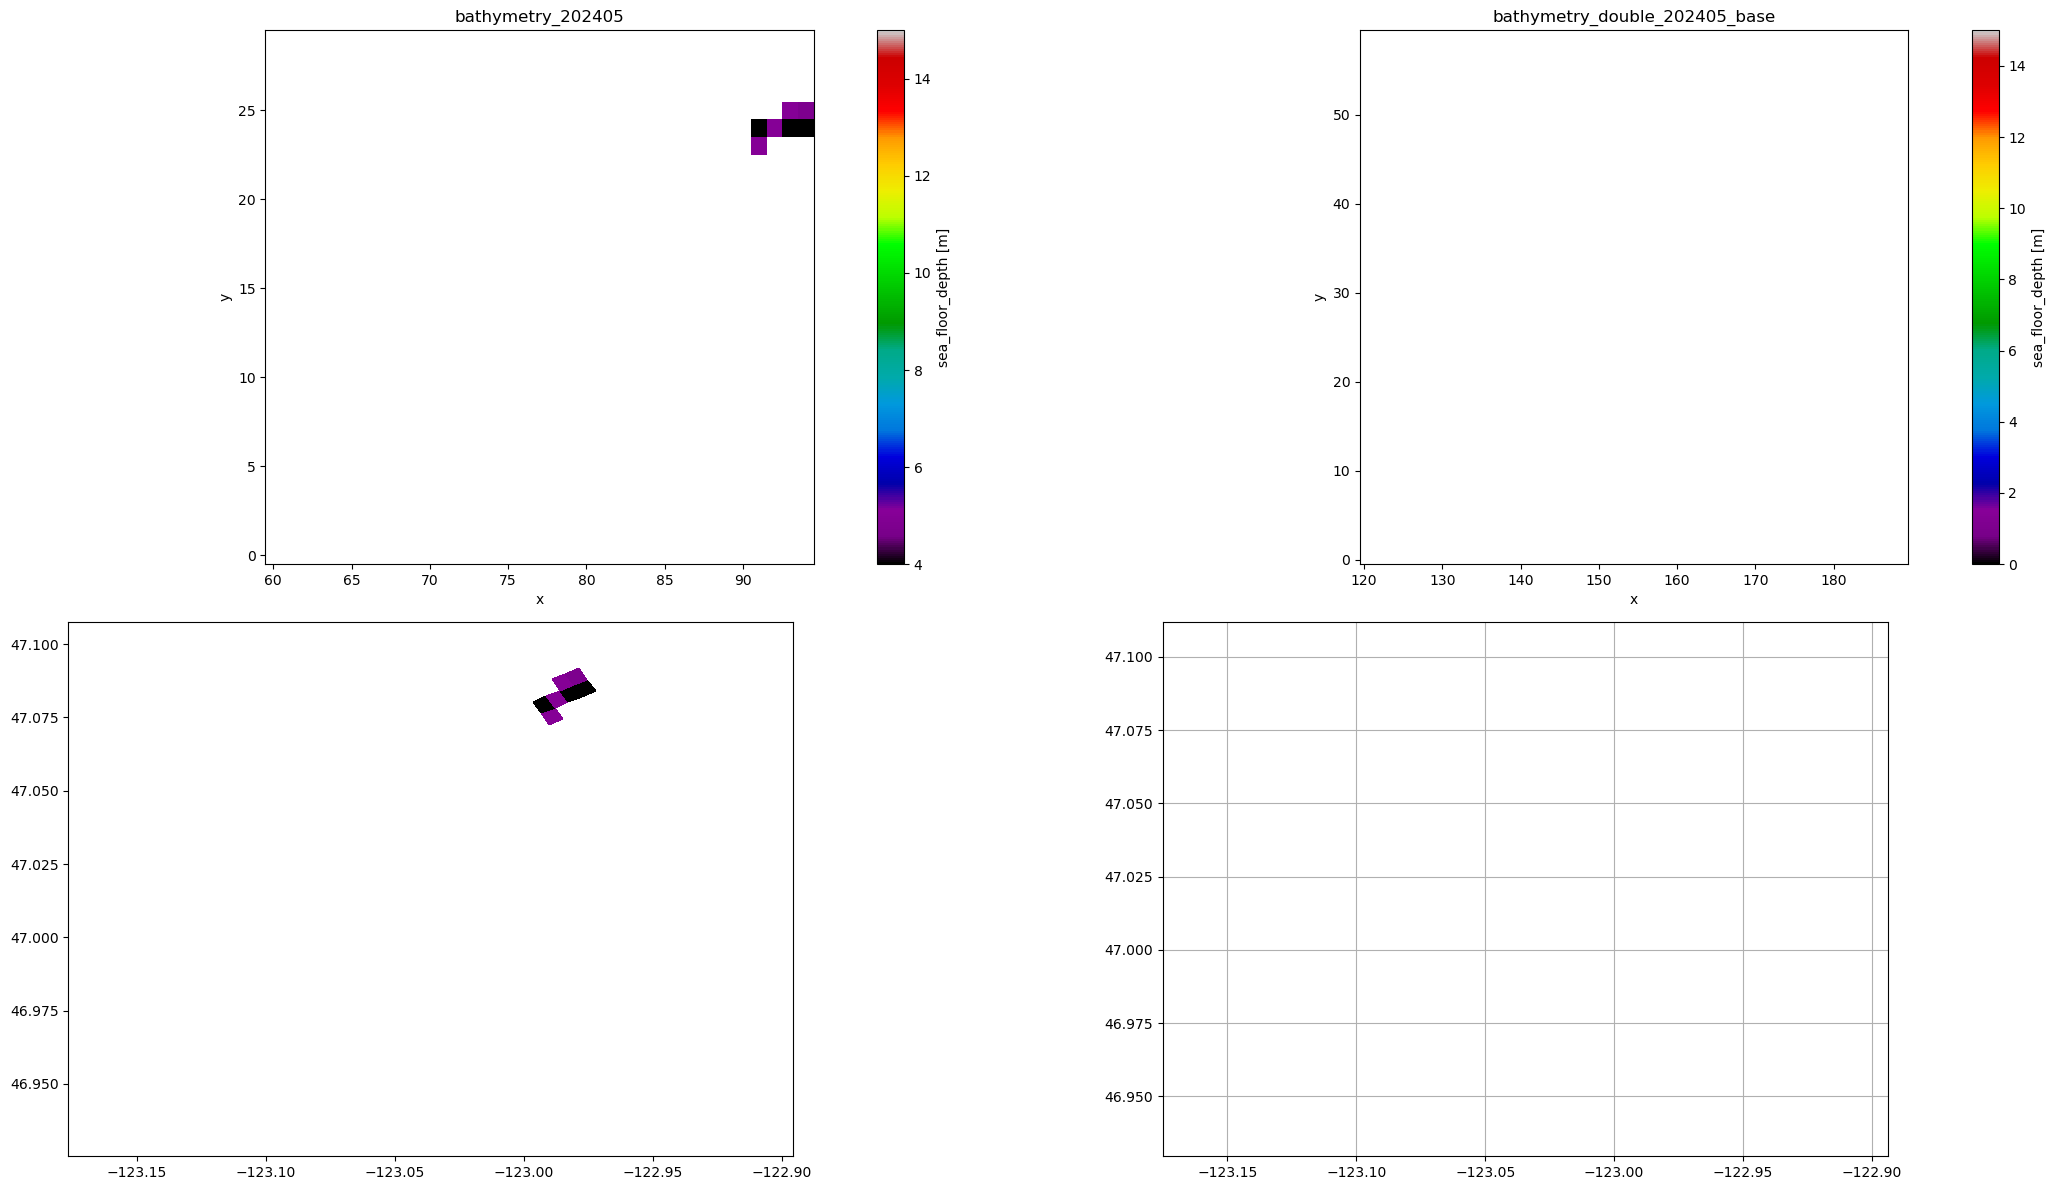

In [20]:
plot_tile(tile_x_min_max[2], y_slices, bathy, dbl_bathy_base)

### Tile 0, 3

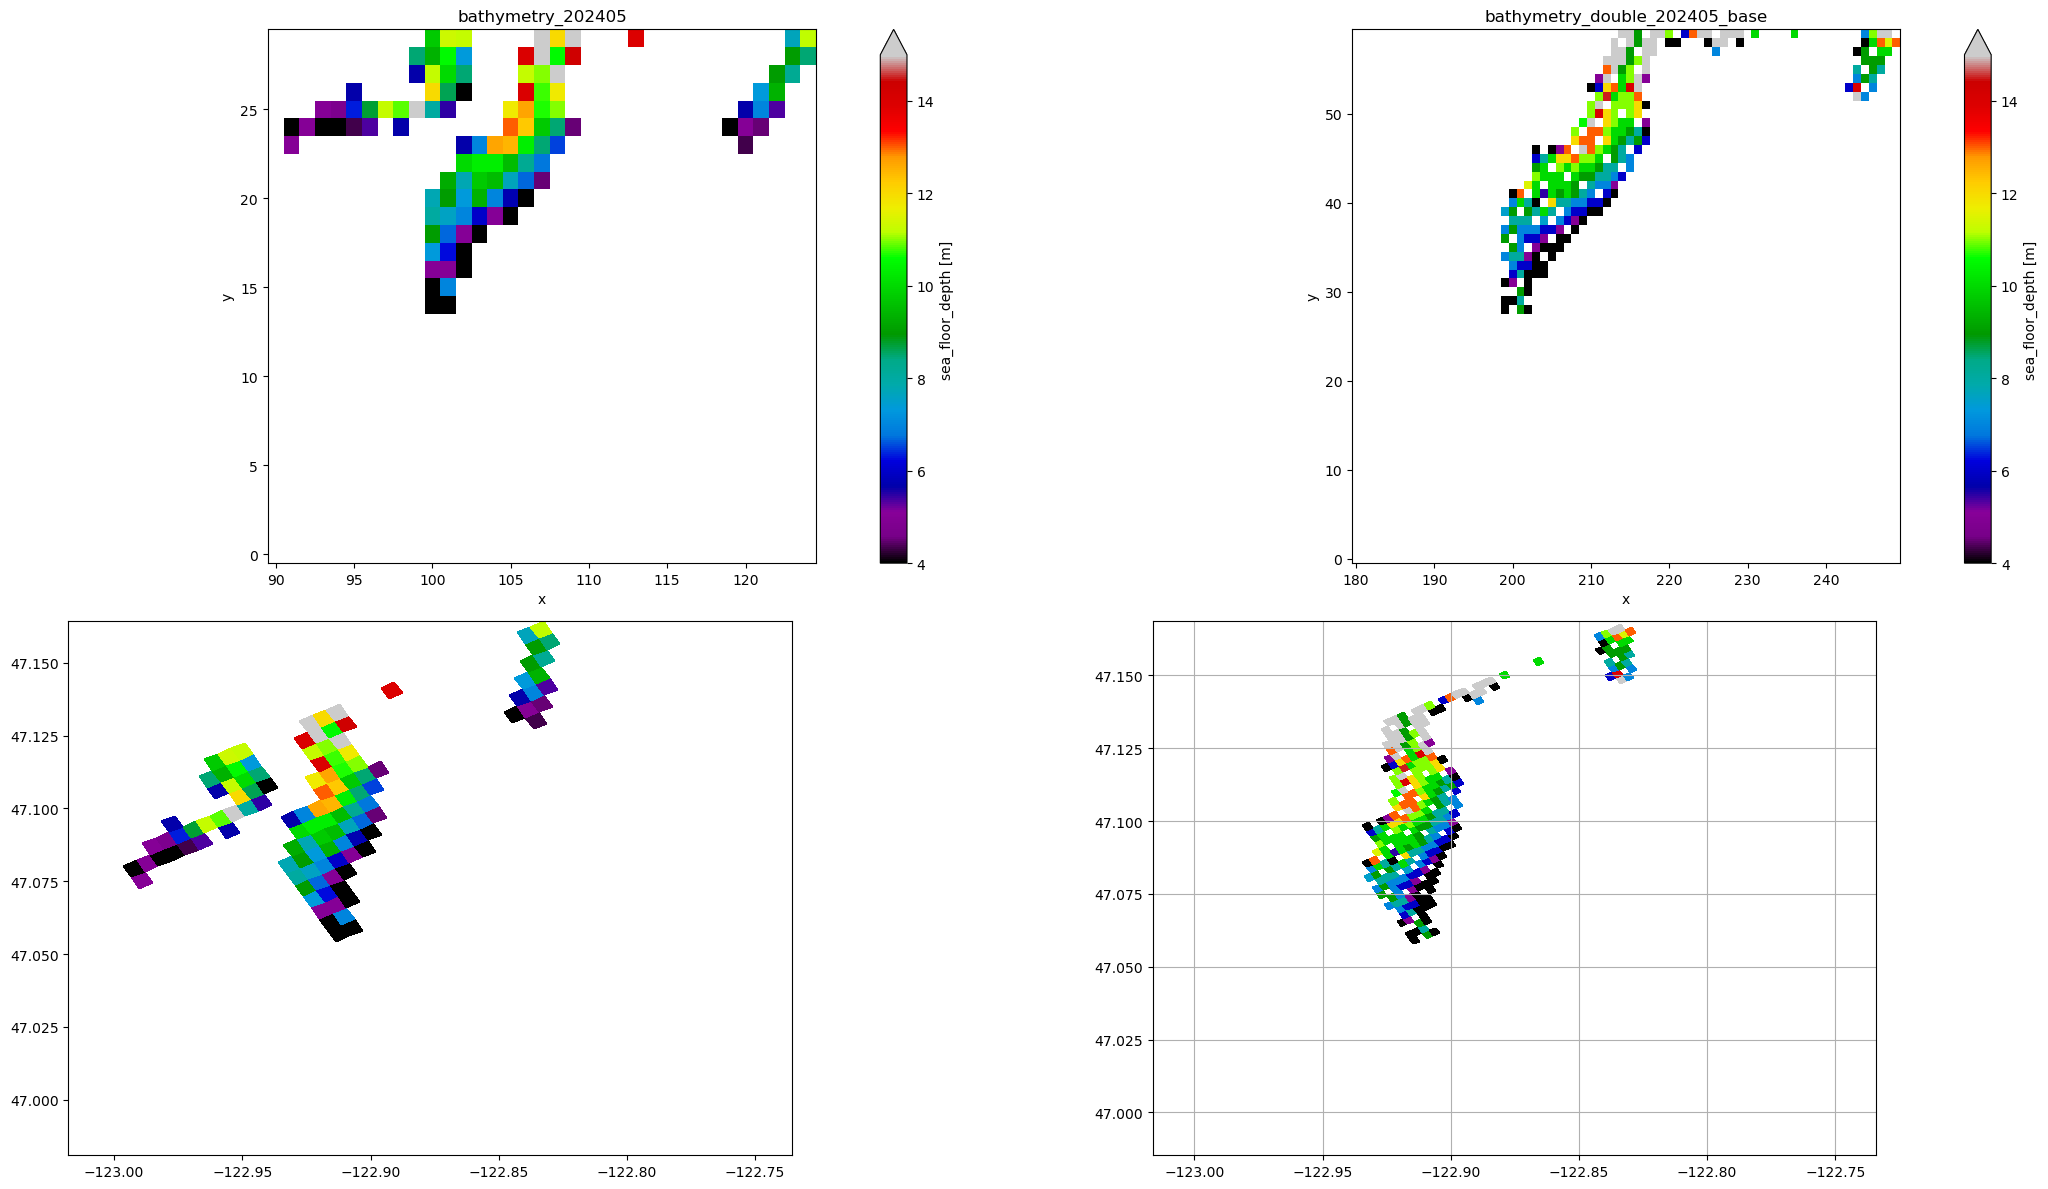

In [21]:
plot_tile(tile_x_min_max[3], y_slices, bathy, dbl_bathy_base)

Puget Sound has problems.
At the very least, the stippling has to be resolved.

So, let's skip farther north...

## Row 5 - Juan de Fuca Strait to Bellingham Bay

In [22]:
y_min_max = numpy.array([300, 330])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 5, 0

* all land


### Tile 5, 1

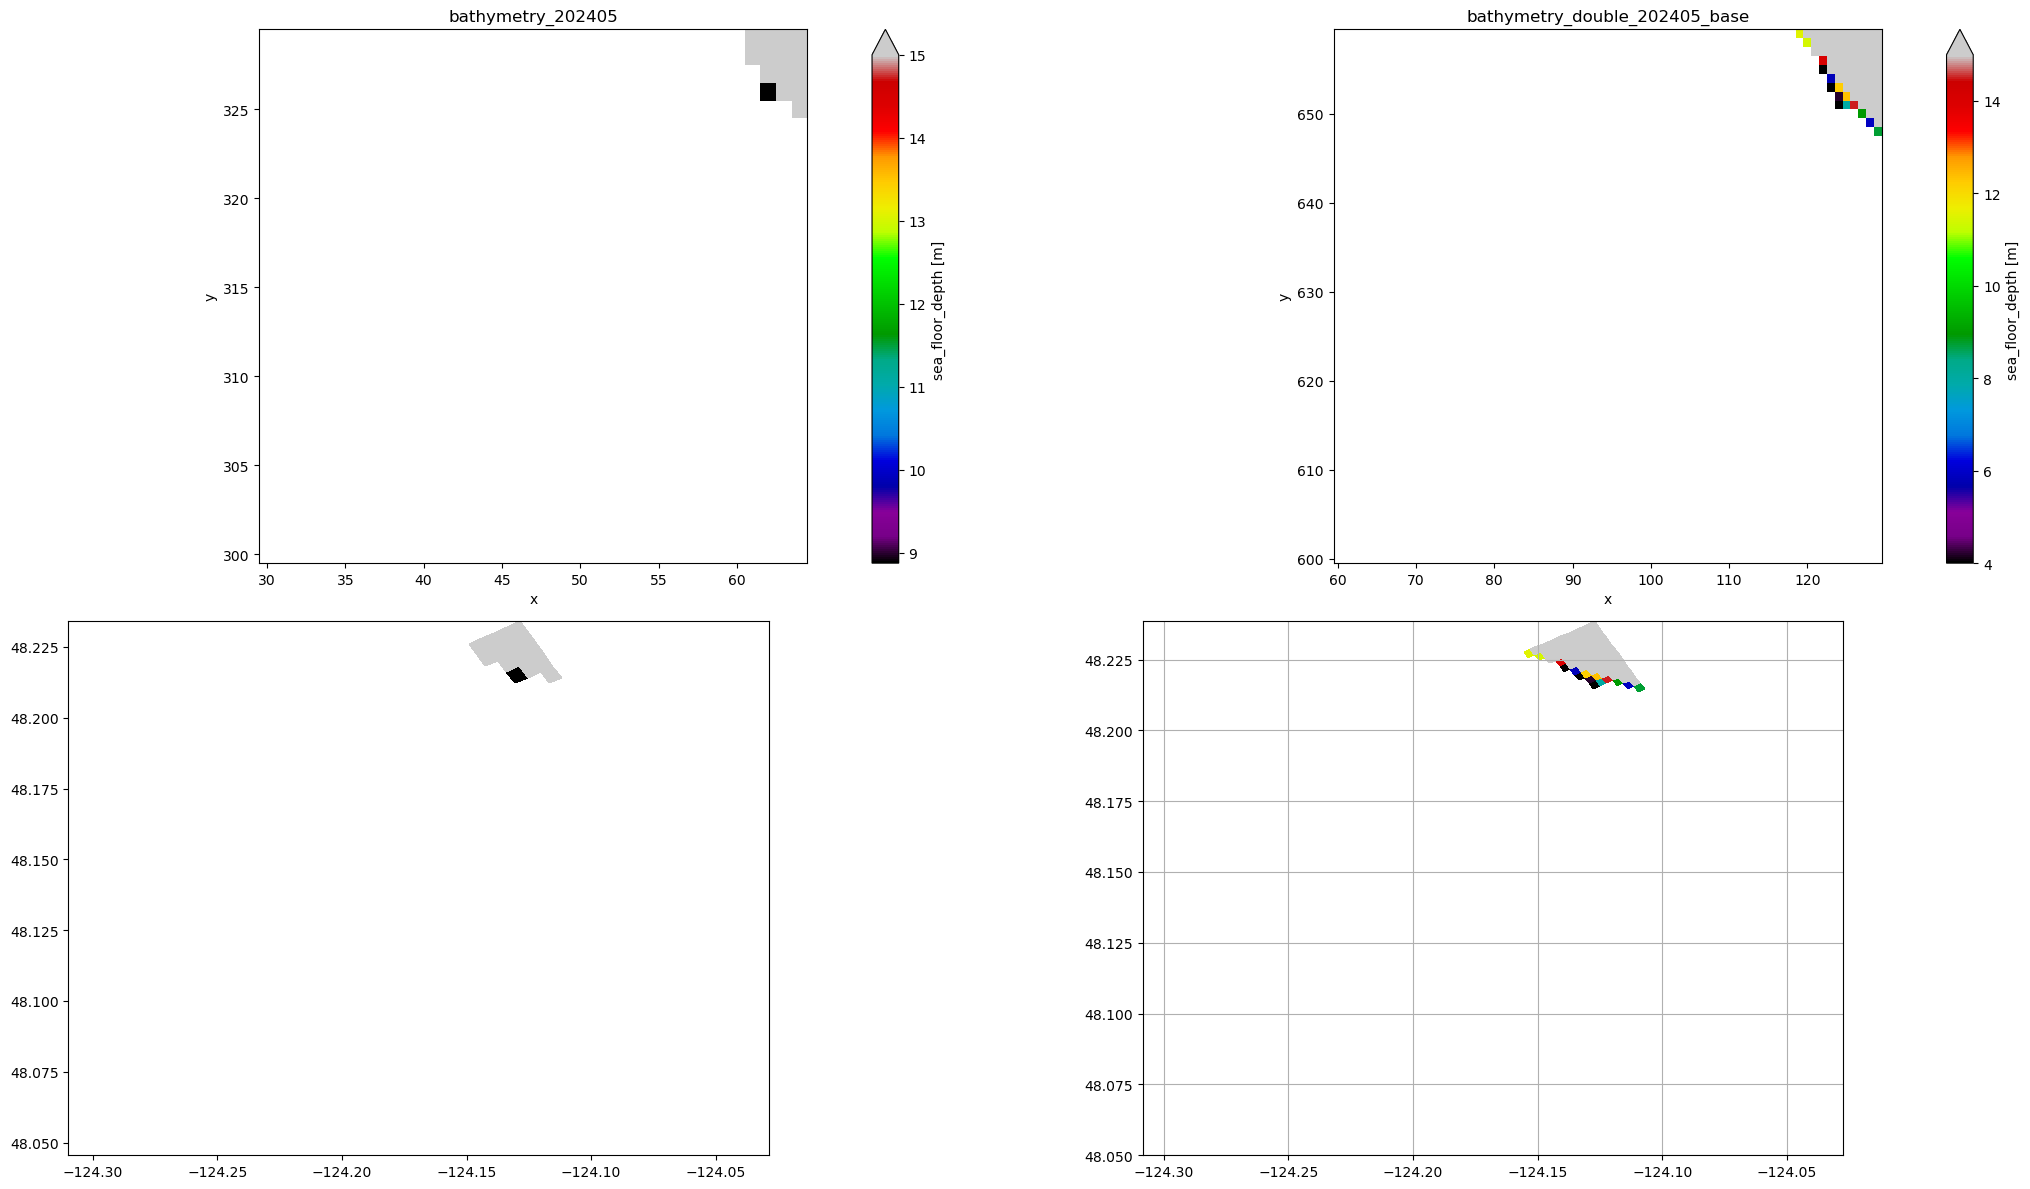

In [23]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 5, 2 - Pysht

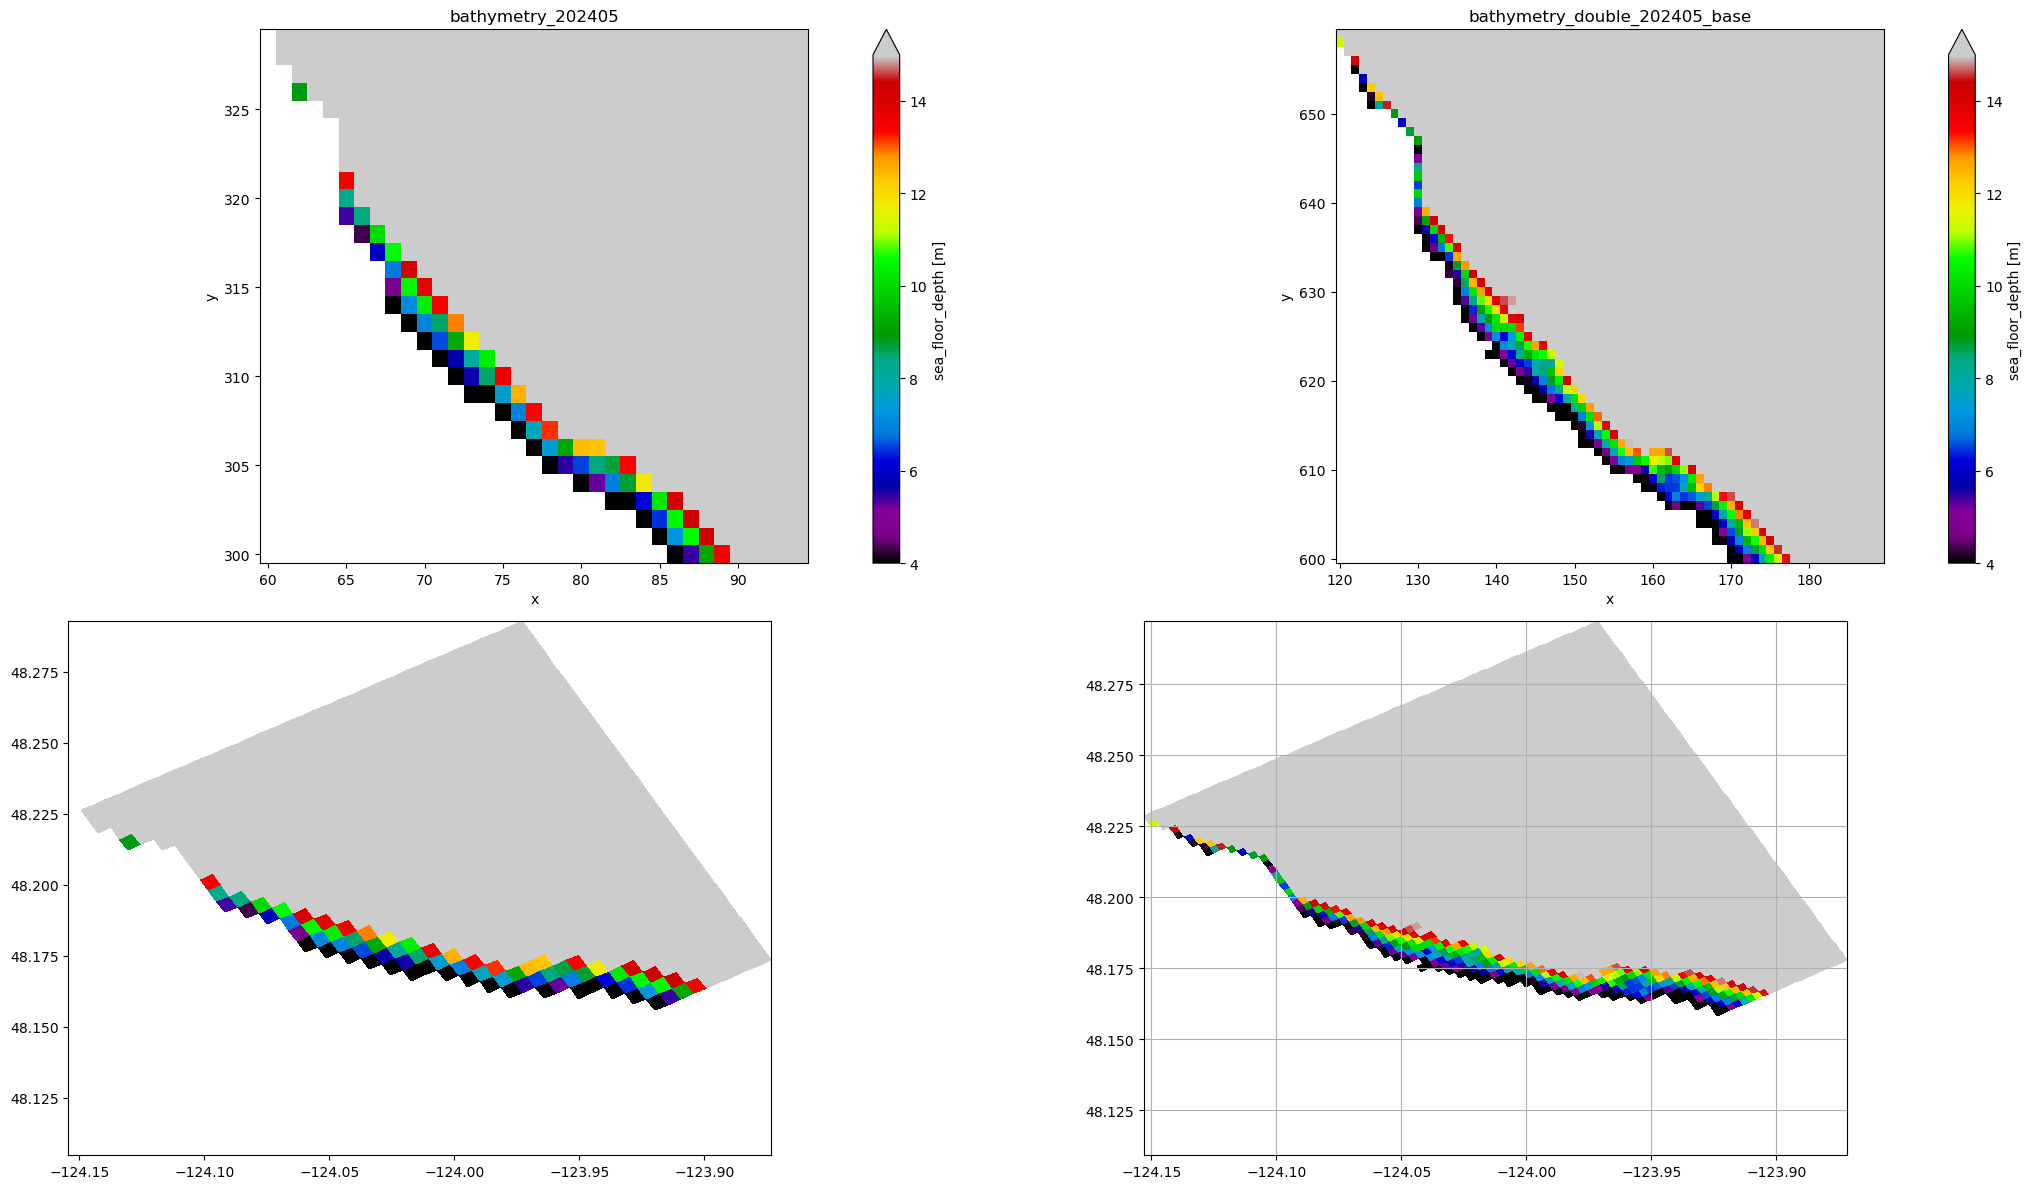

In [24]:
plot_tile(tile_x_min_max[2], y_slices, bathy, dbl_bathy_base)

### Tile 5, 3

* all >15m deep

### Tile 5, 4 - Sooke Harbour

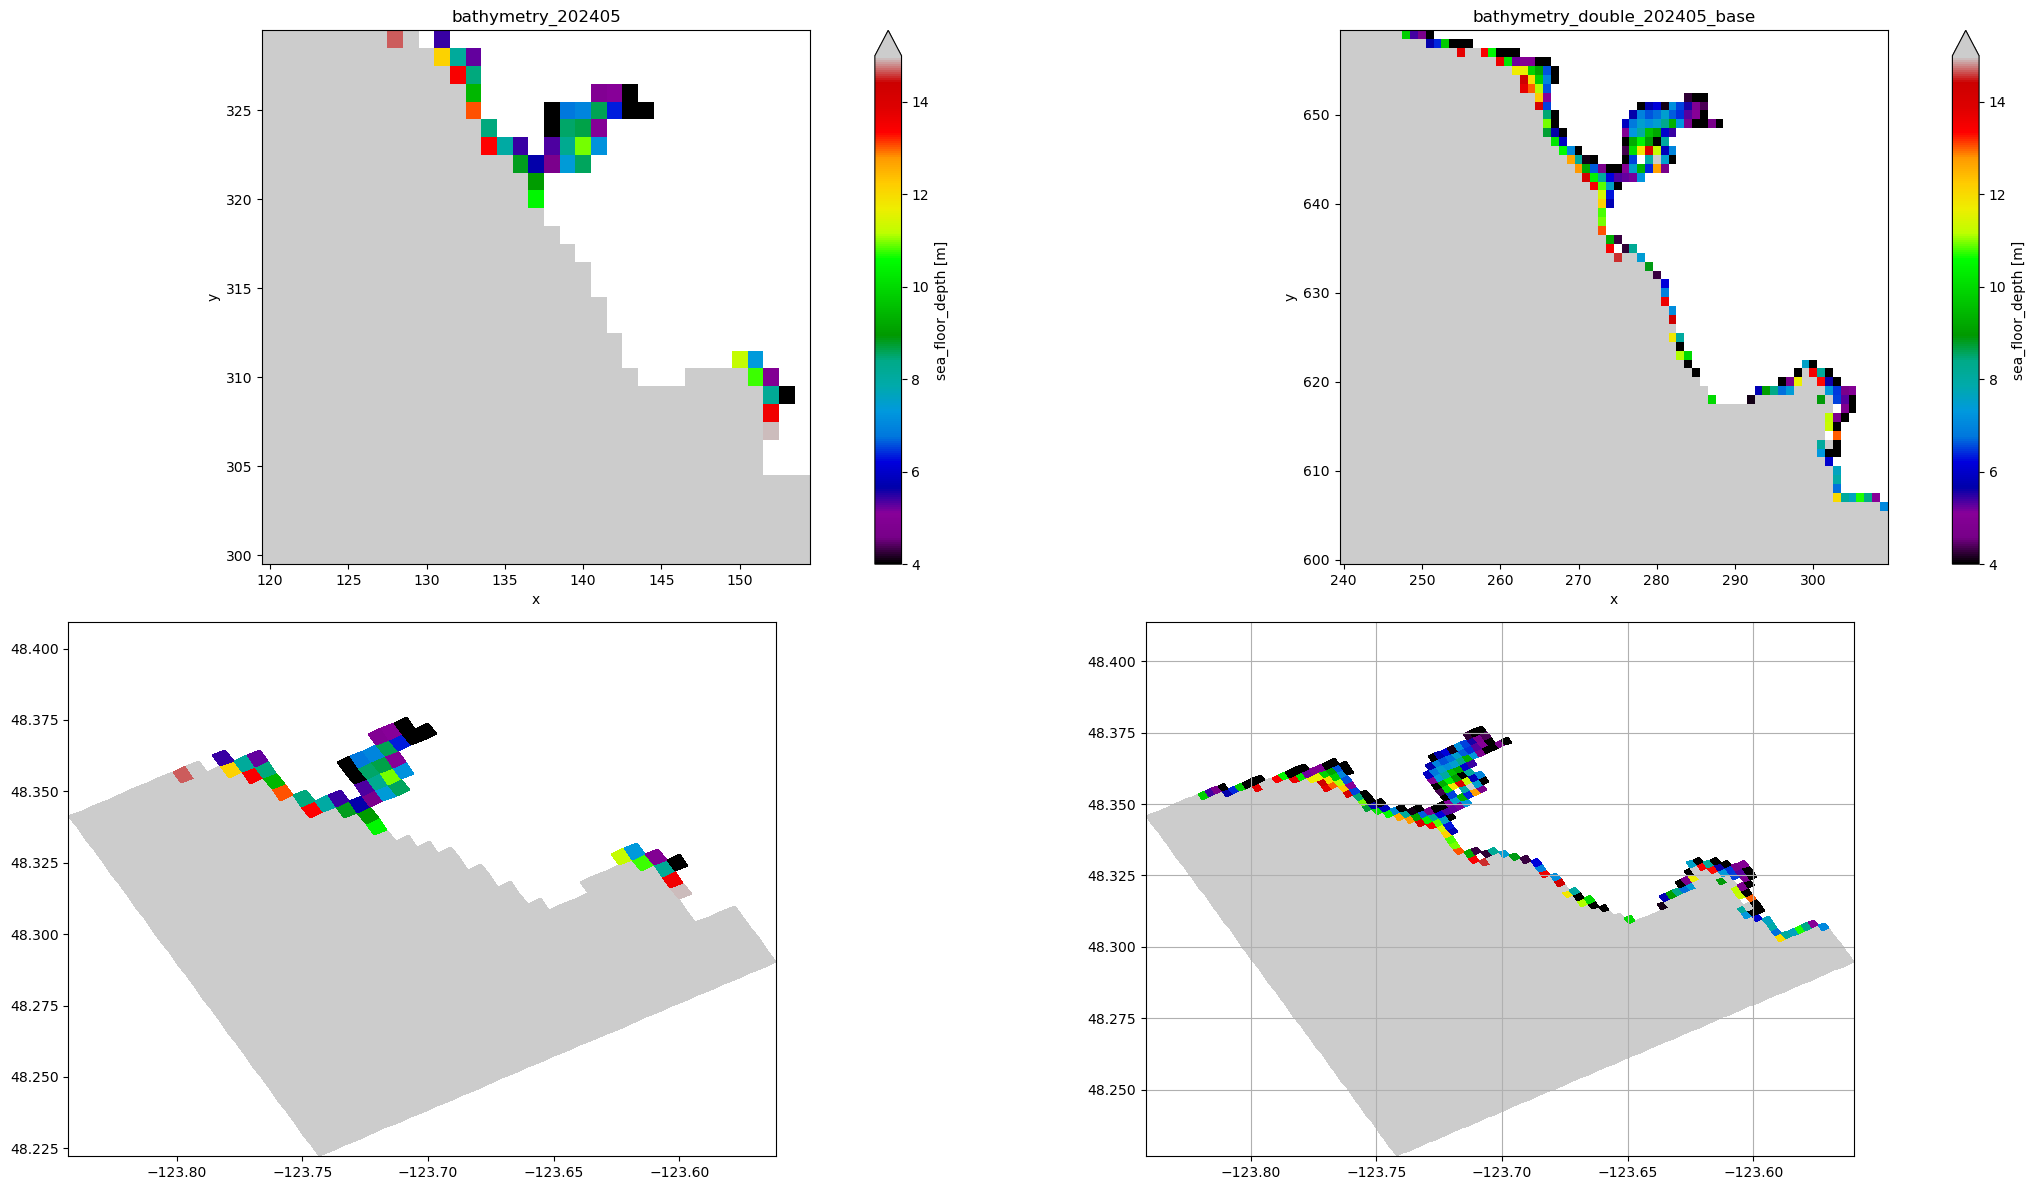

In [25]:
plot_tile(tile_x_min_max[4], y_slices, bathy, dbl_bathy_base)

### Tile 5, 5 - Metchosin

* connect island that is really end of William Head

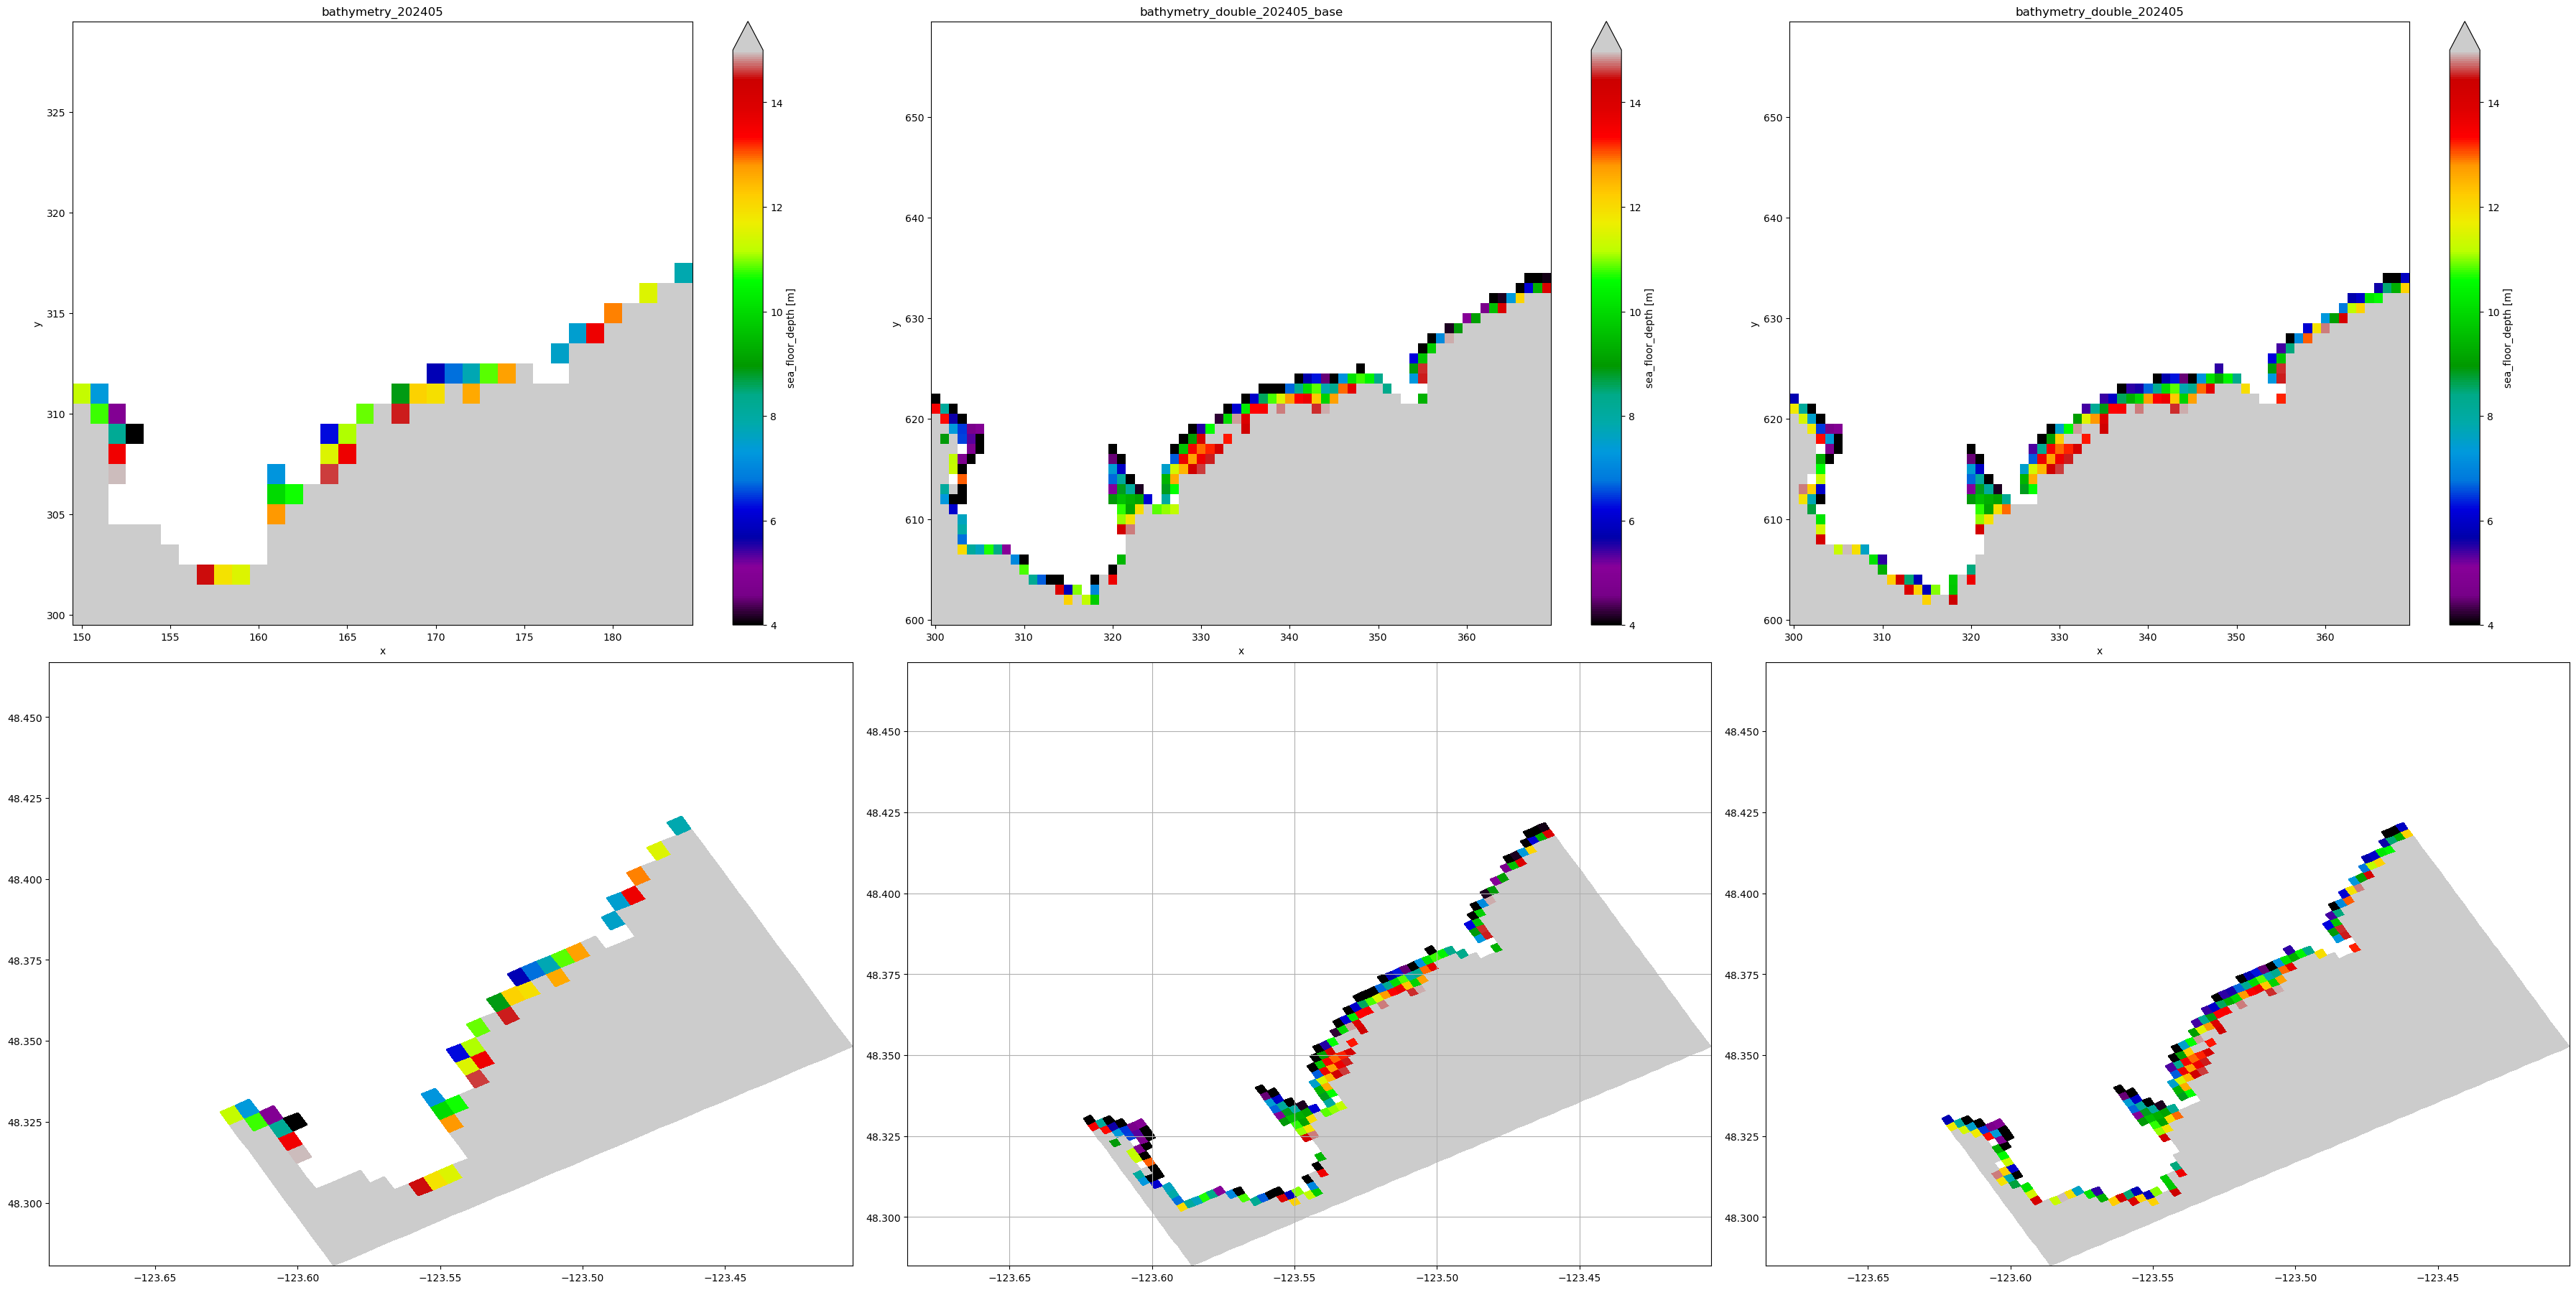

In [26]:
plot_tile(tile_x_min_max[5], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 5, 6 - Esquimalt and Victoria

* connect islands to make Esquimalt Point
* surface Chain Islands?

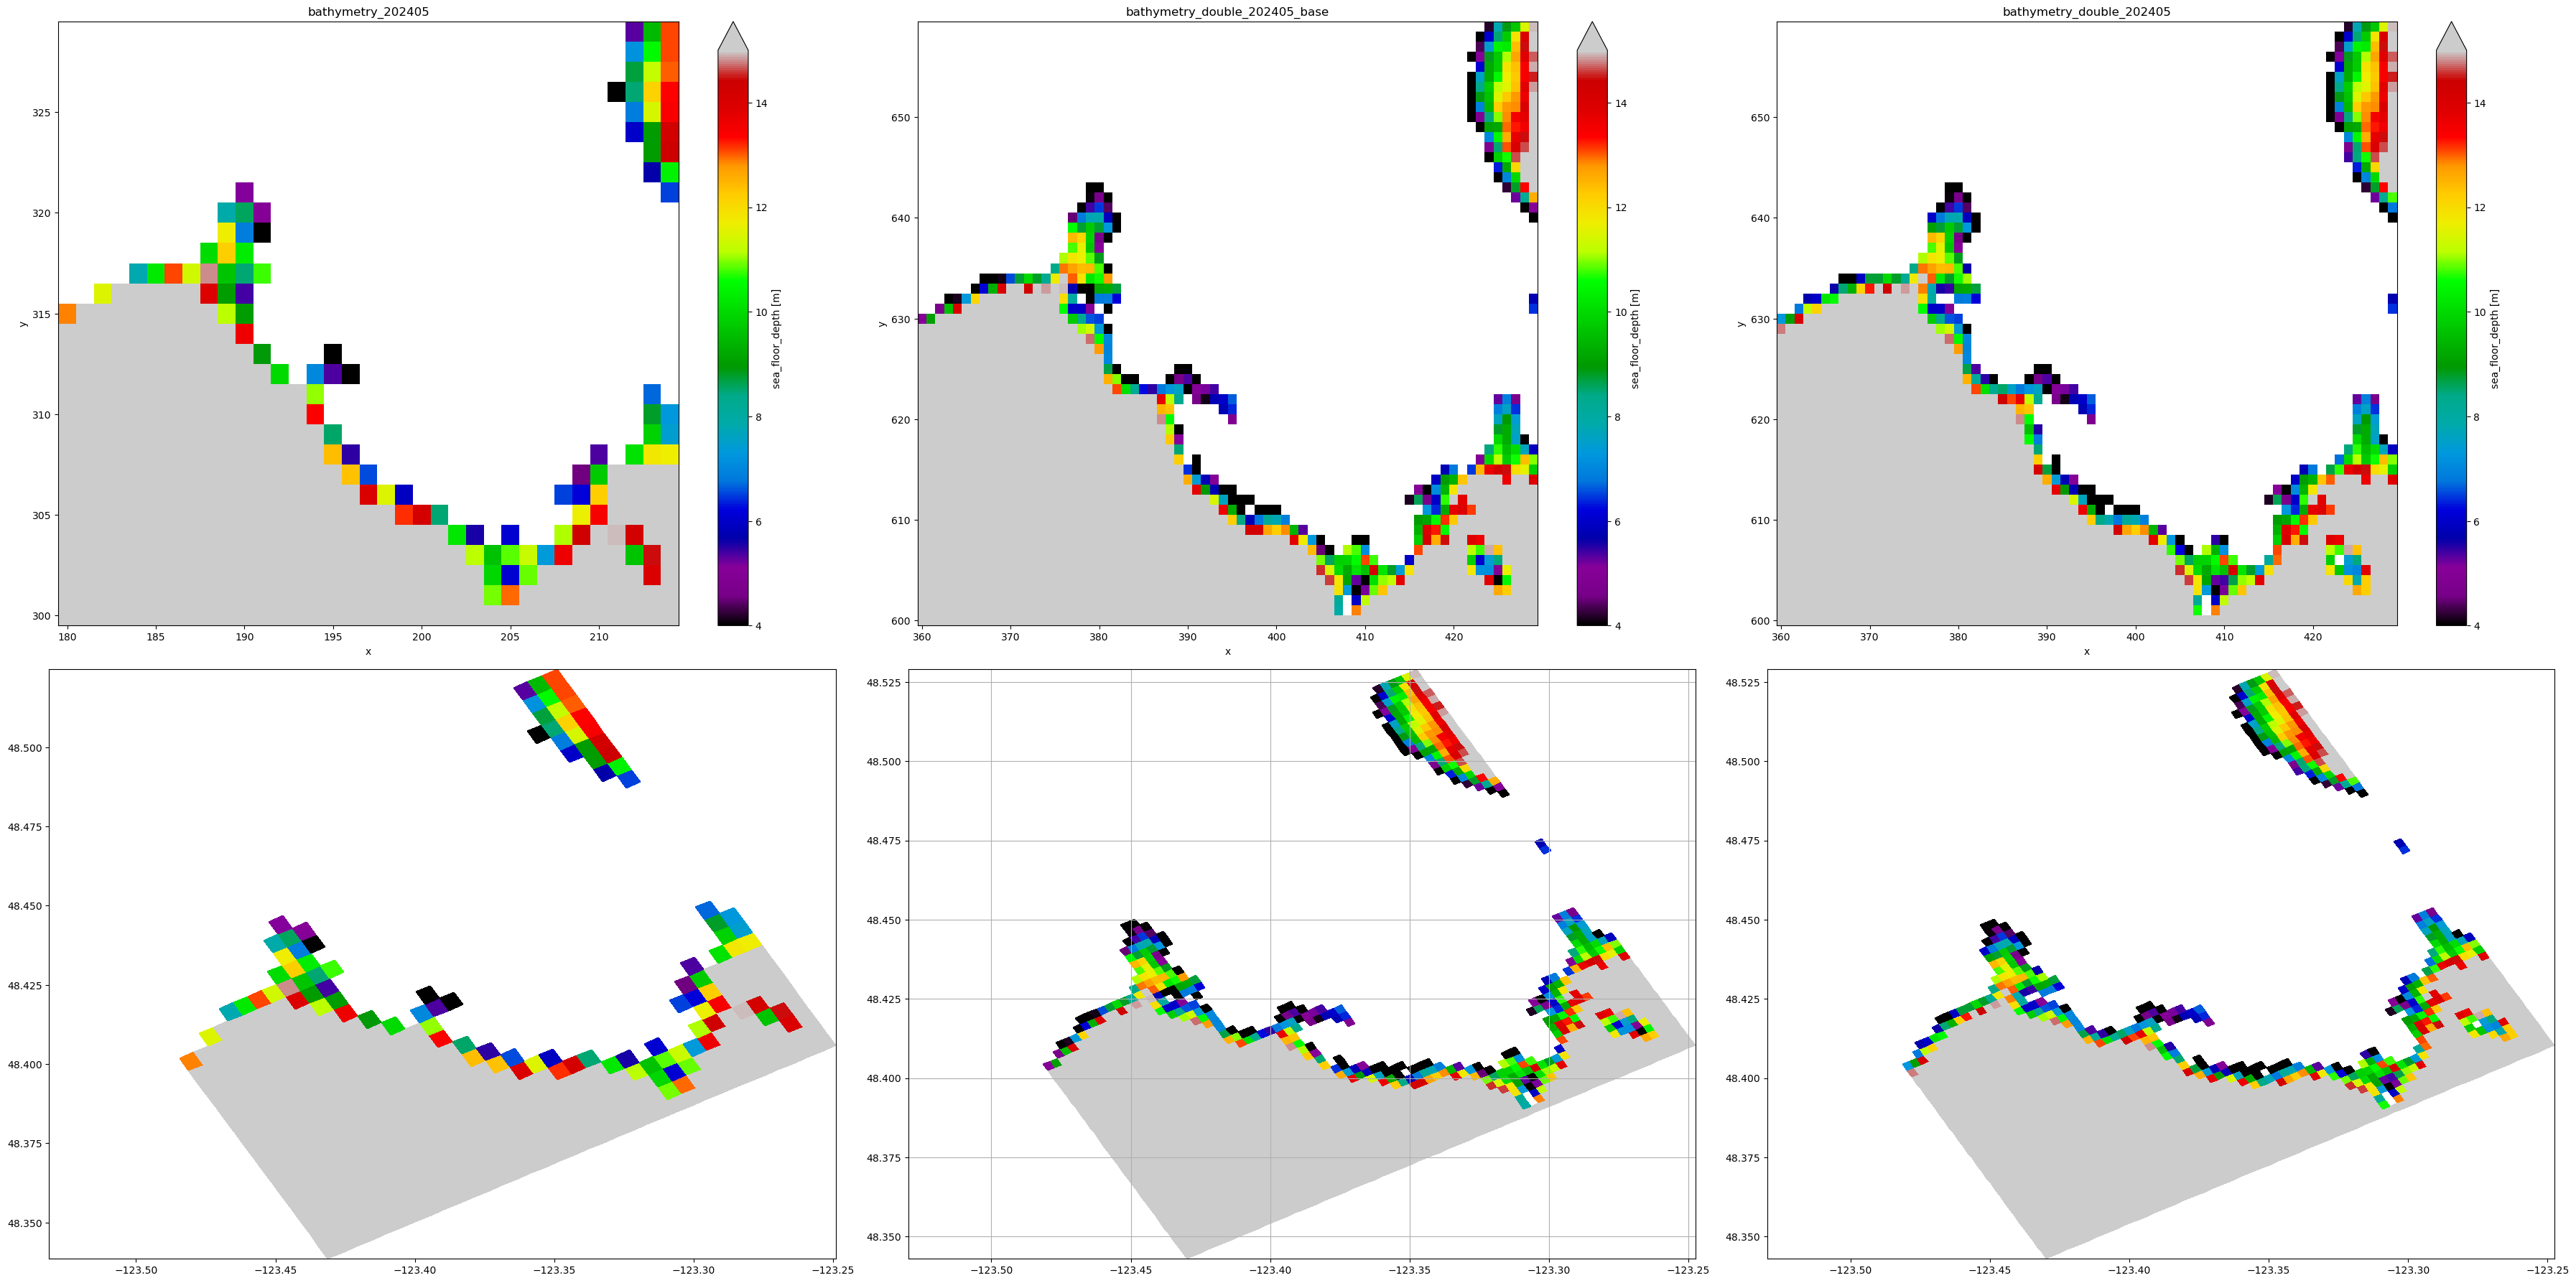

In [27]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 5, 7 - Haro Strait

* fix Discovery Island
* Make east Chatham Island T-shaped

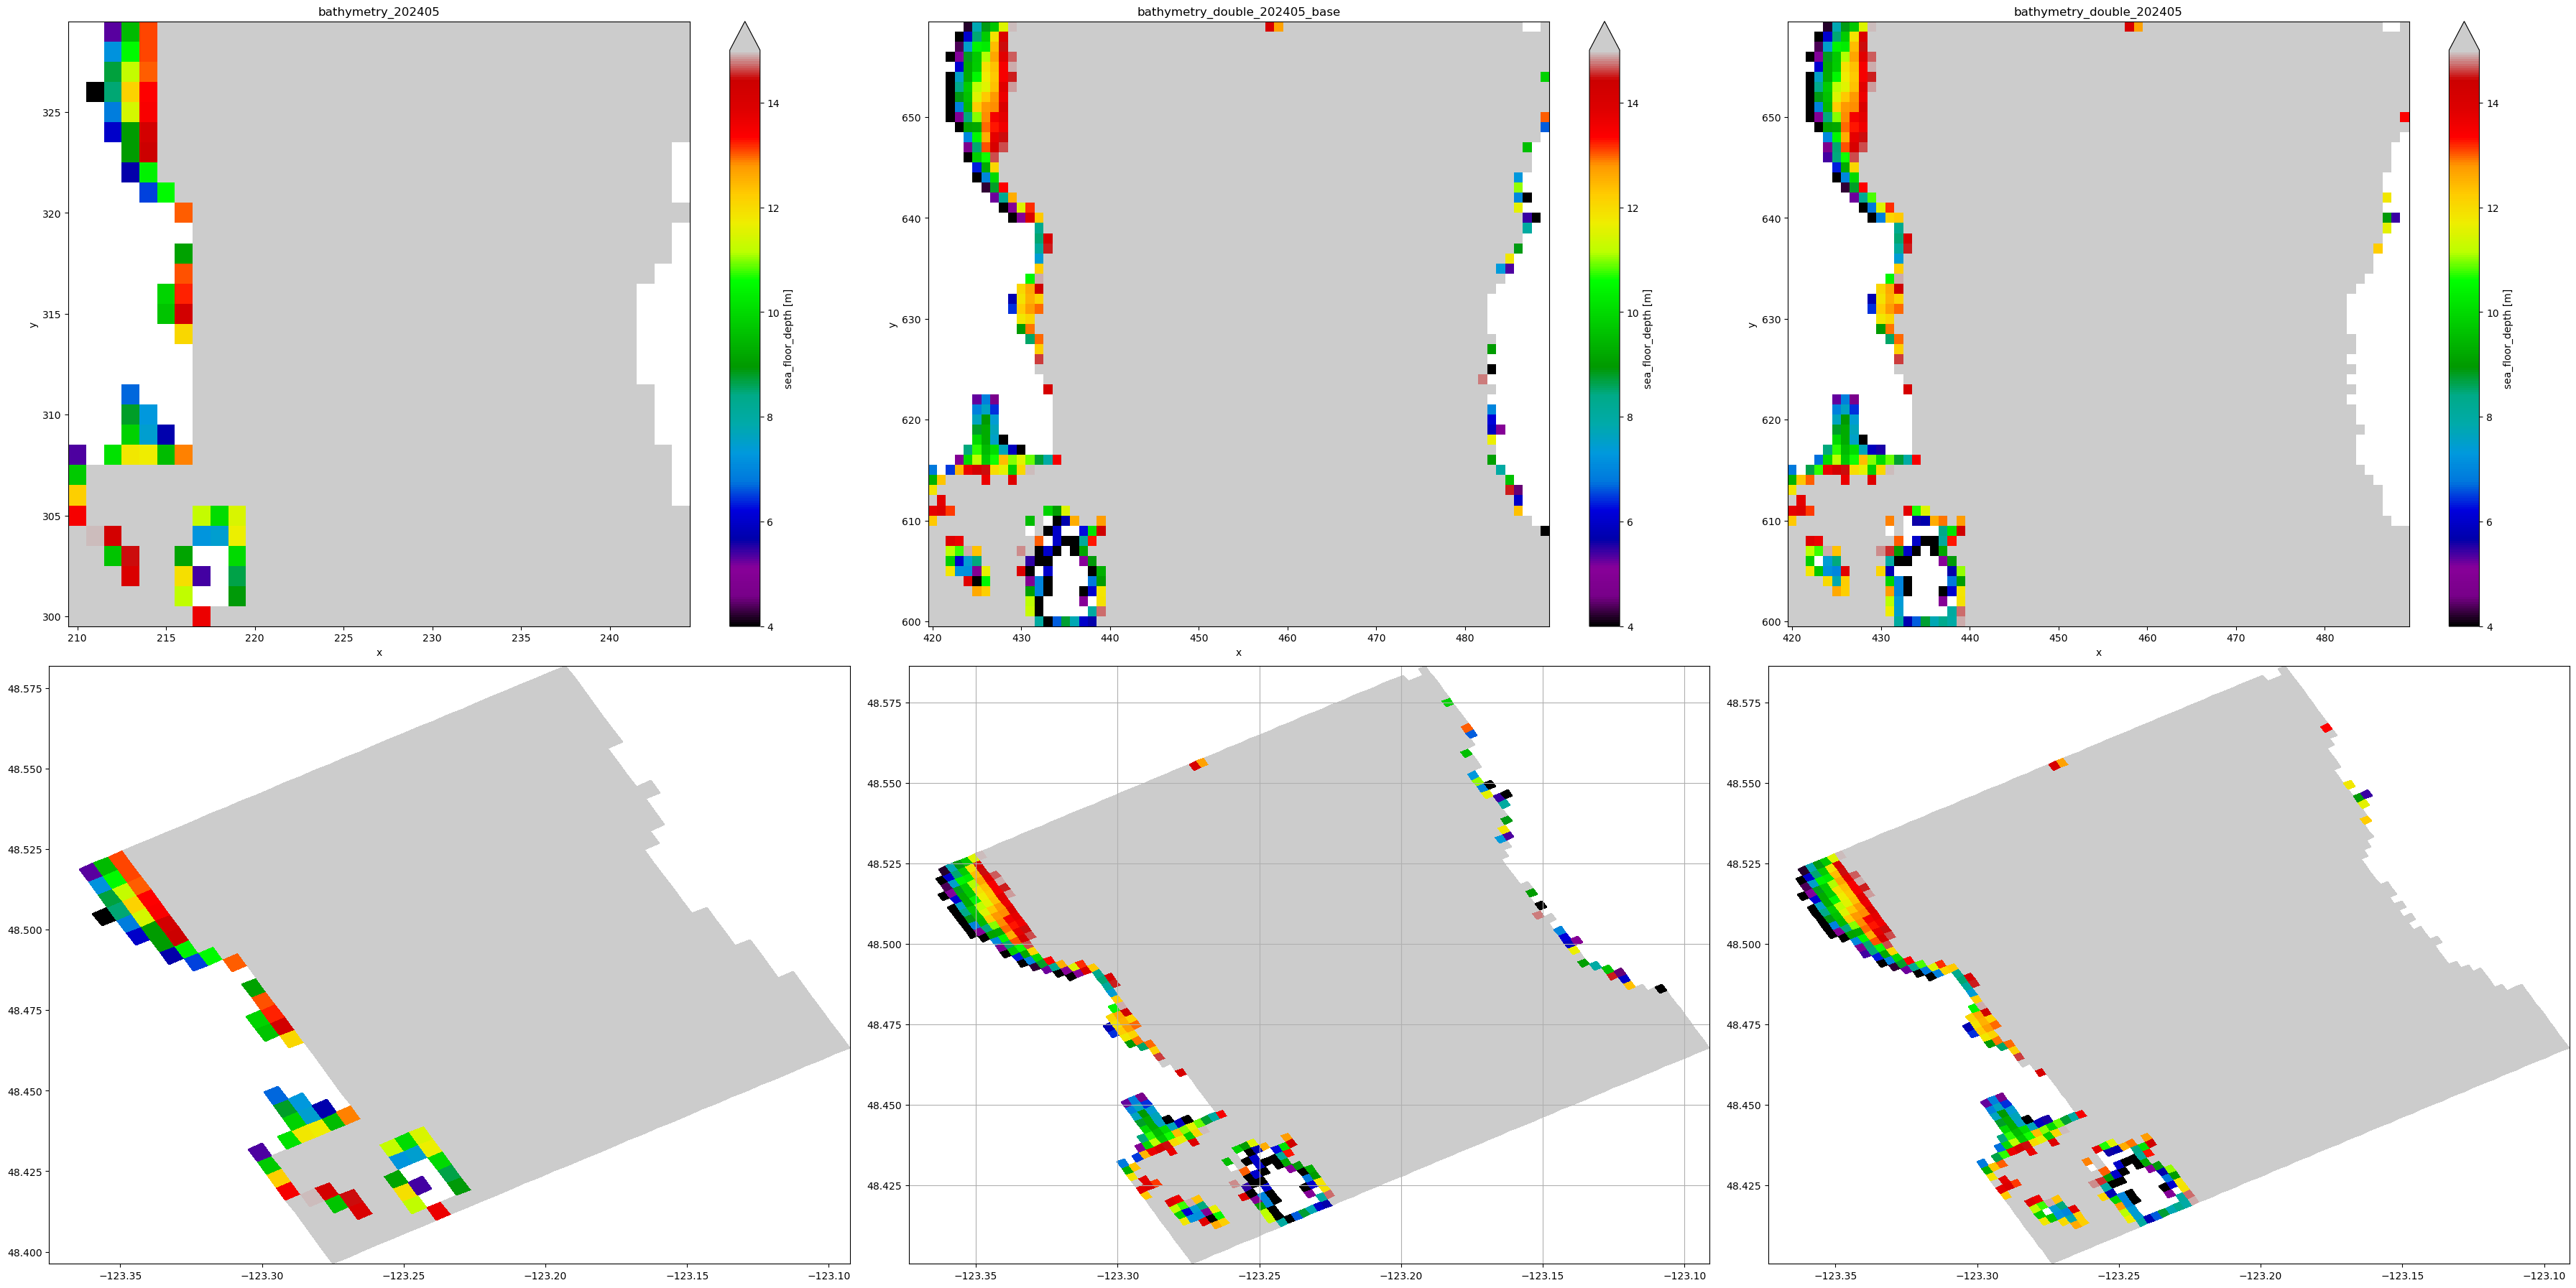

In [28]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 5, 8 - San Juan Island


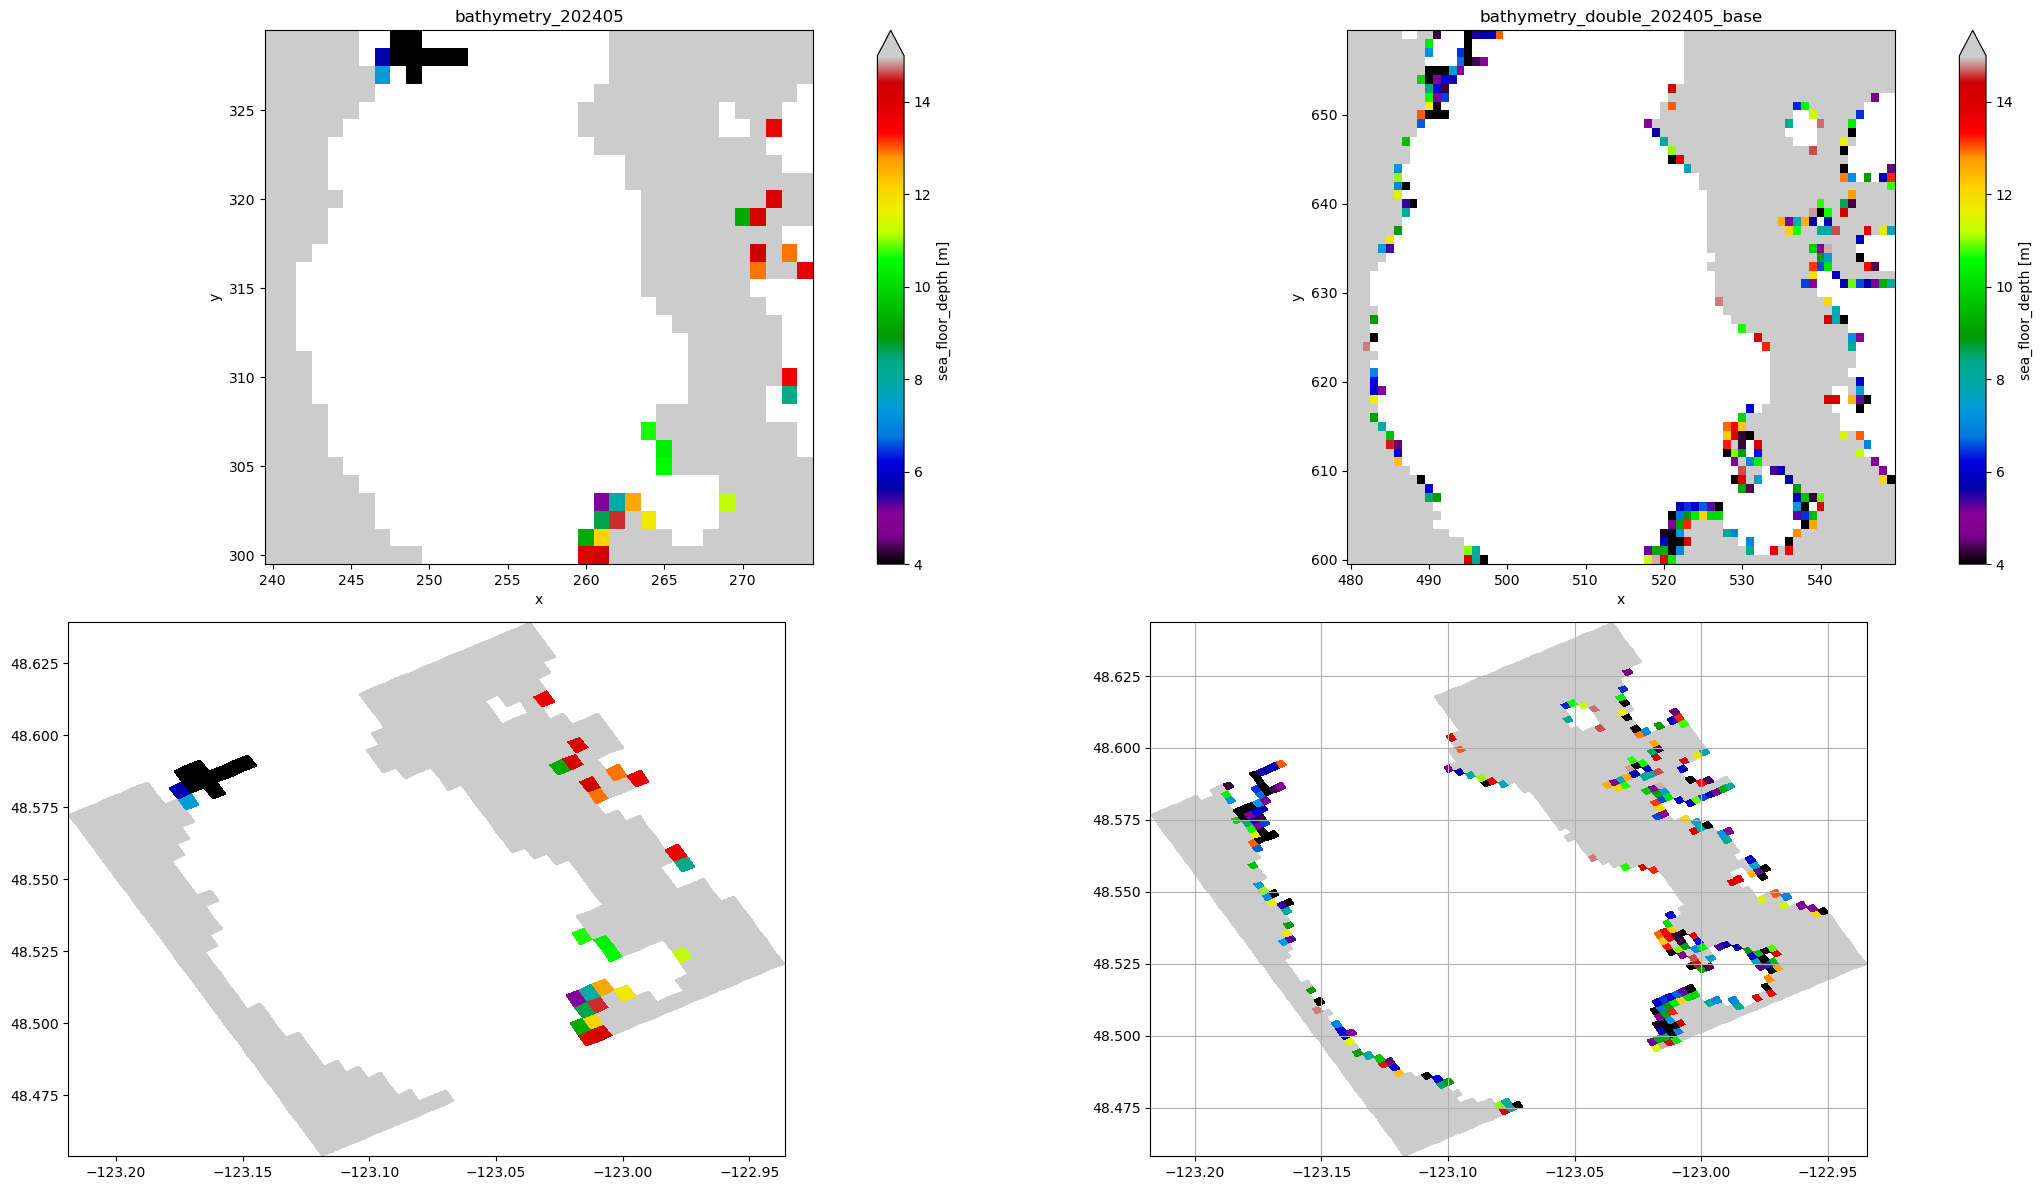

In [29]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base)

### Tile 5, 9 - Orcas Island


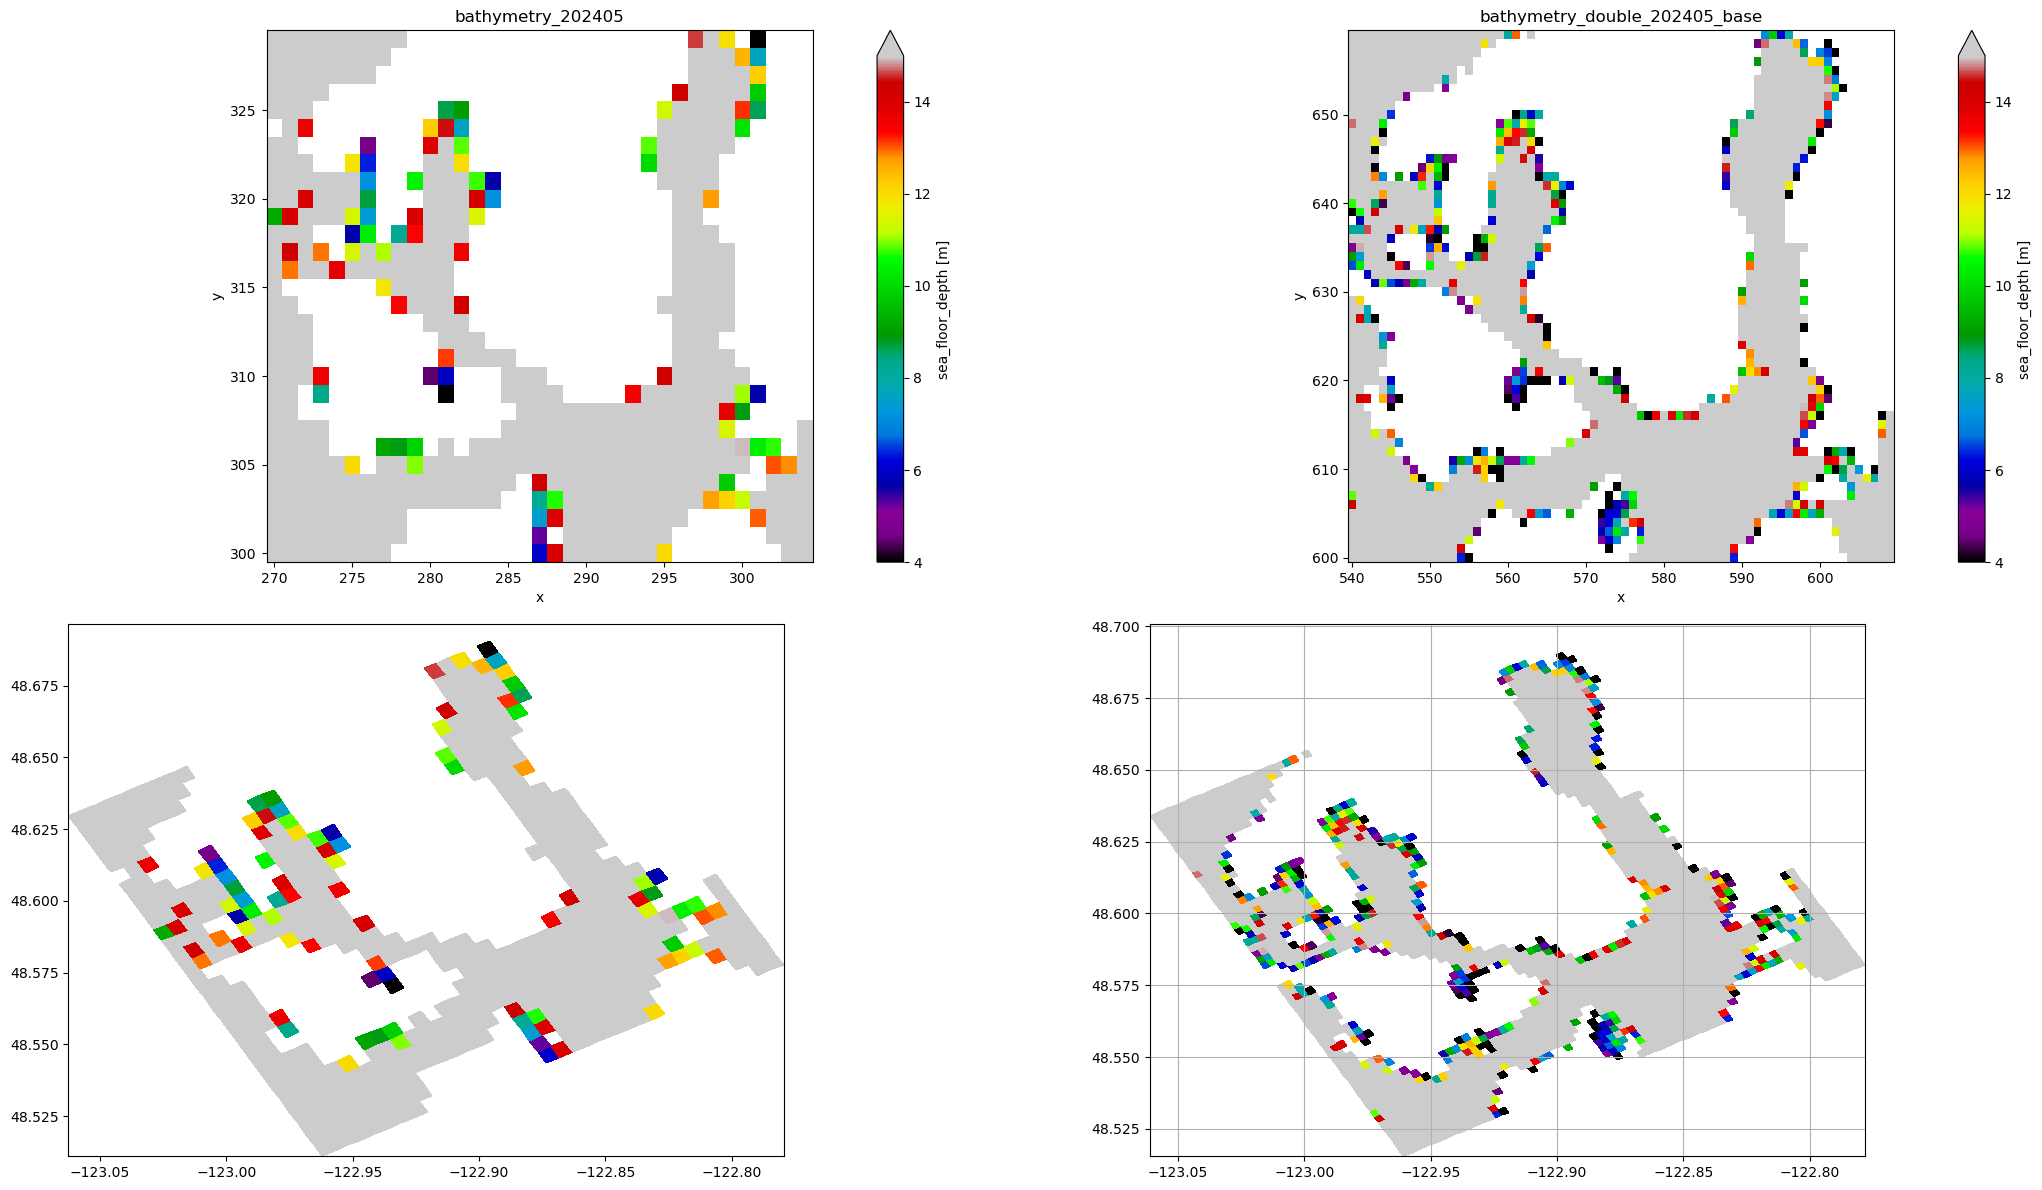

In [30]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base)

### Tile 5, 10 - North Rossario Strait


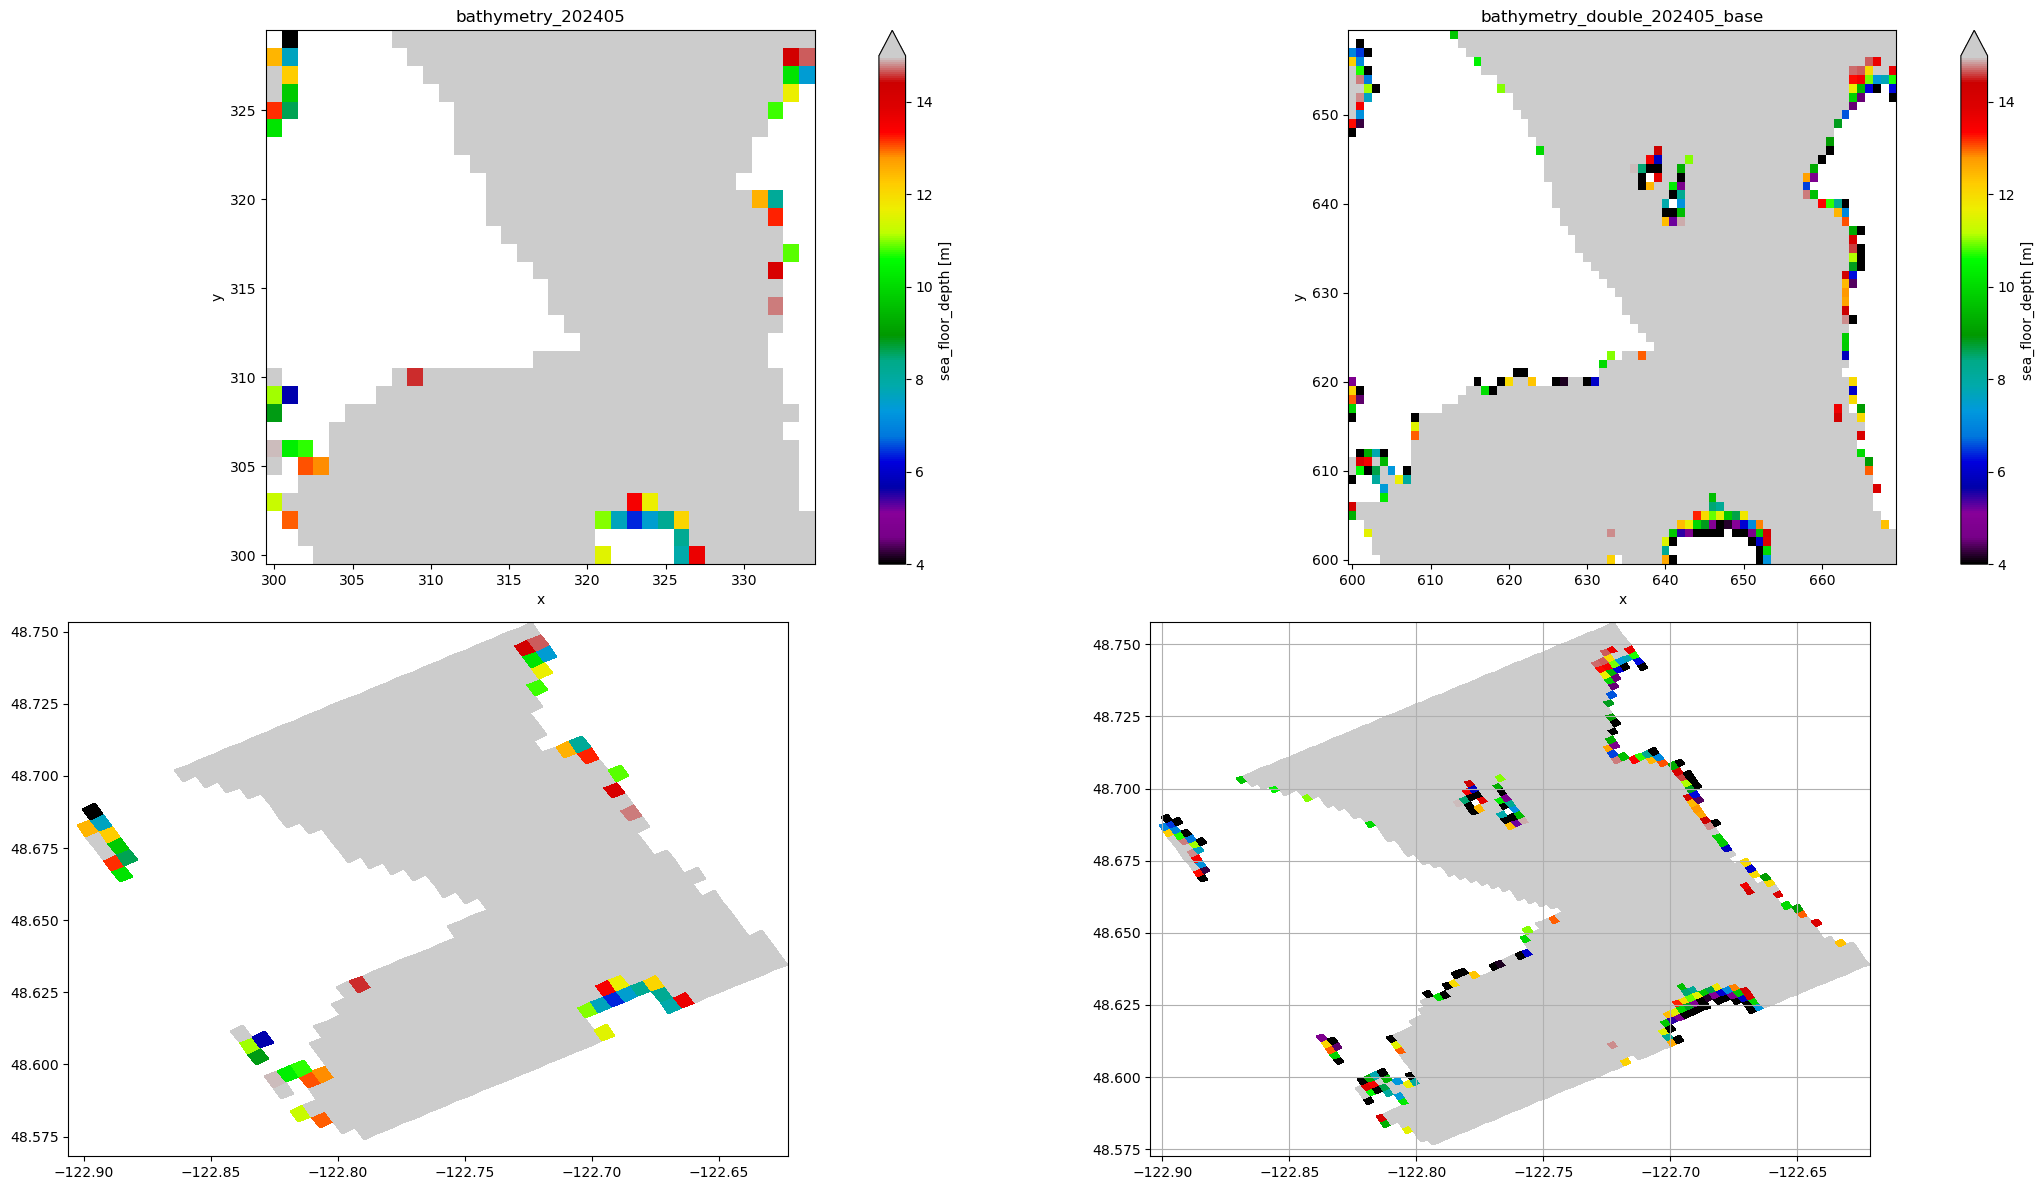

In [31]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base)

### Tile 5, 11 - Lummi Island and Bellingham Bay

* Portage Island is connected to Lummi Point in reality; perhaps an artificial isthmus

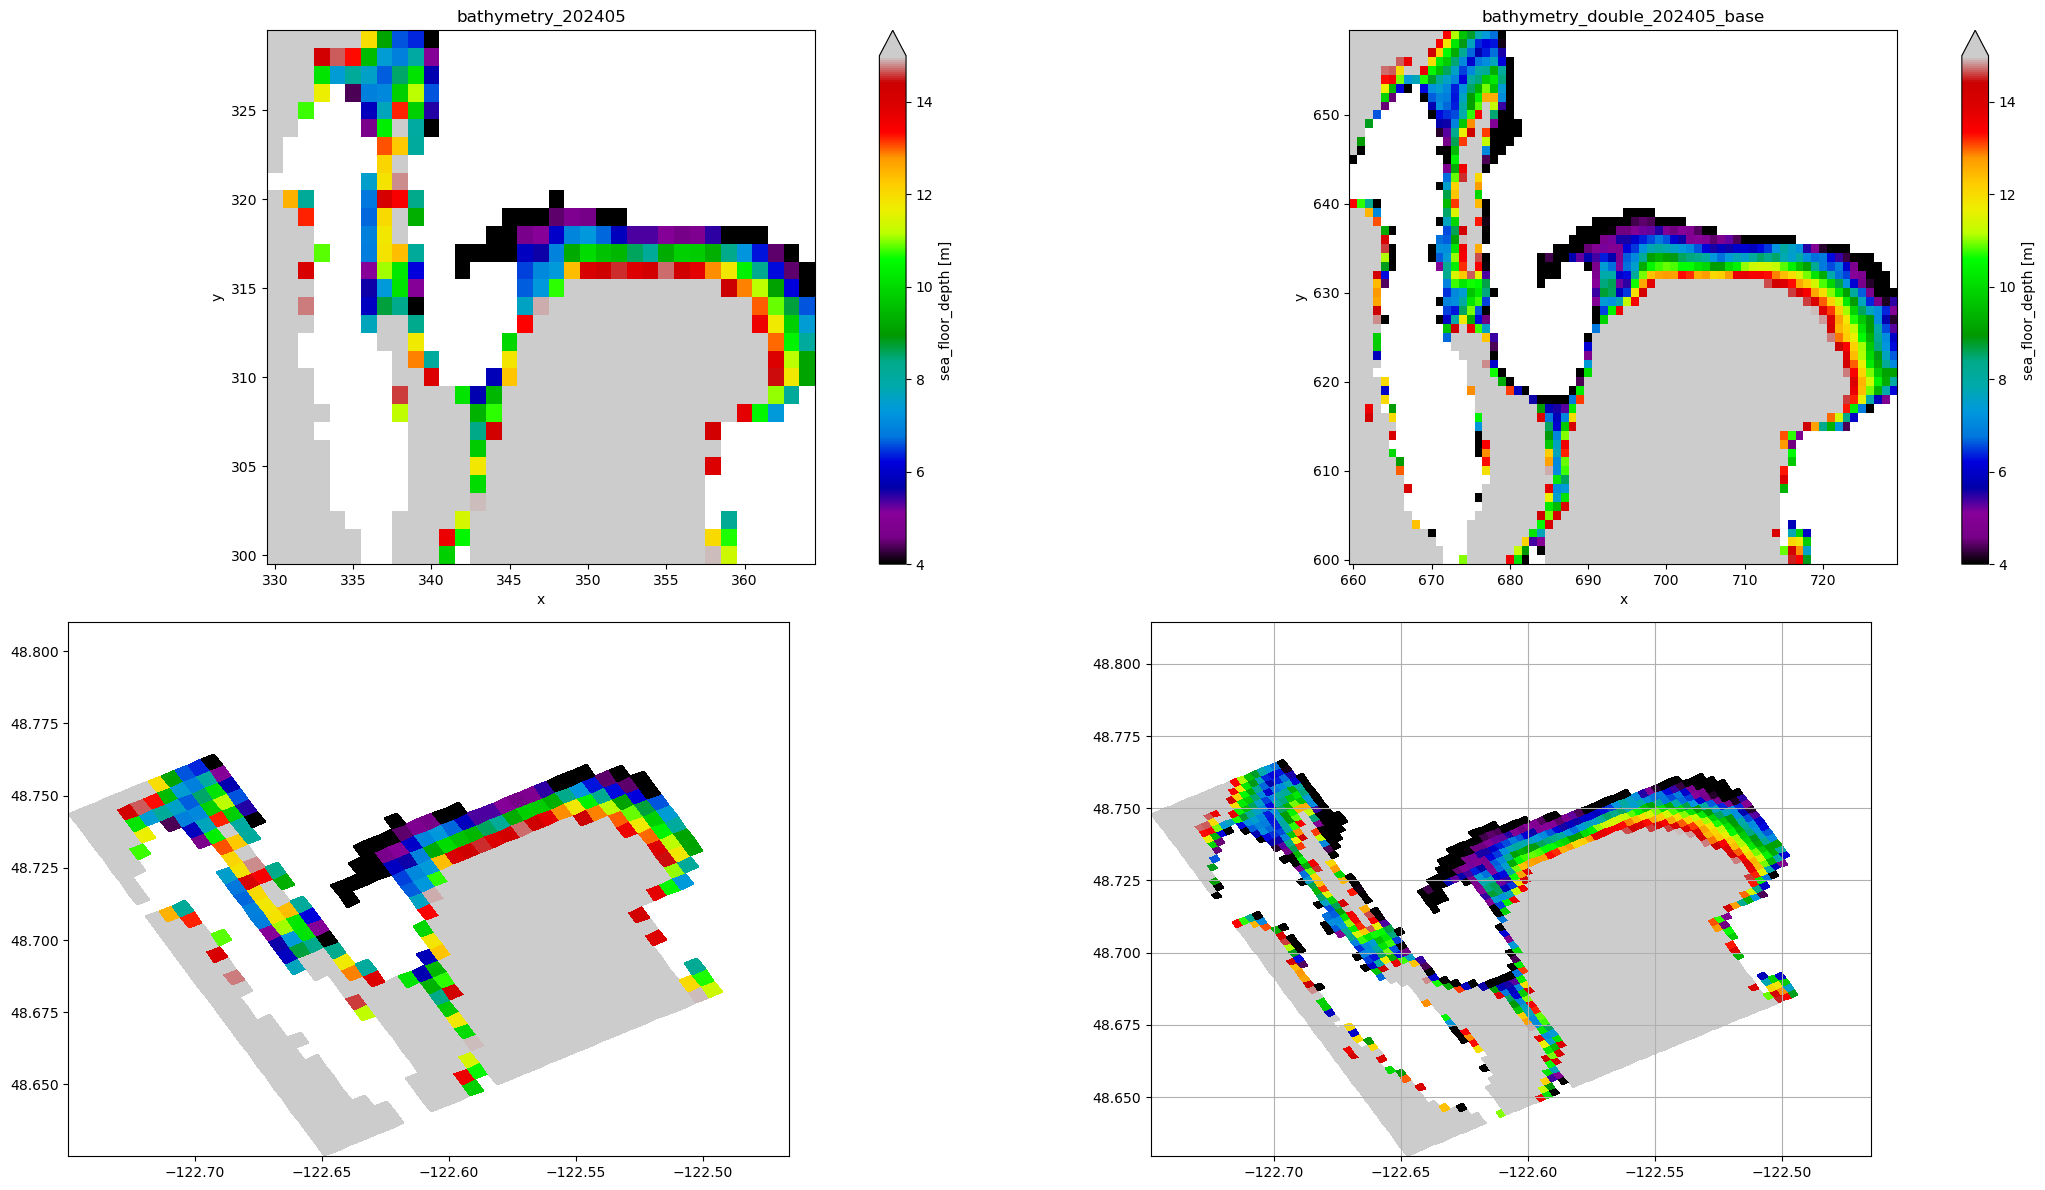

In [32]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base)

### Tile 5, 12 - East bit of Bellingham Bay

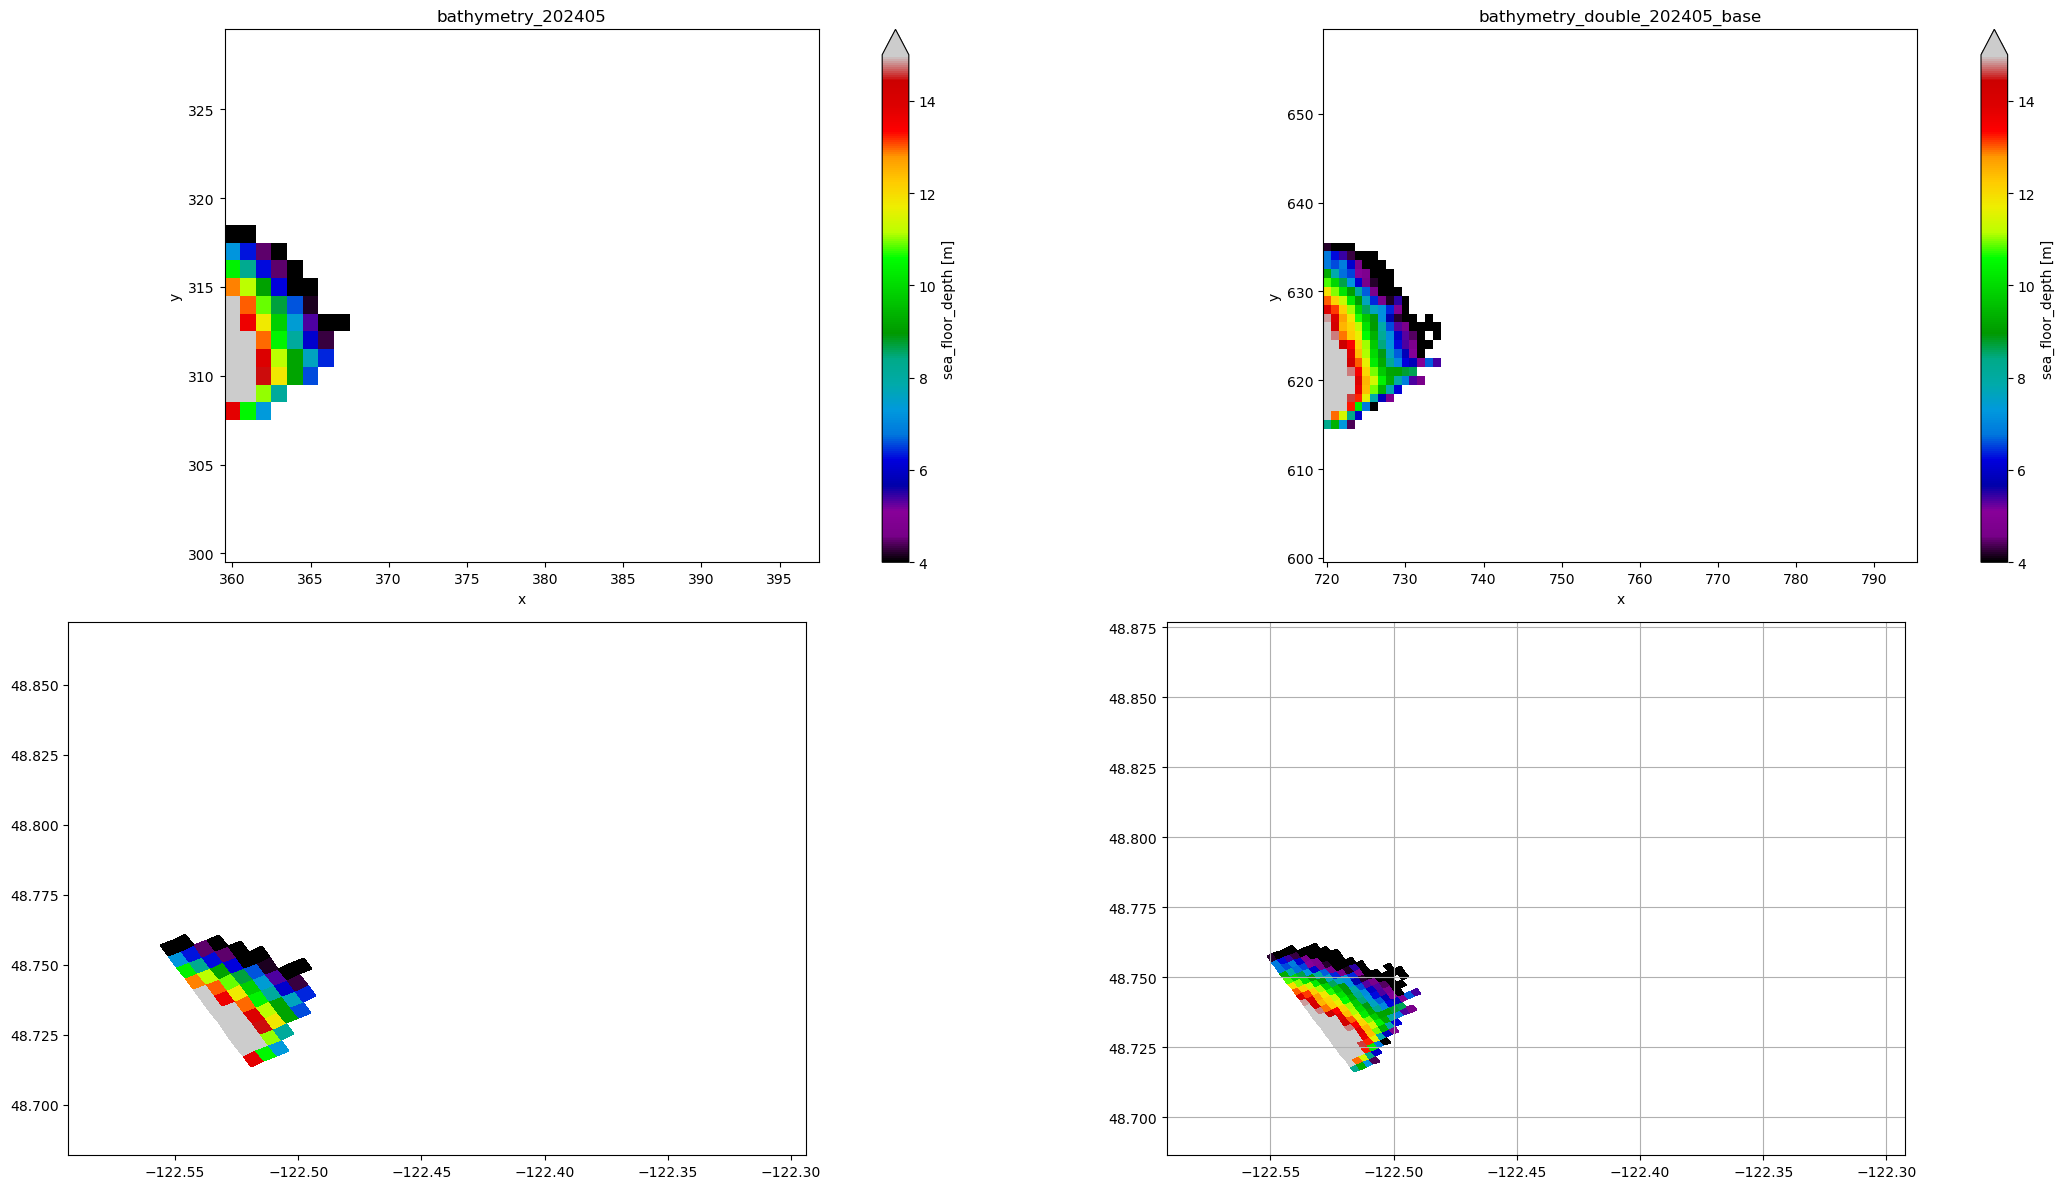

In [33]:
plot_tile(tile_x_min_max[12], y_slices, bathy, dbl_bathy_base)

## Row 6 - Juan de Fuca, Jordan River, Saanich Inlet, boundary islands, Neptune Beach

In [34]:
y_min_max = numpy.array([330, 360])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 6, 0 - Between the mouths of the Sekiu and Hoko Rivers

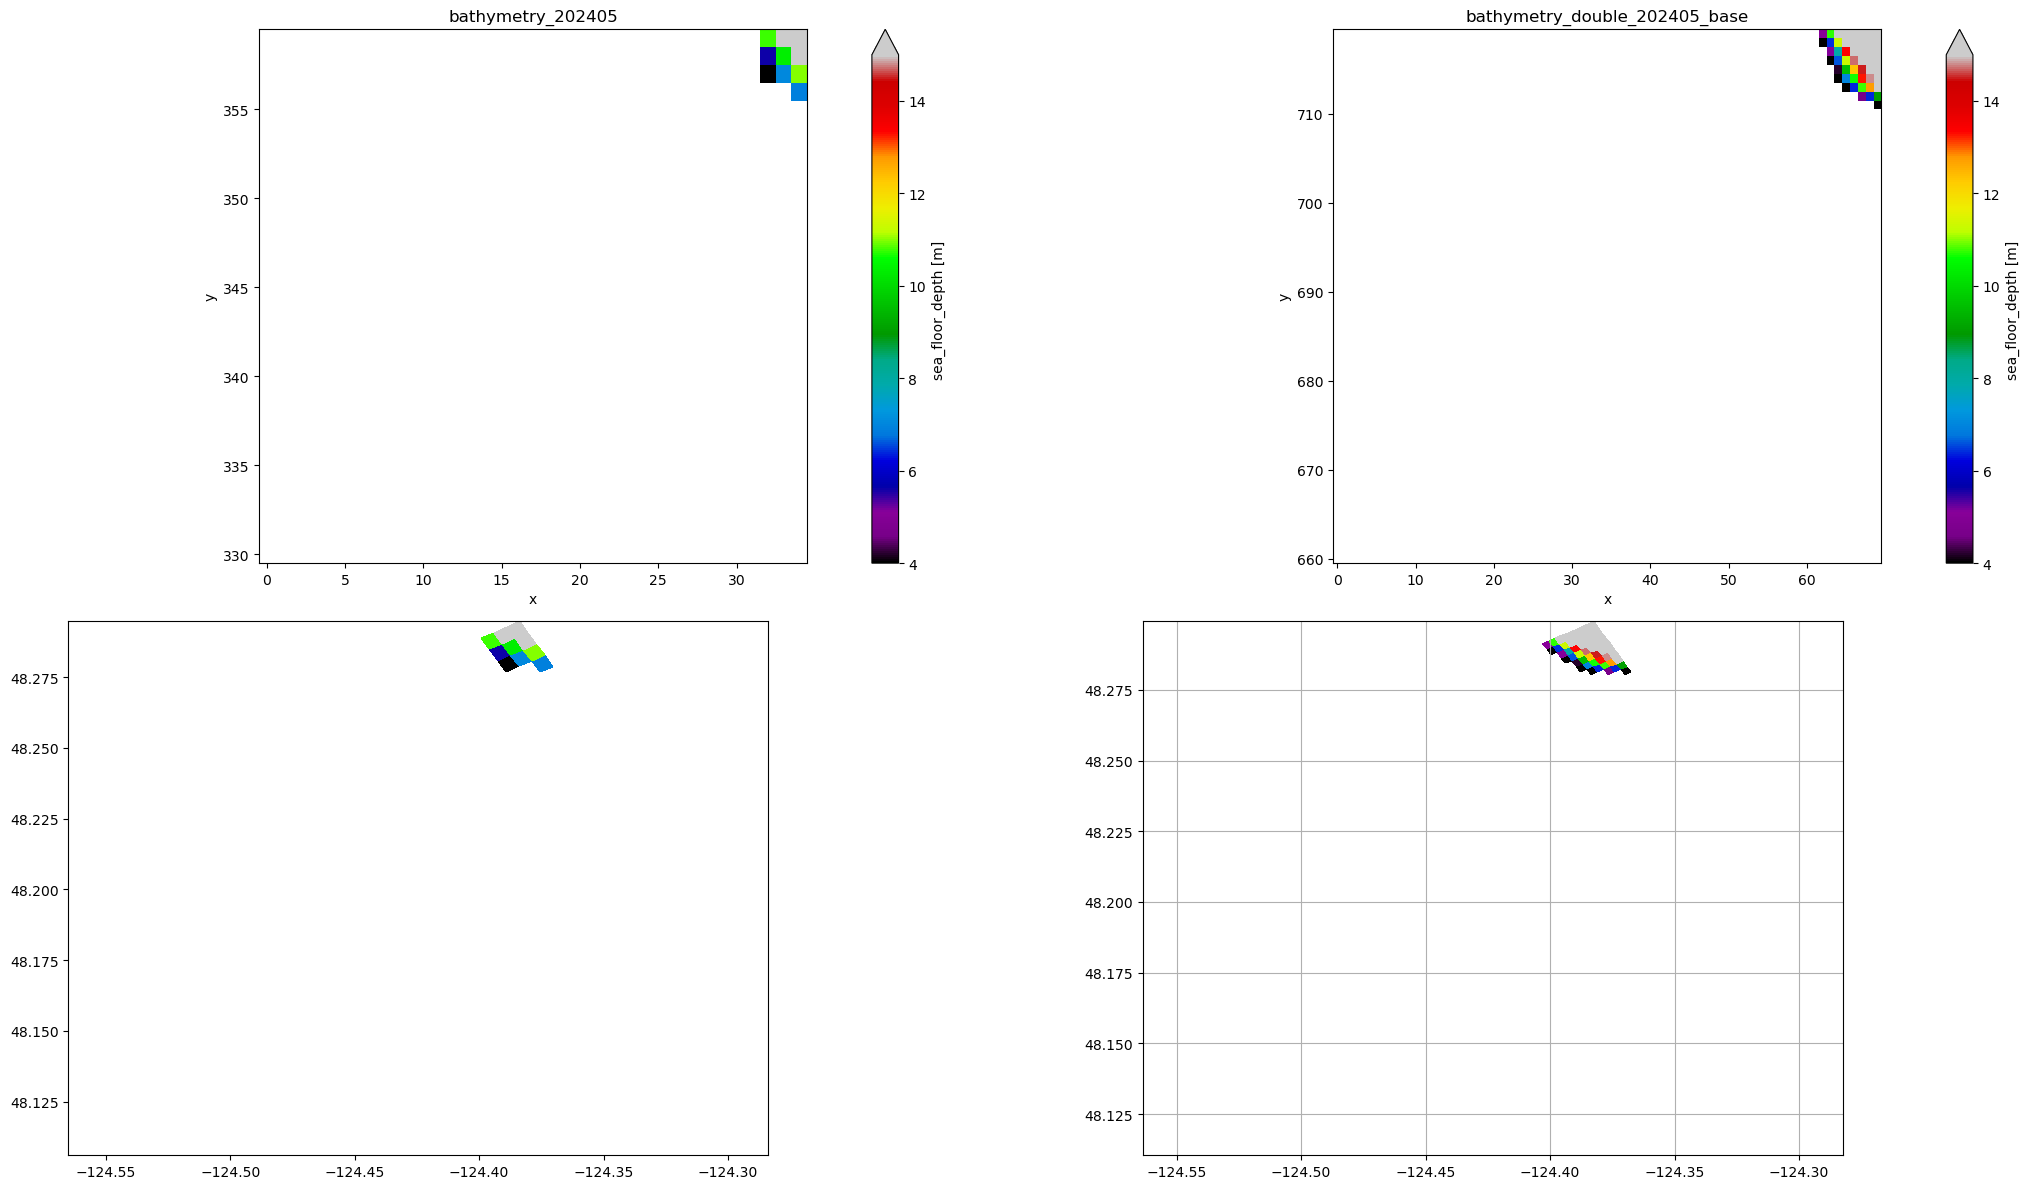

In [35]:
plot_tile(tile_x_min_max[0], y_slices, bathy, dbl_bathy_base)




### Tile 6, 1 - Clallam Bay

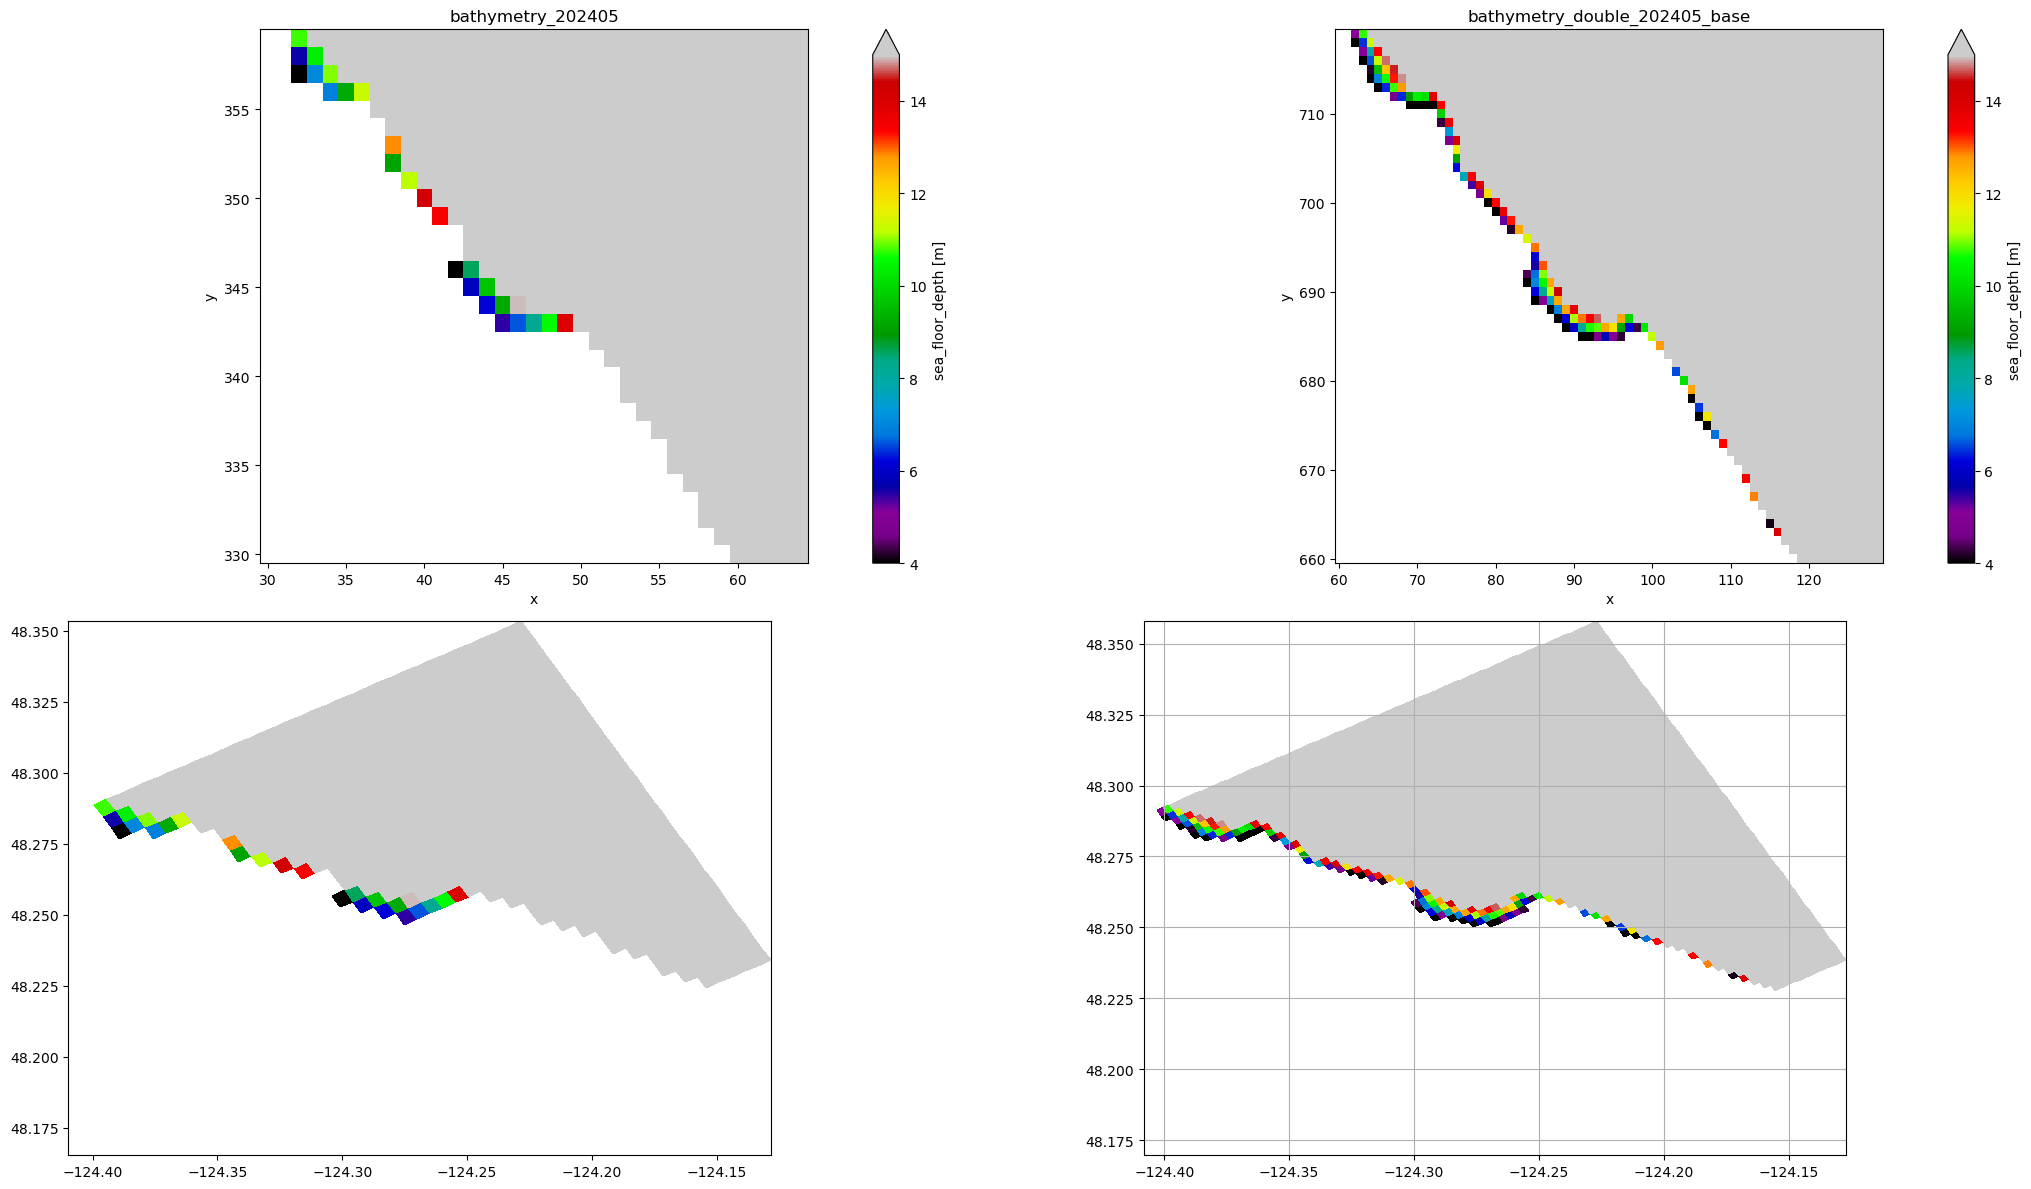

In [36]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 6, 2

* all >15m deep

### Tile 6, 3 - Jordan River, French Beach, and Sheringham Point

* Remove extraneous island off French Beach

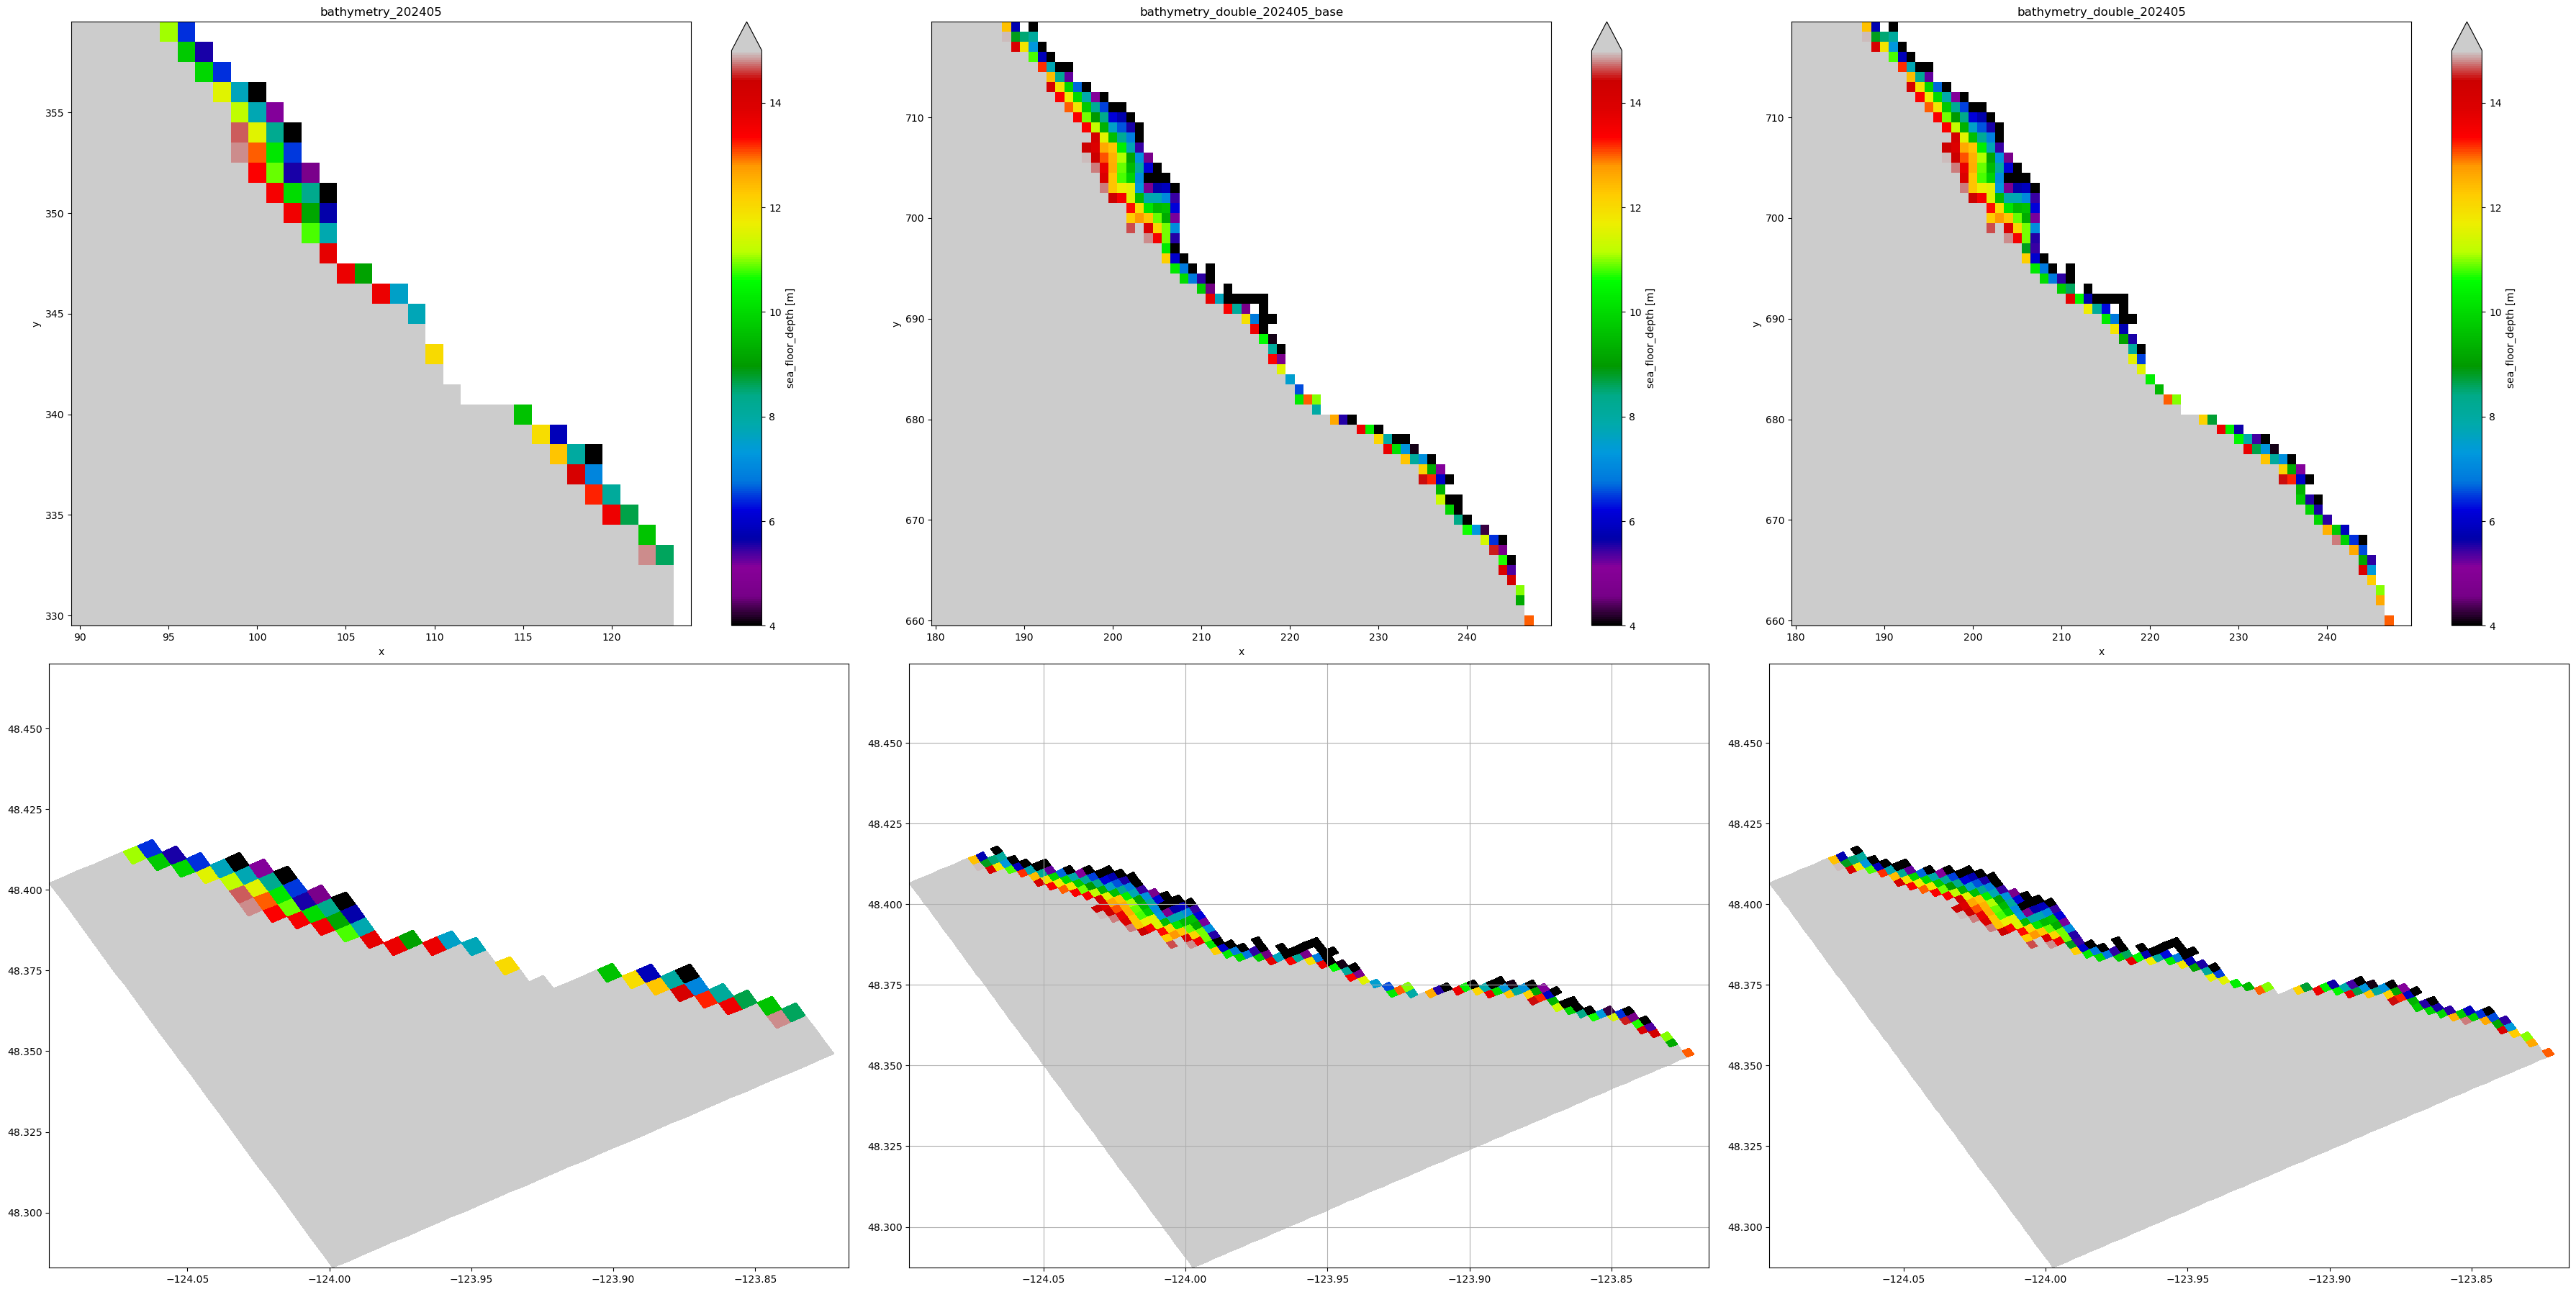

In [37]:
plot_tile(tile_x_min_max[3], y_slices, bathy, dbl_bathy_base, dbl_bathy)


























### Tile 6, 4 - Near Muir Creek Beach

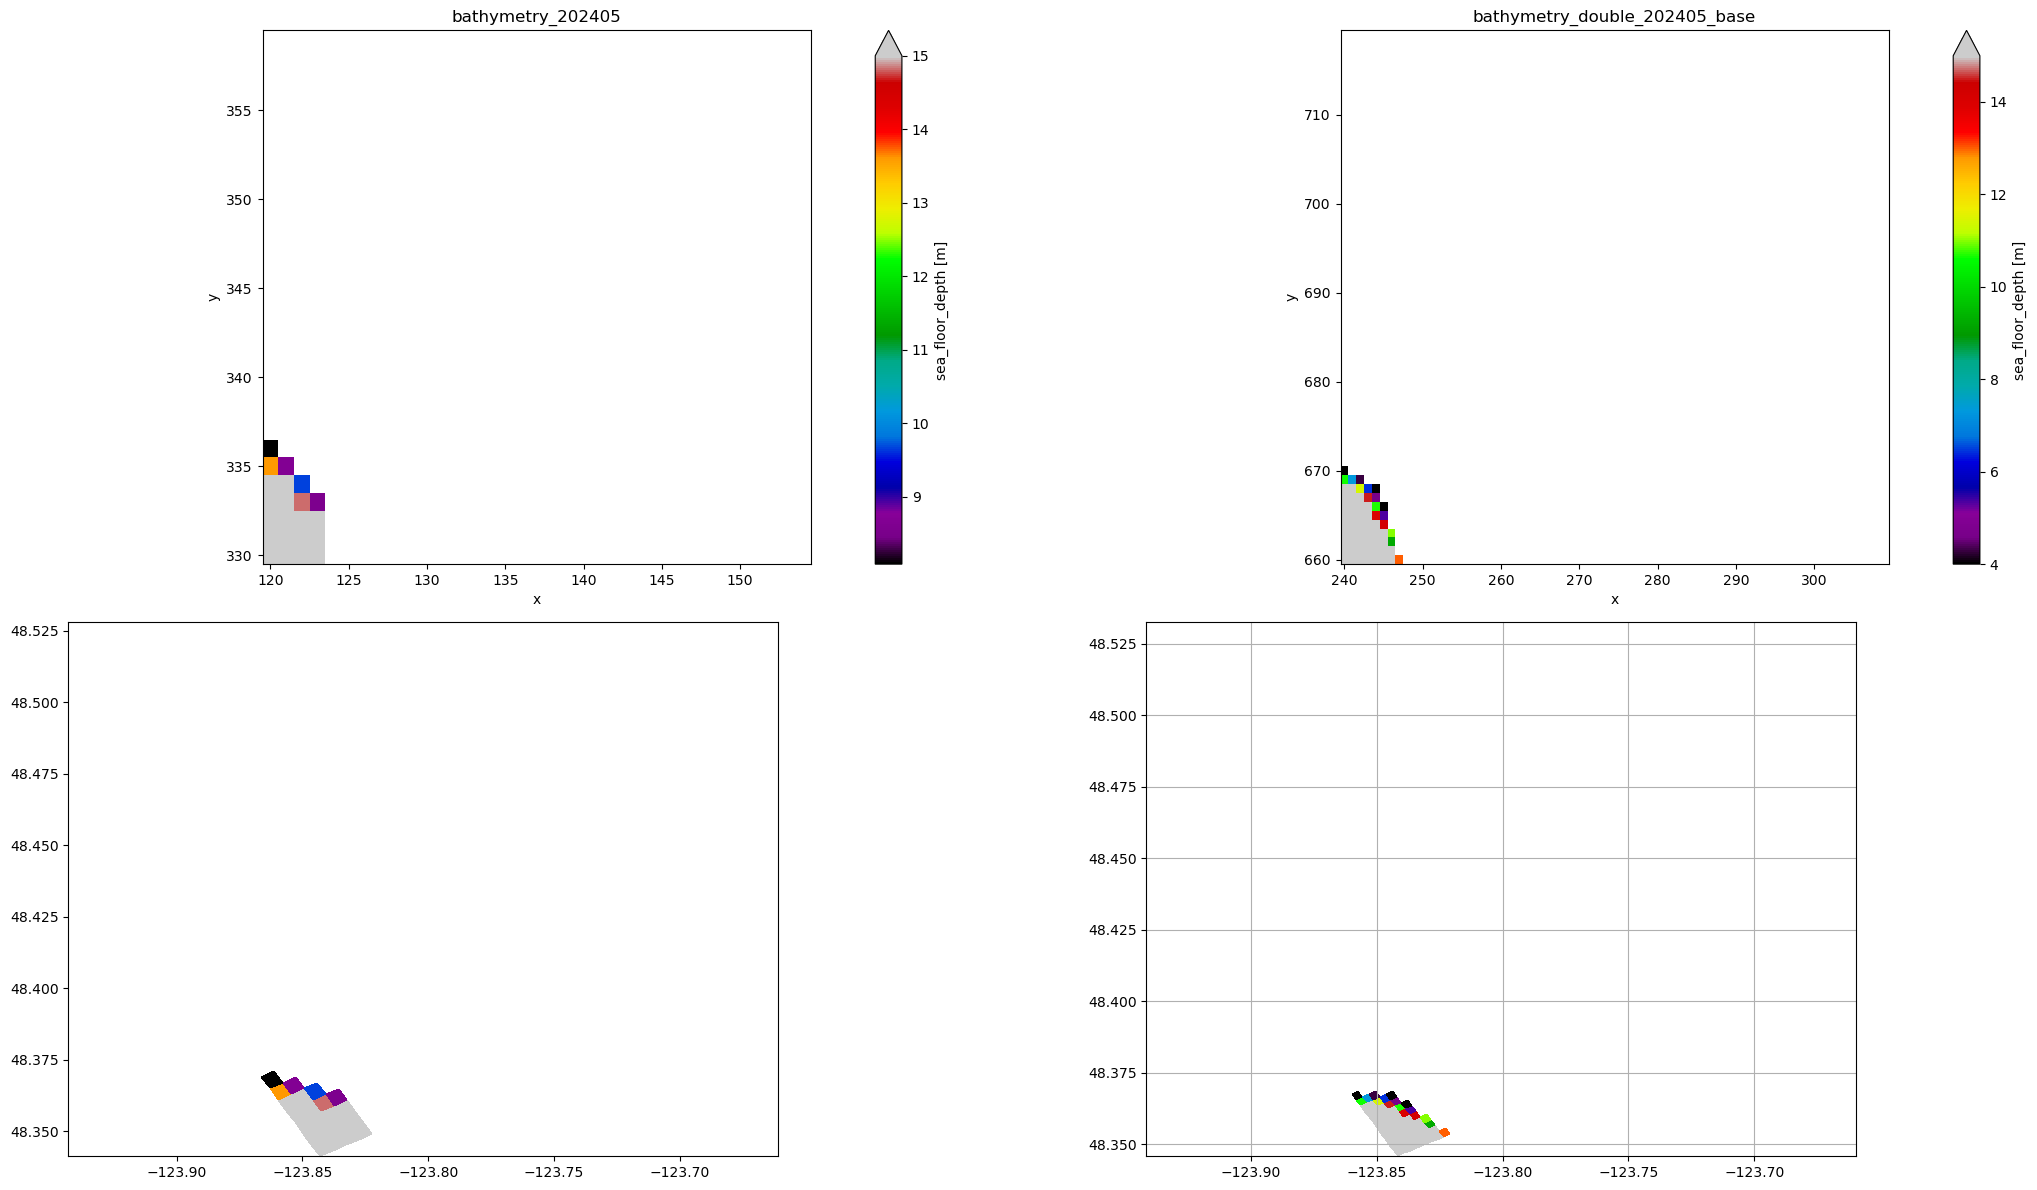

In [38]:
plot_tile(tile_x_min_max[4], y_slices, bathy, dbl_bathy_base)

### Tile 6, 5

* all land

### Tile 6, 6 - Saanich Inlet

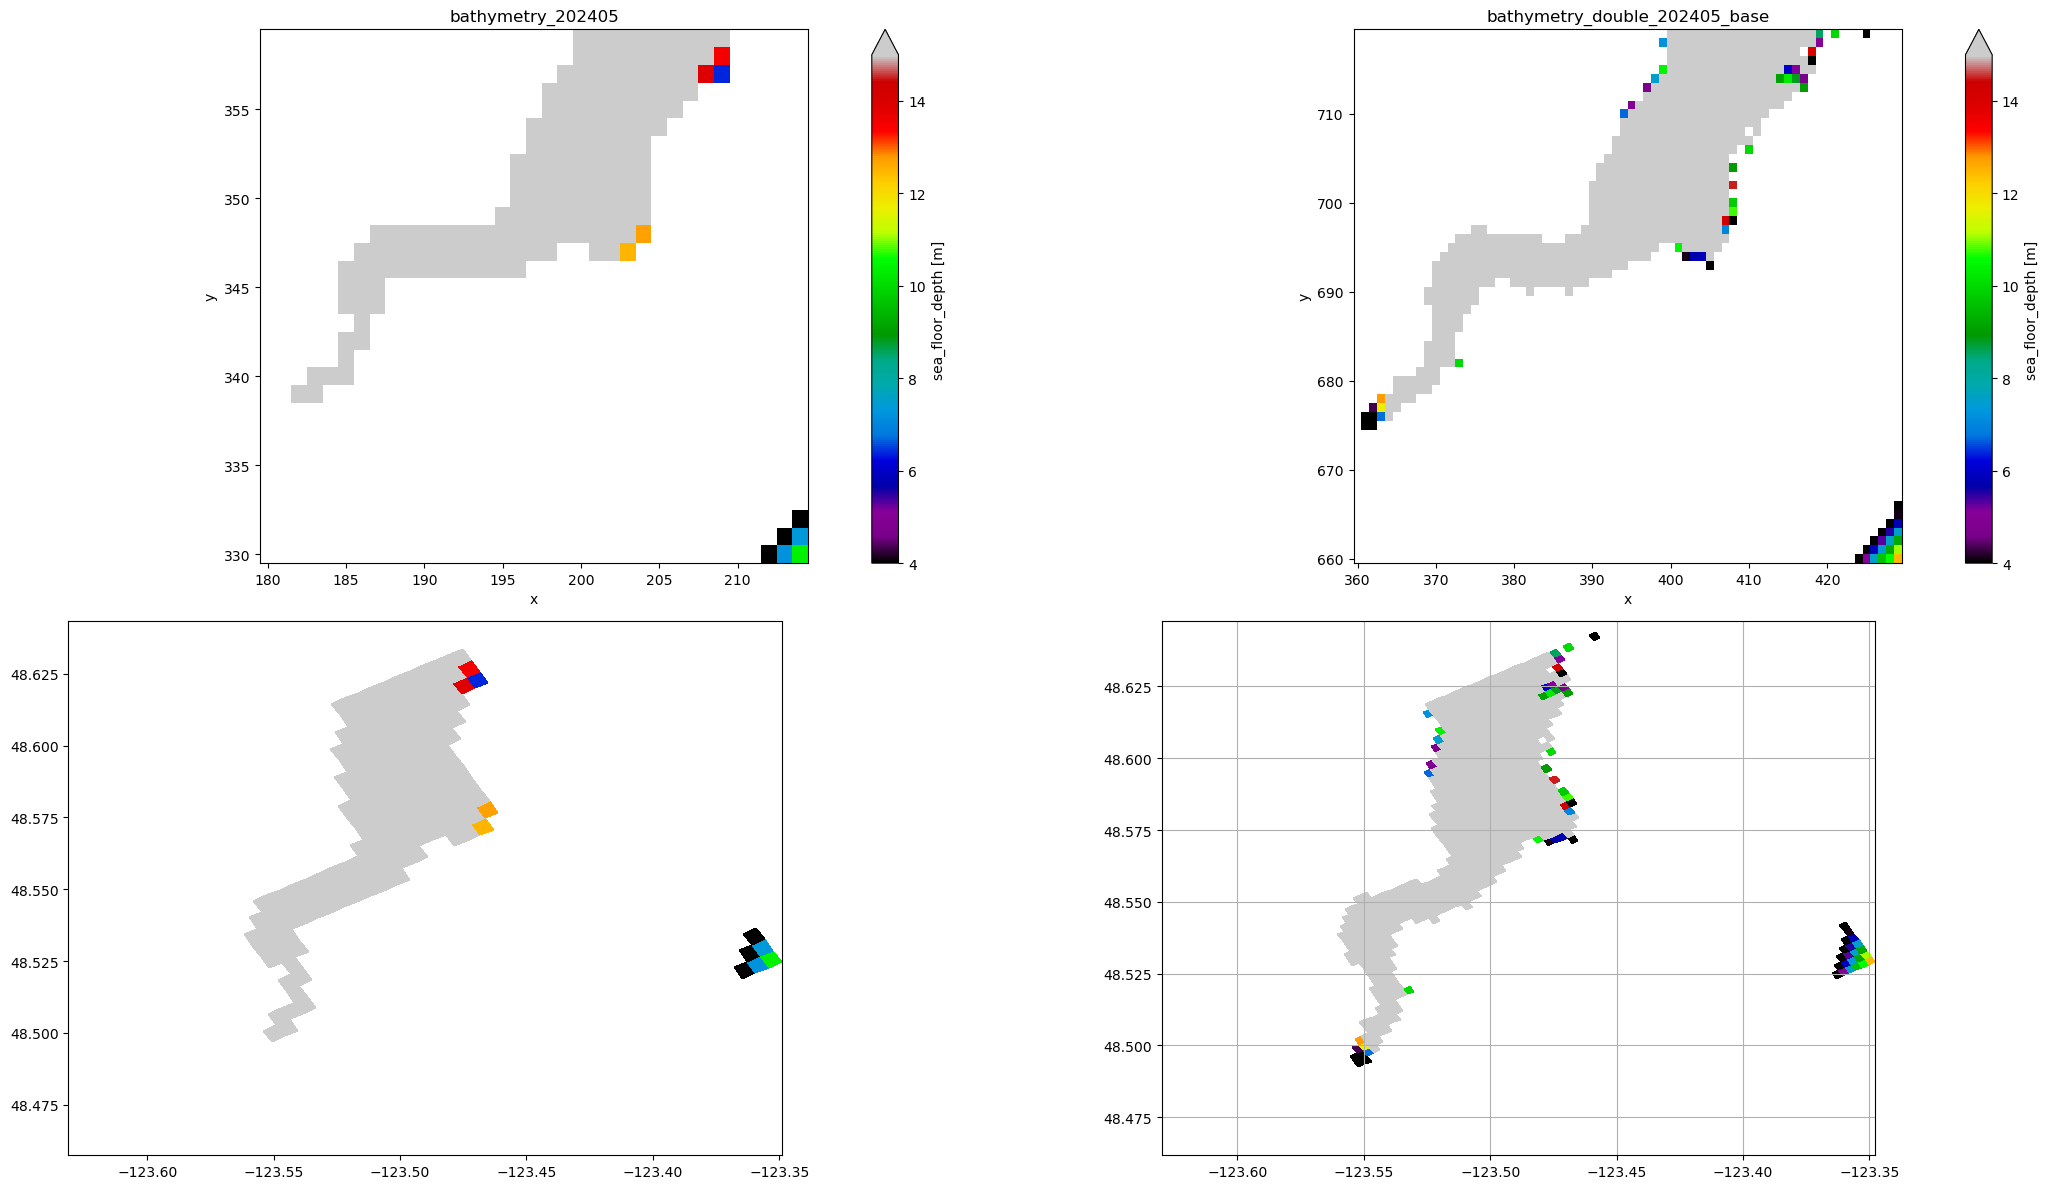

In [39]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base)

### Tile 6, 7 - James Island & Sidney Island

* connect spit on north end of Sidney Island
* connect Gooch Island
* Surface Forrest, Demville & Brethour Islands

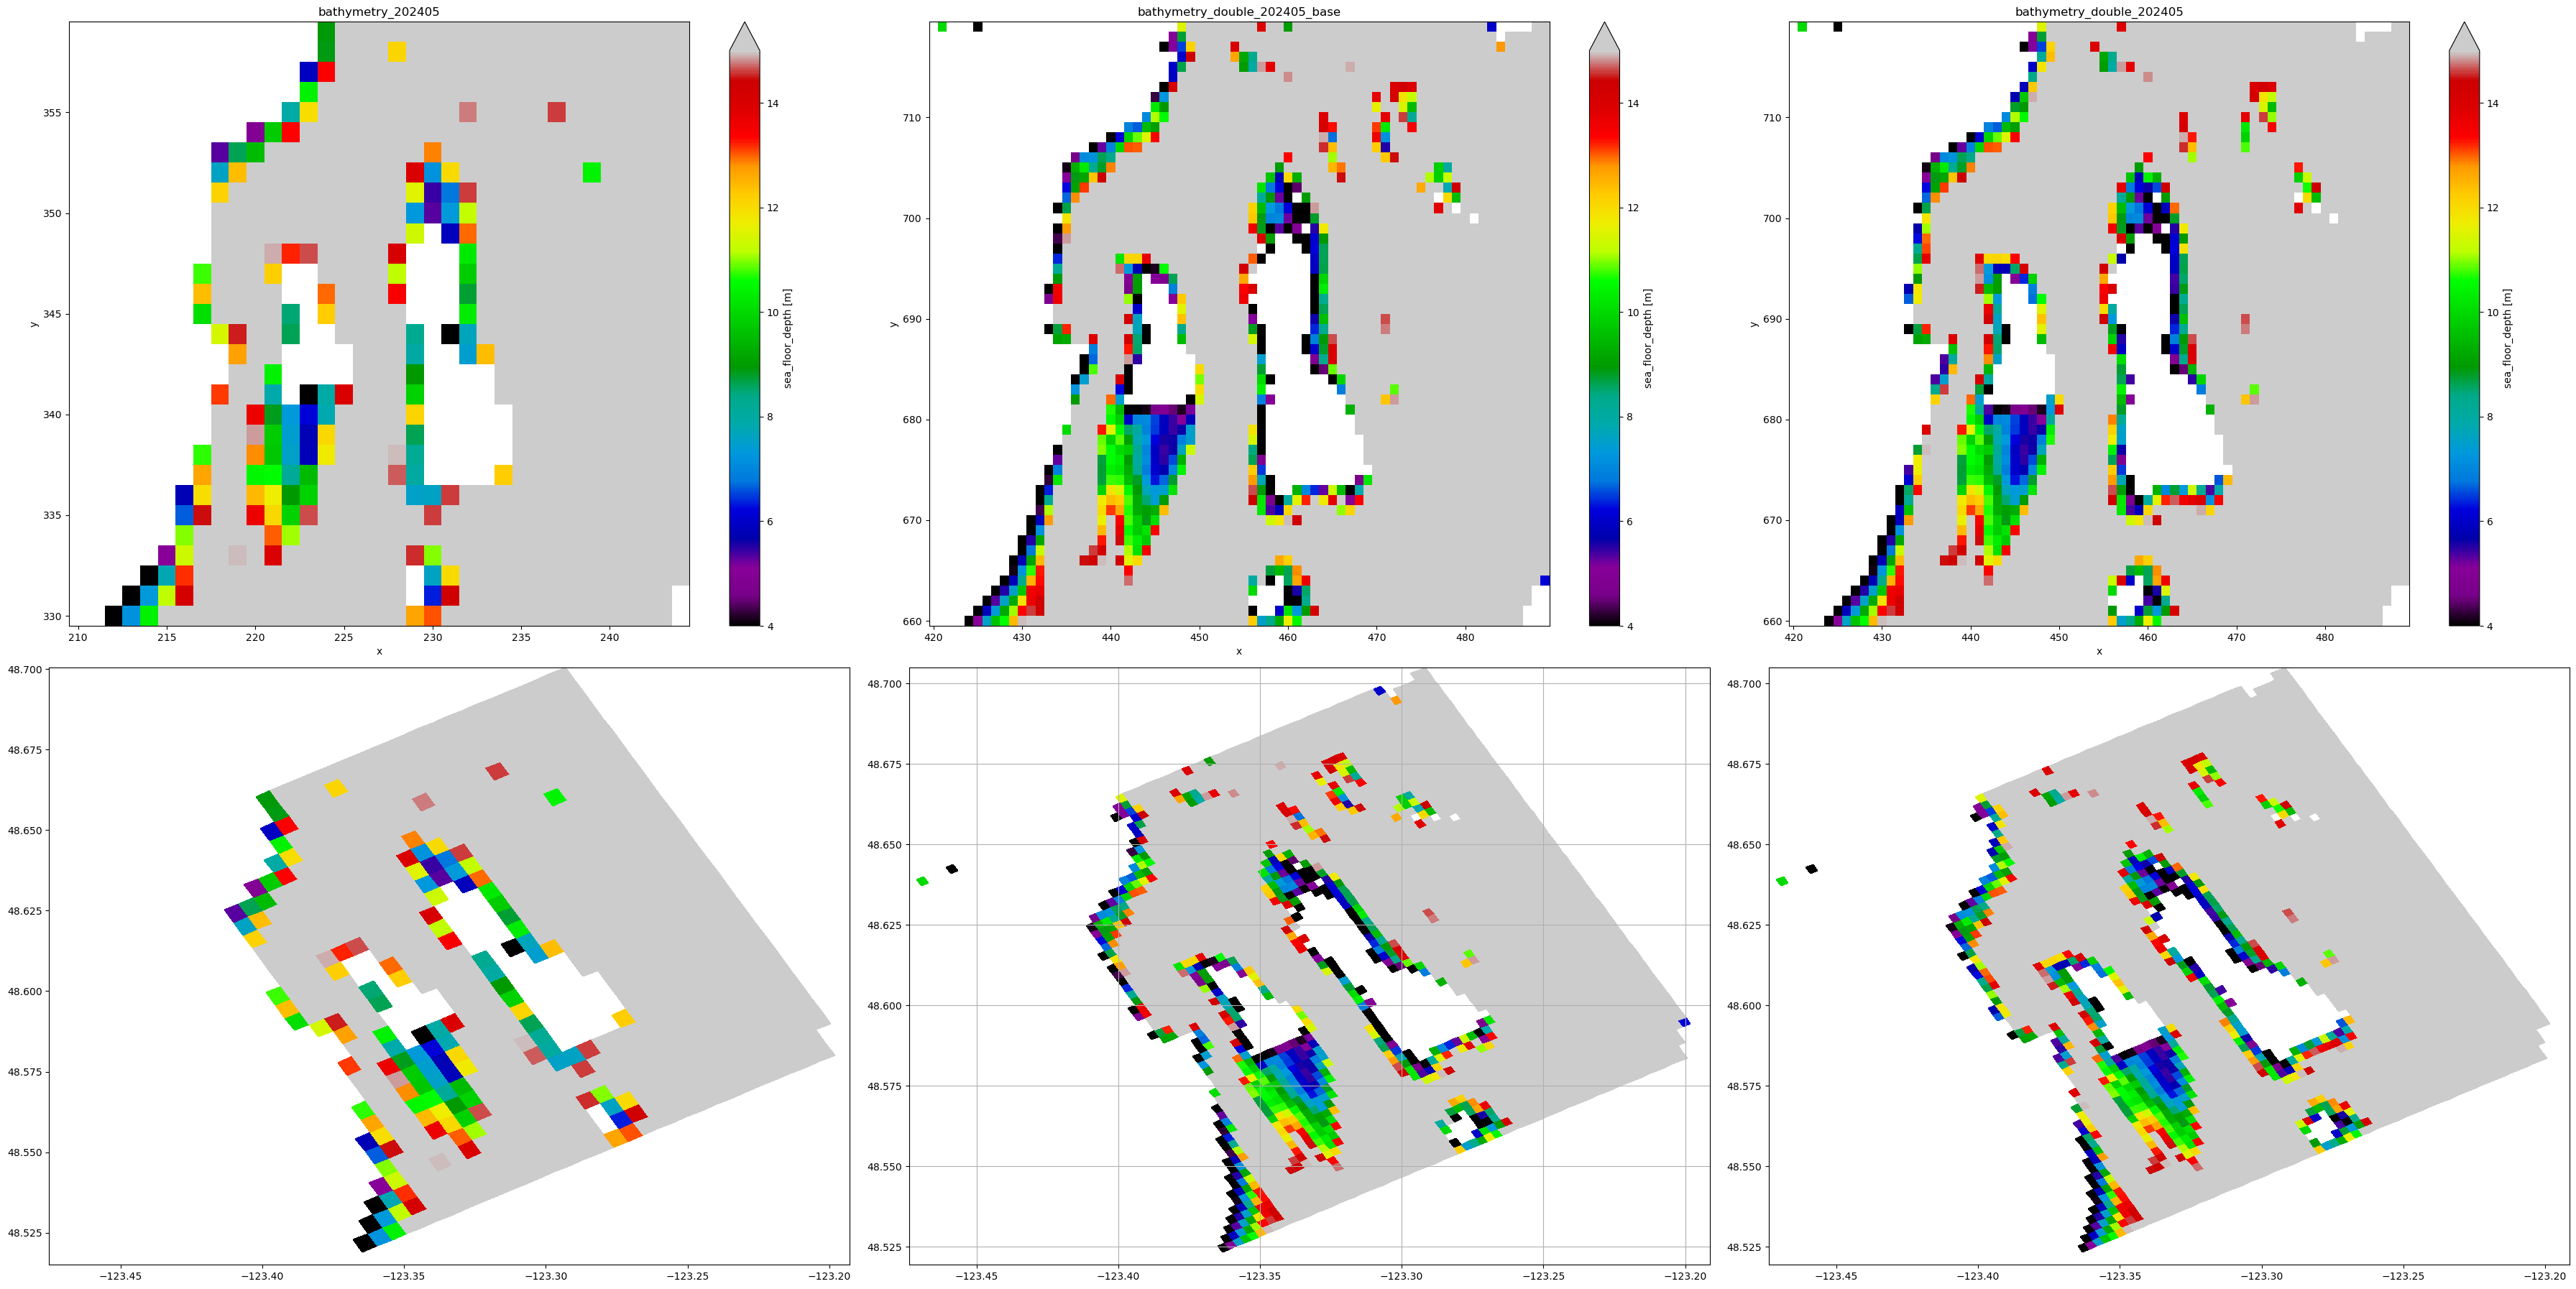

In [40]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 6, 8 - Stuart Island

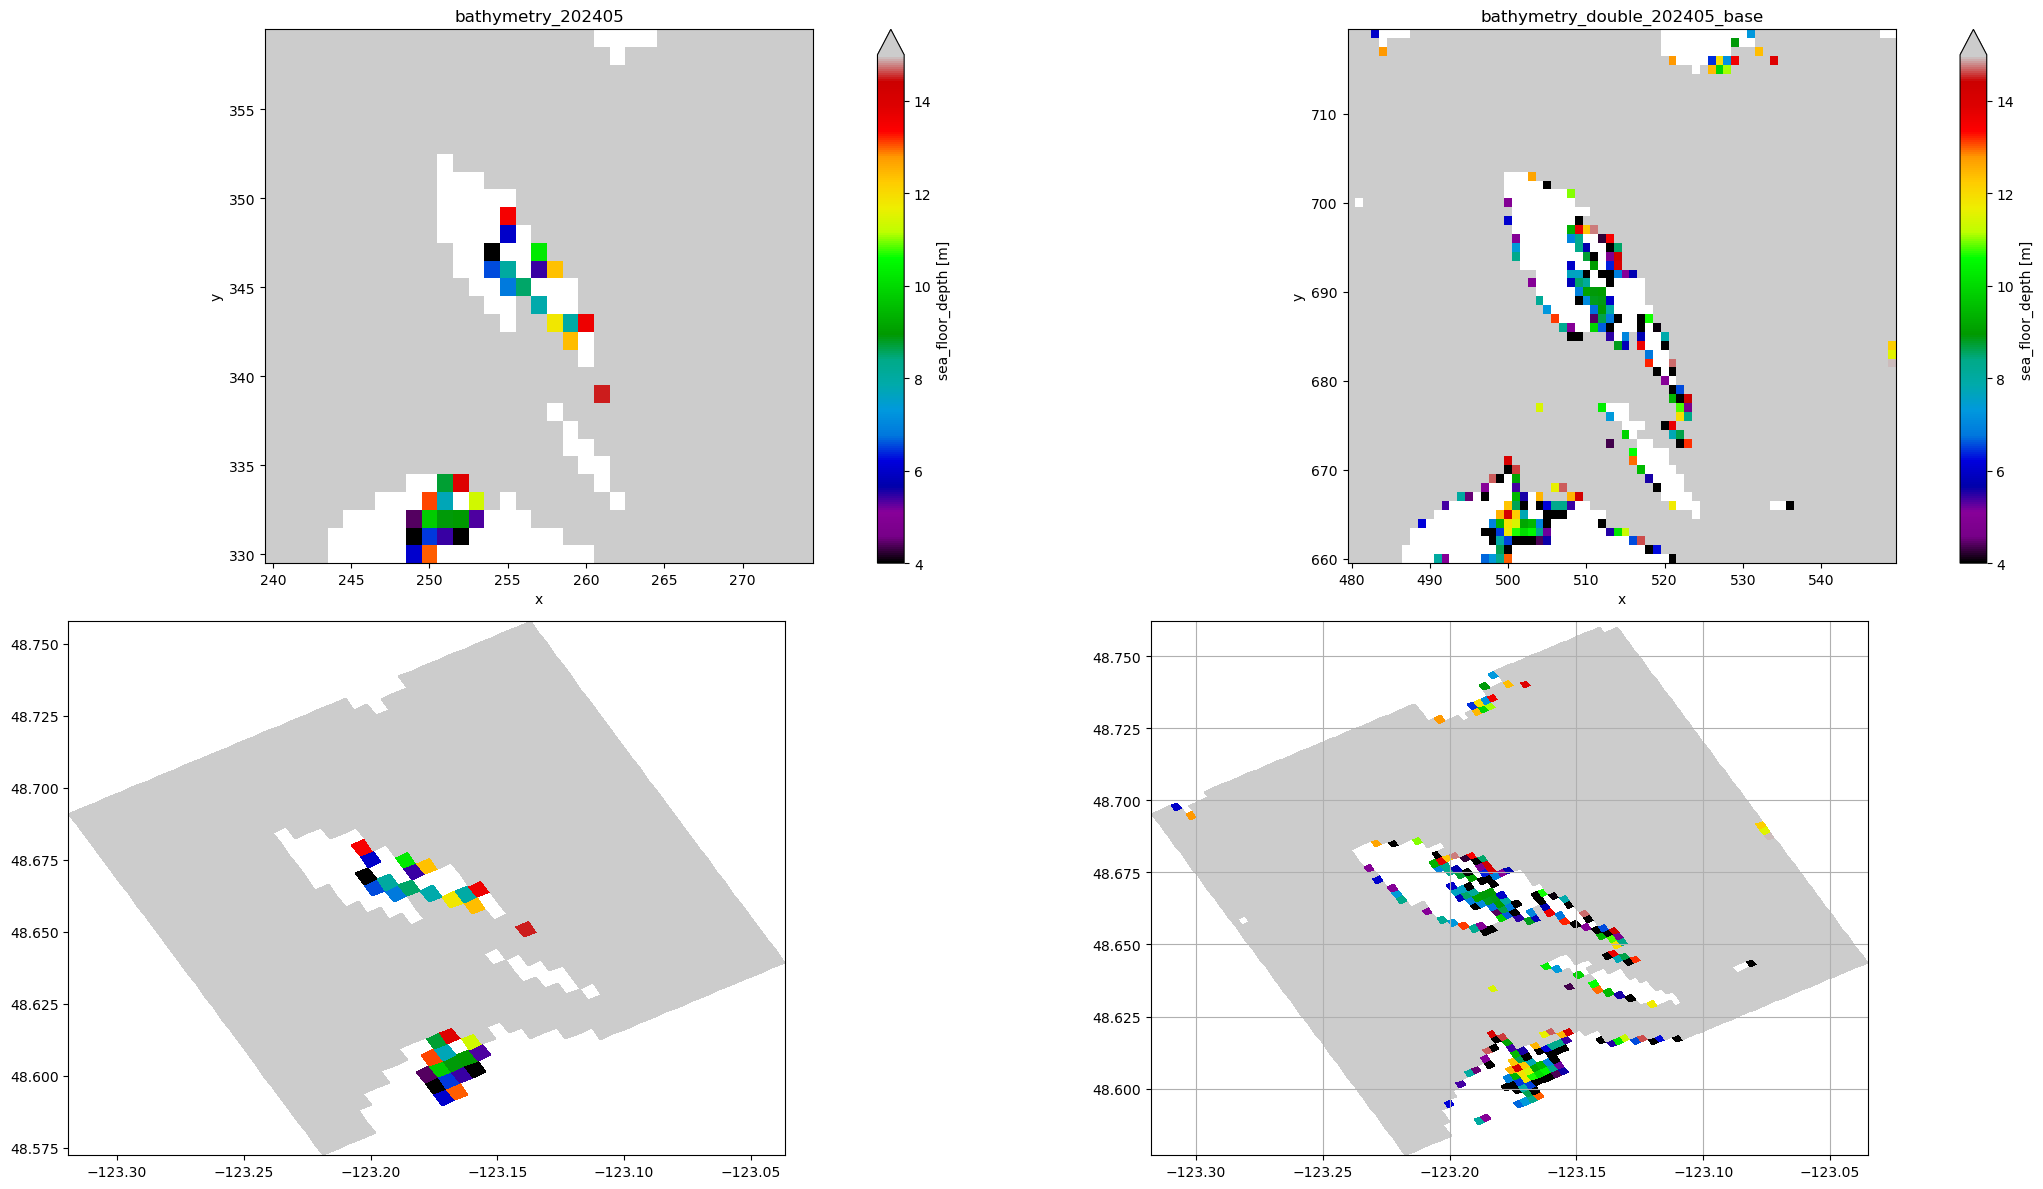

In [41]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base)

### Tile 6, 9 - Waldron Island

* surface Skipjack Island

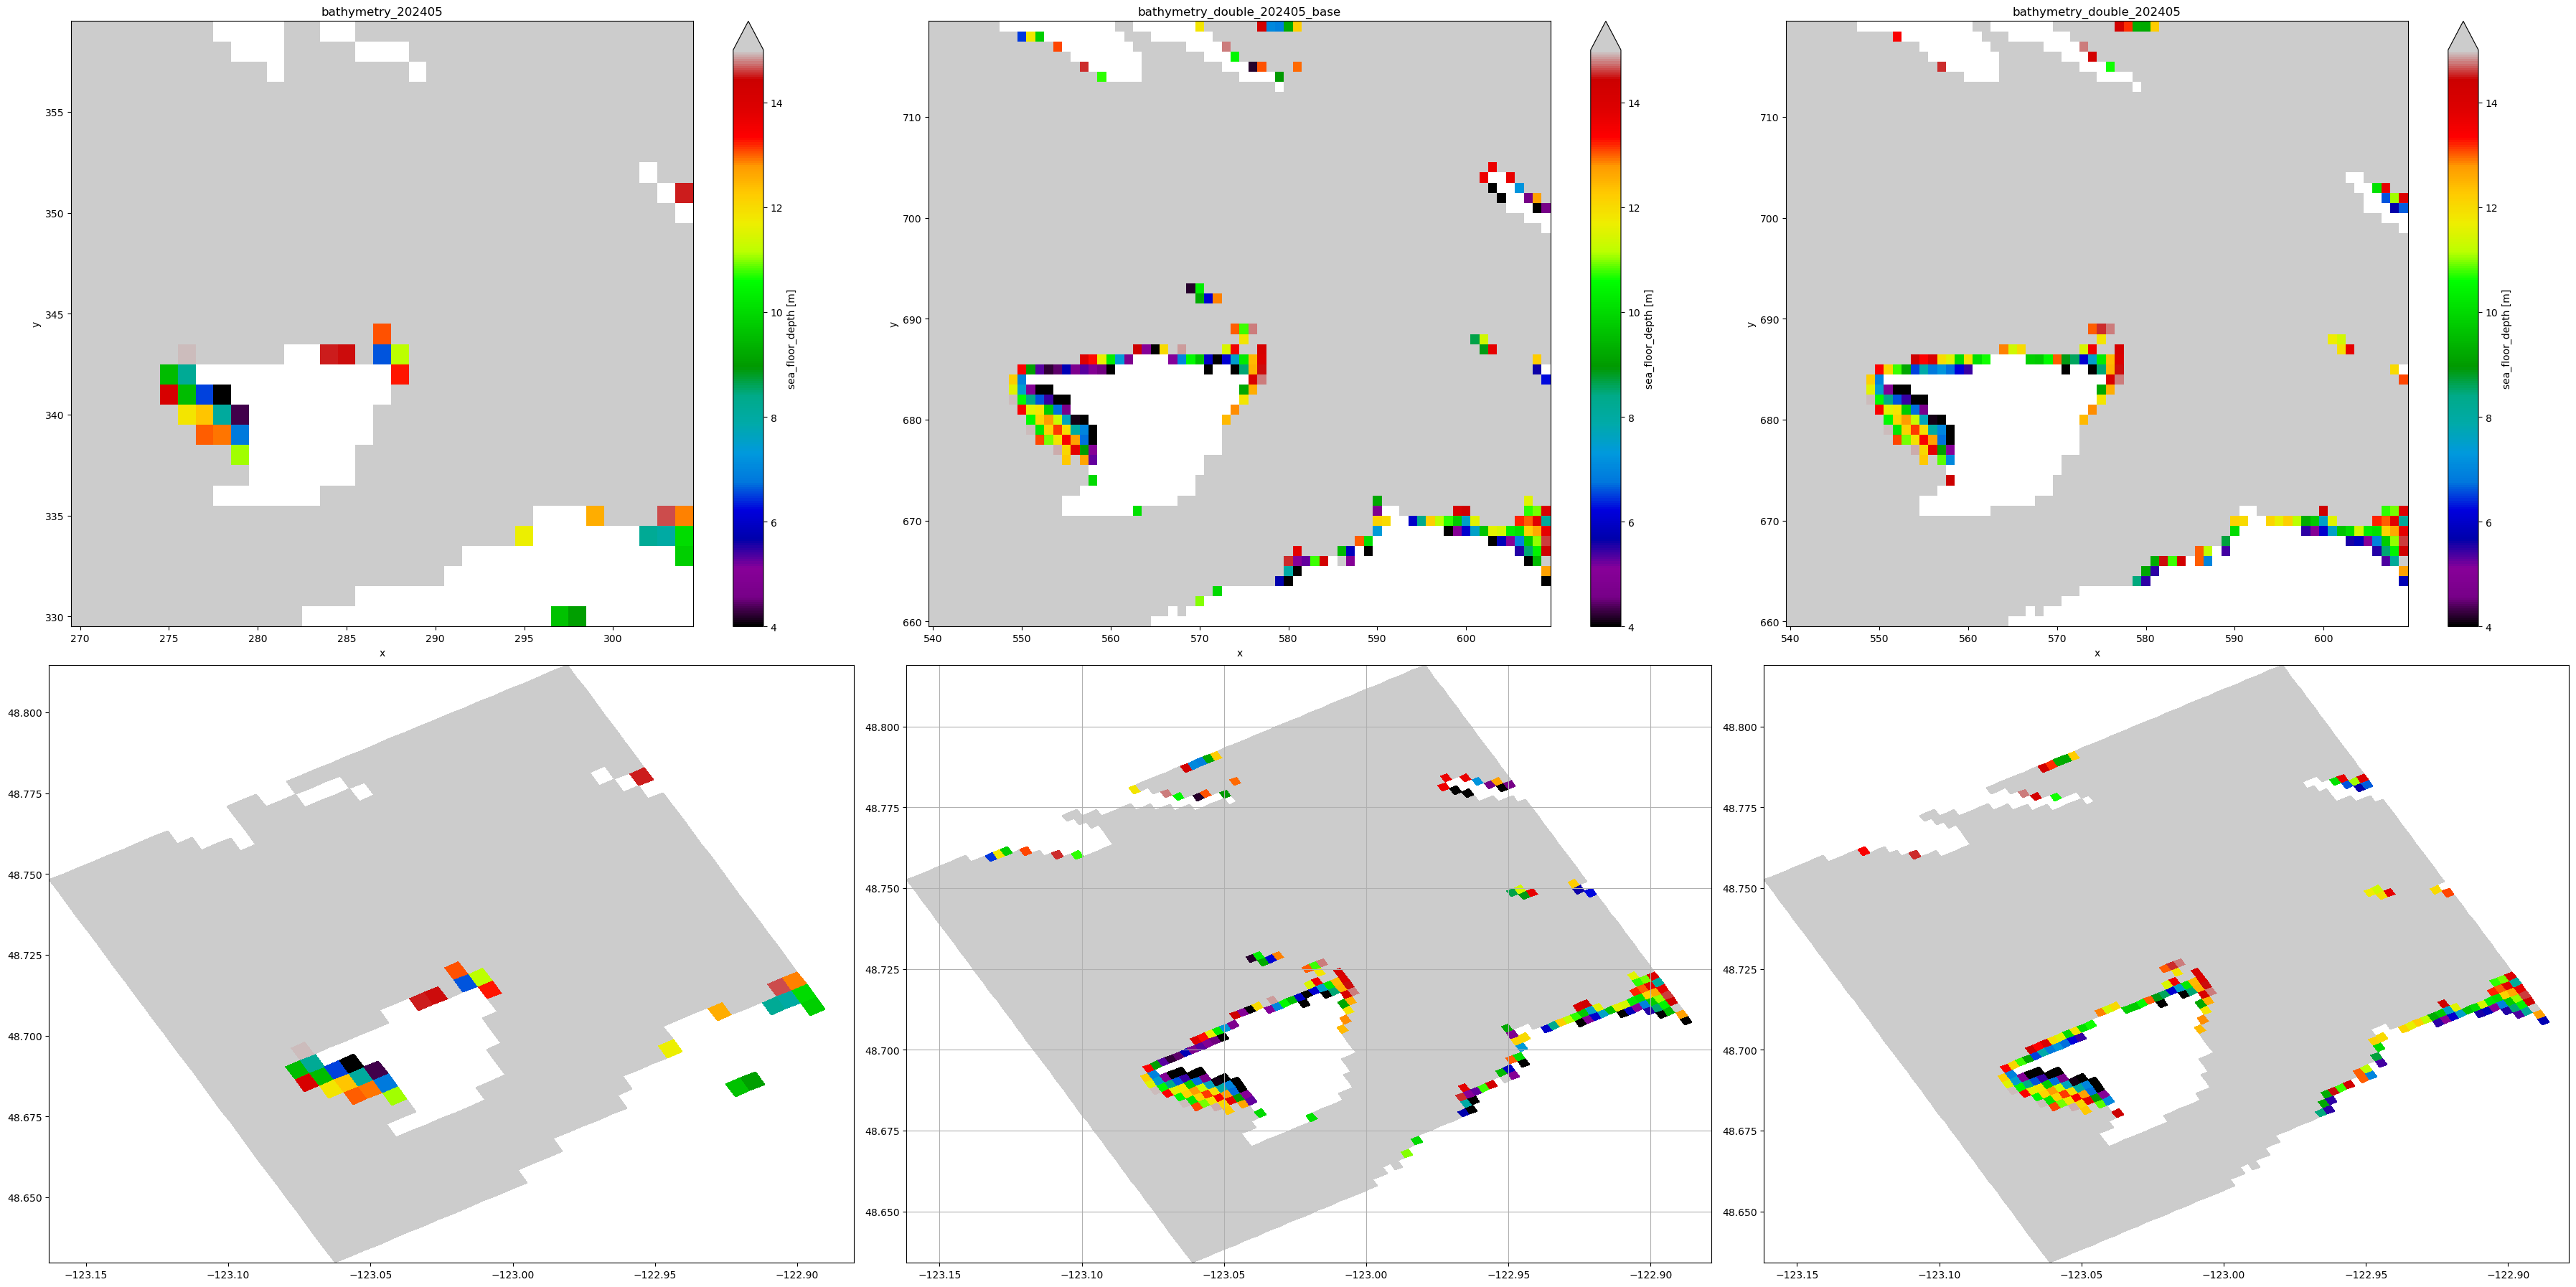

In [42]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 6, 10 - Sucia Islands

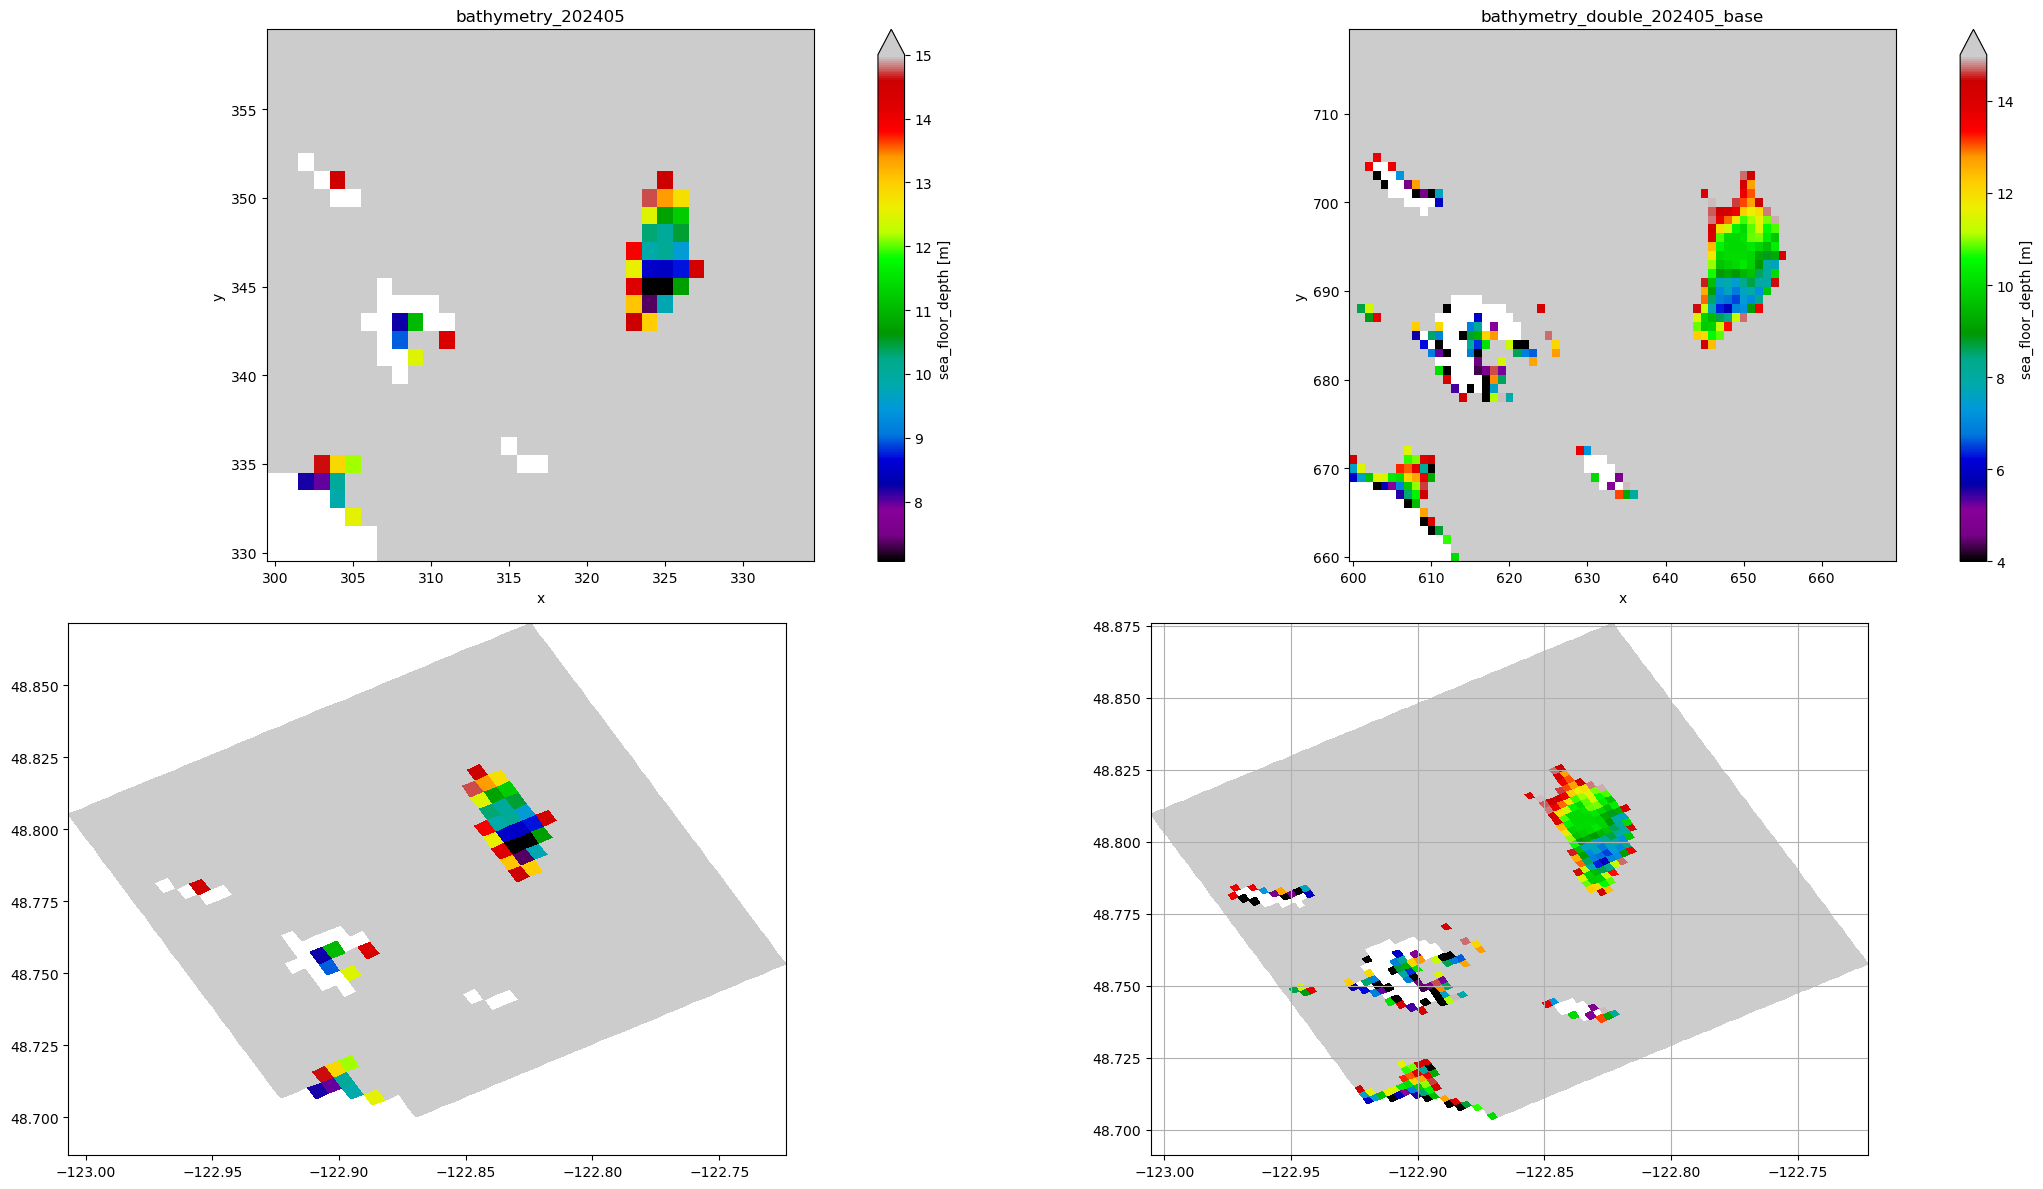

In [43]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base)

### Tile 6, 11 - Neptune Beach

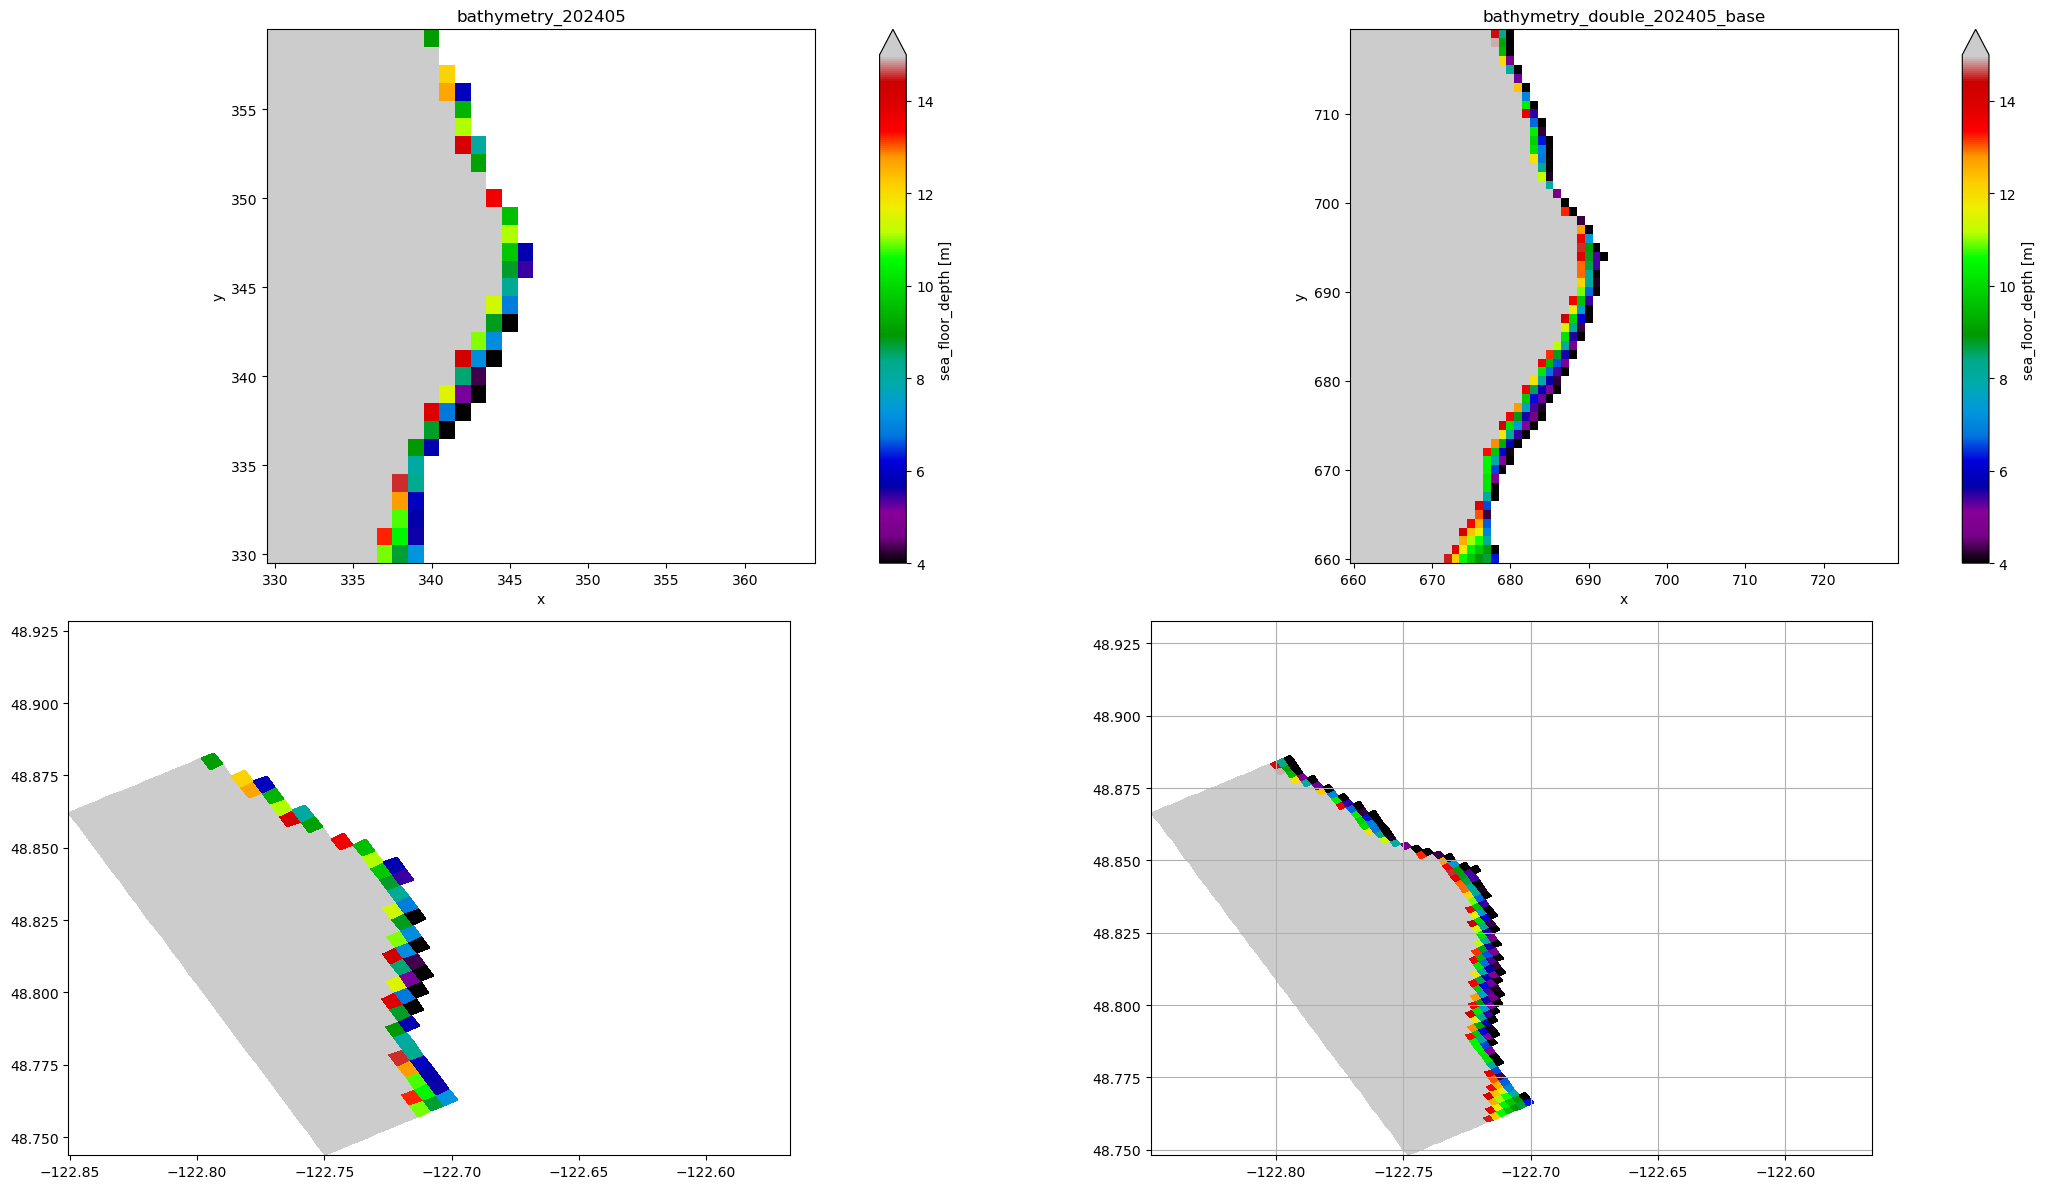

In [44]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base)

### Tile 6, 12

* all land, but also the south end of the Fraser River proxy

## Row 7 - Neah Bay to Semiahmoo Bay

In [45]:
y_min_max = numpy.array([360, 390])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 7, 0 - Neah Bay to Sekiu River

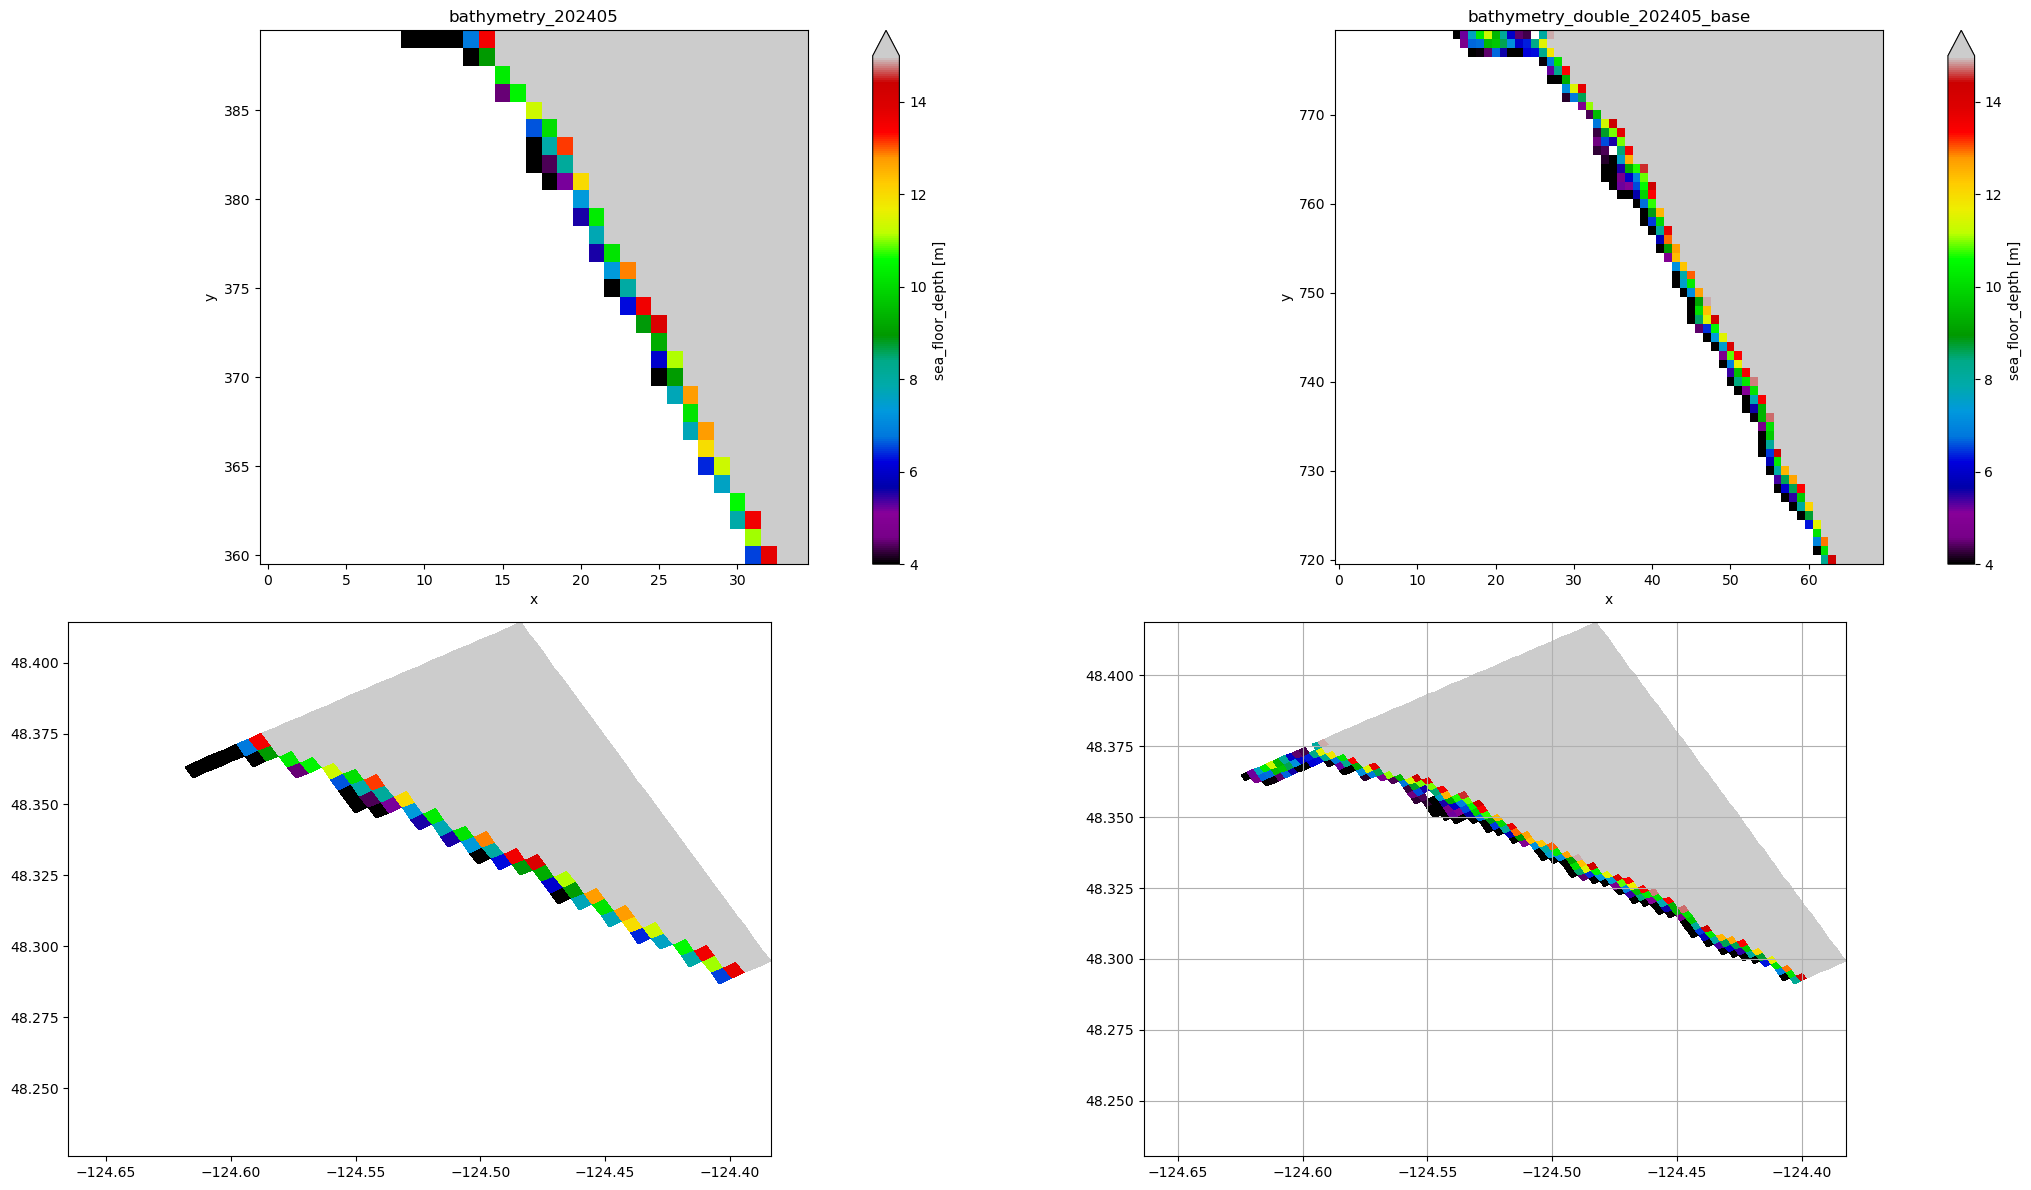

In [46]:
plot_tile(tile_x_min_max[0], y_slices, bathy, dbl_bathy_base)

### Tile 7, 1

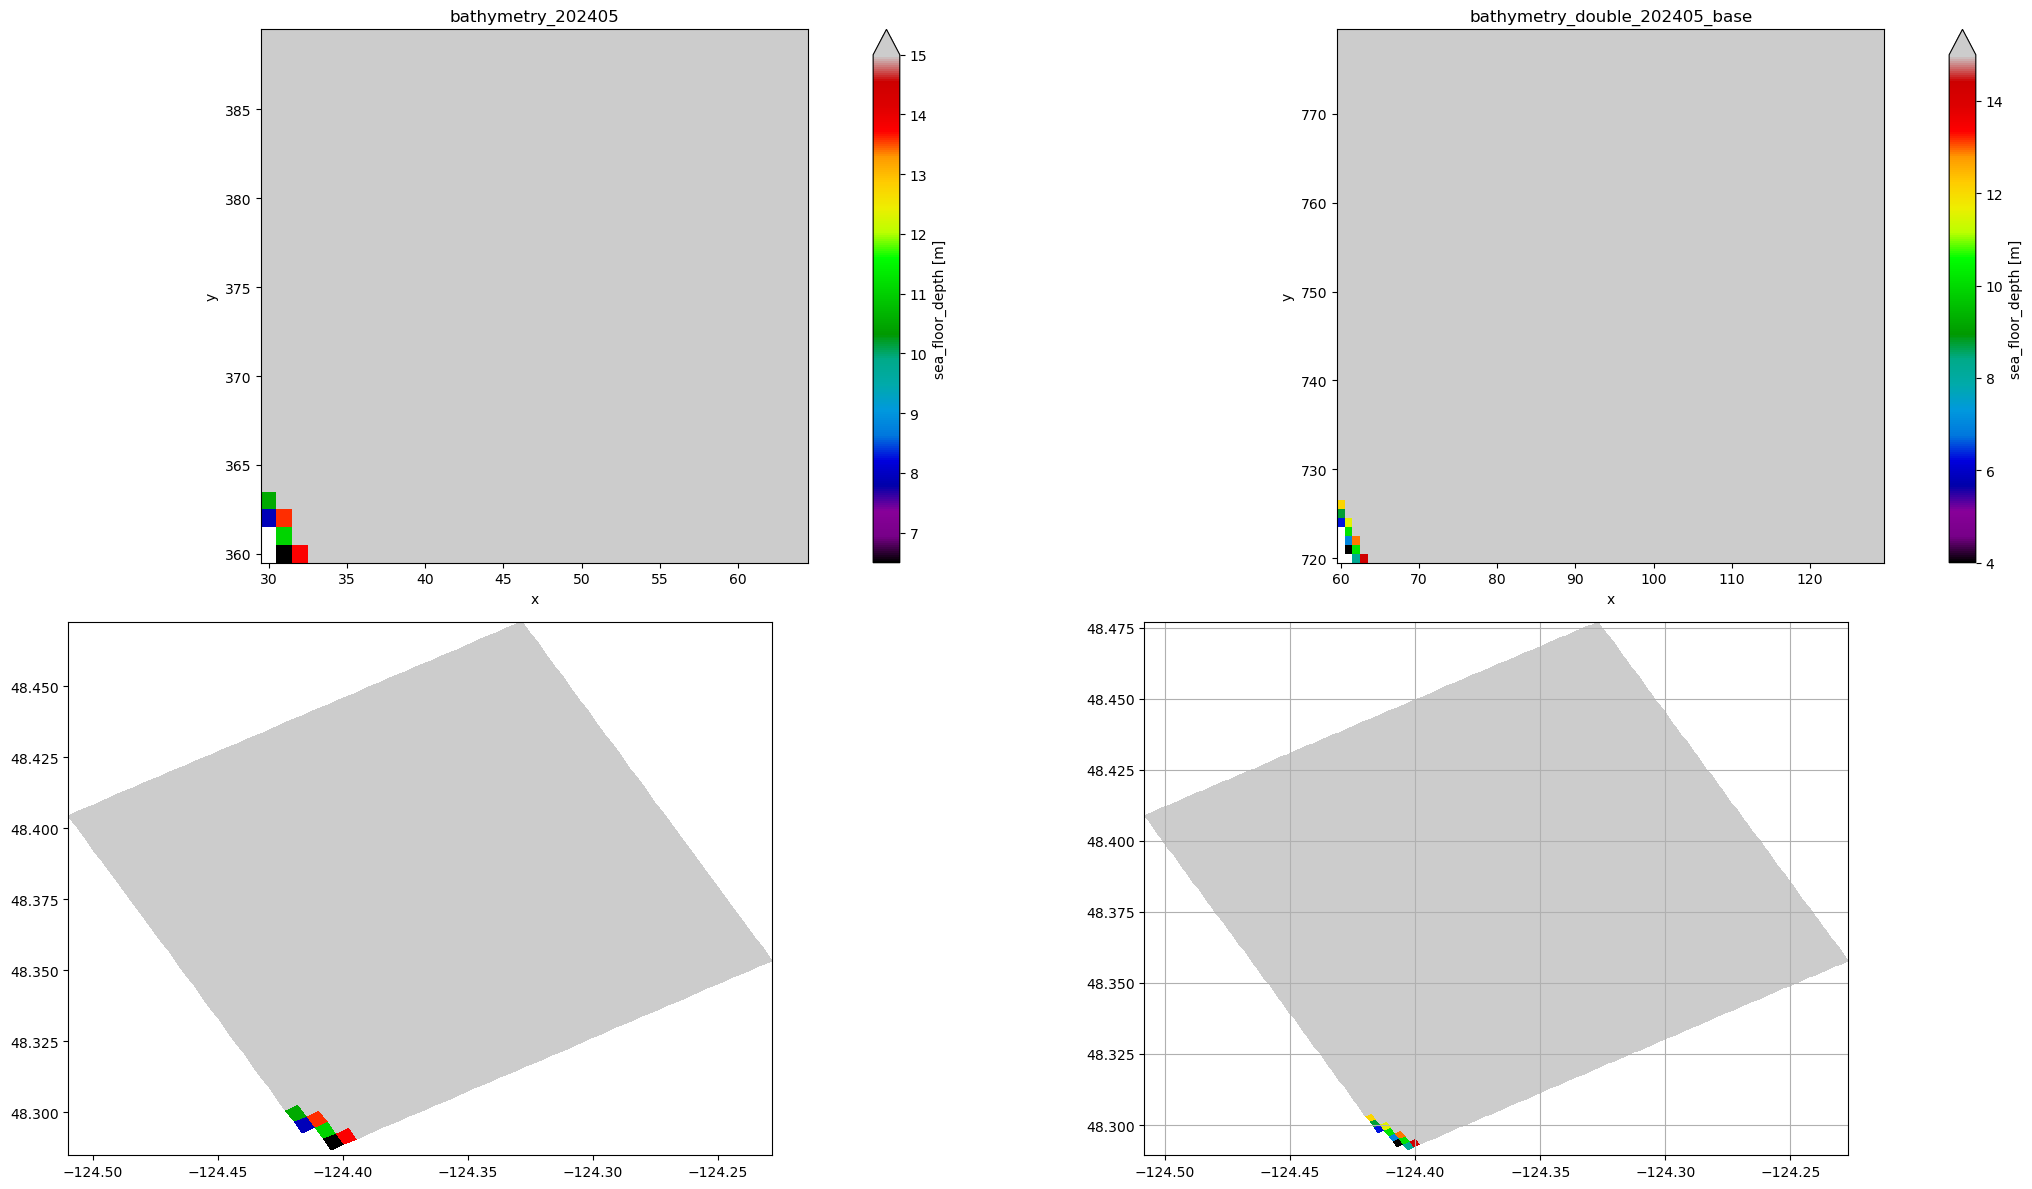

In [47]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 7, 2 - Sombrio Beach to China Beach

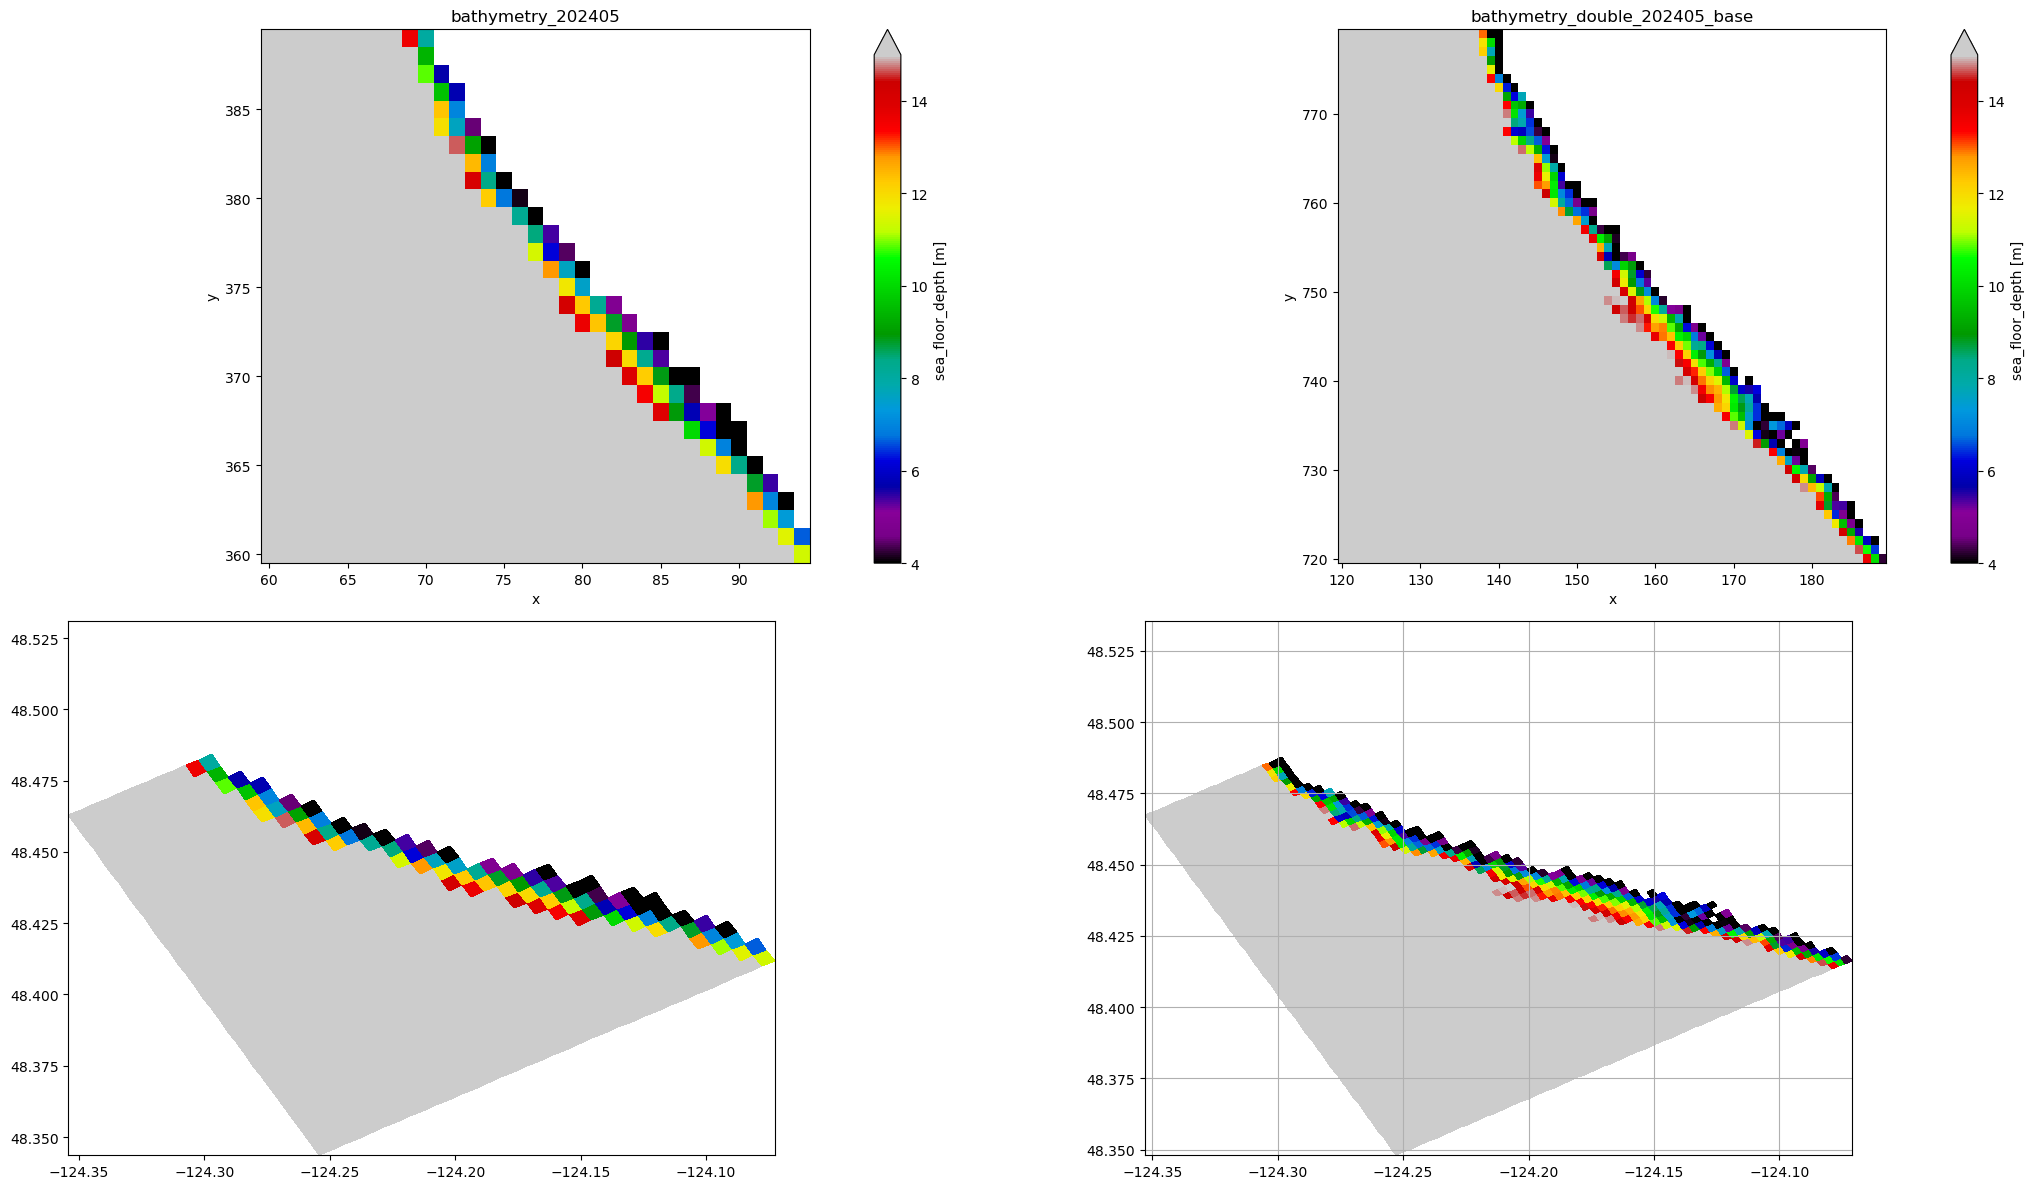

In [48]:
plot_tile(tile_x_min_max[2], y_slices, bathy, dbl_bathy_base)

### Tile 7, 3

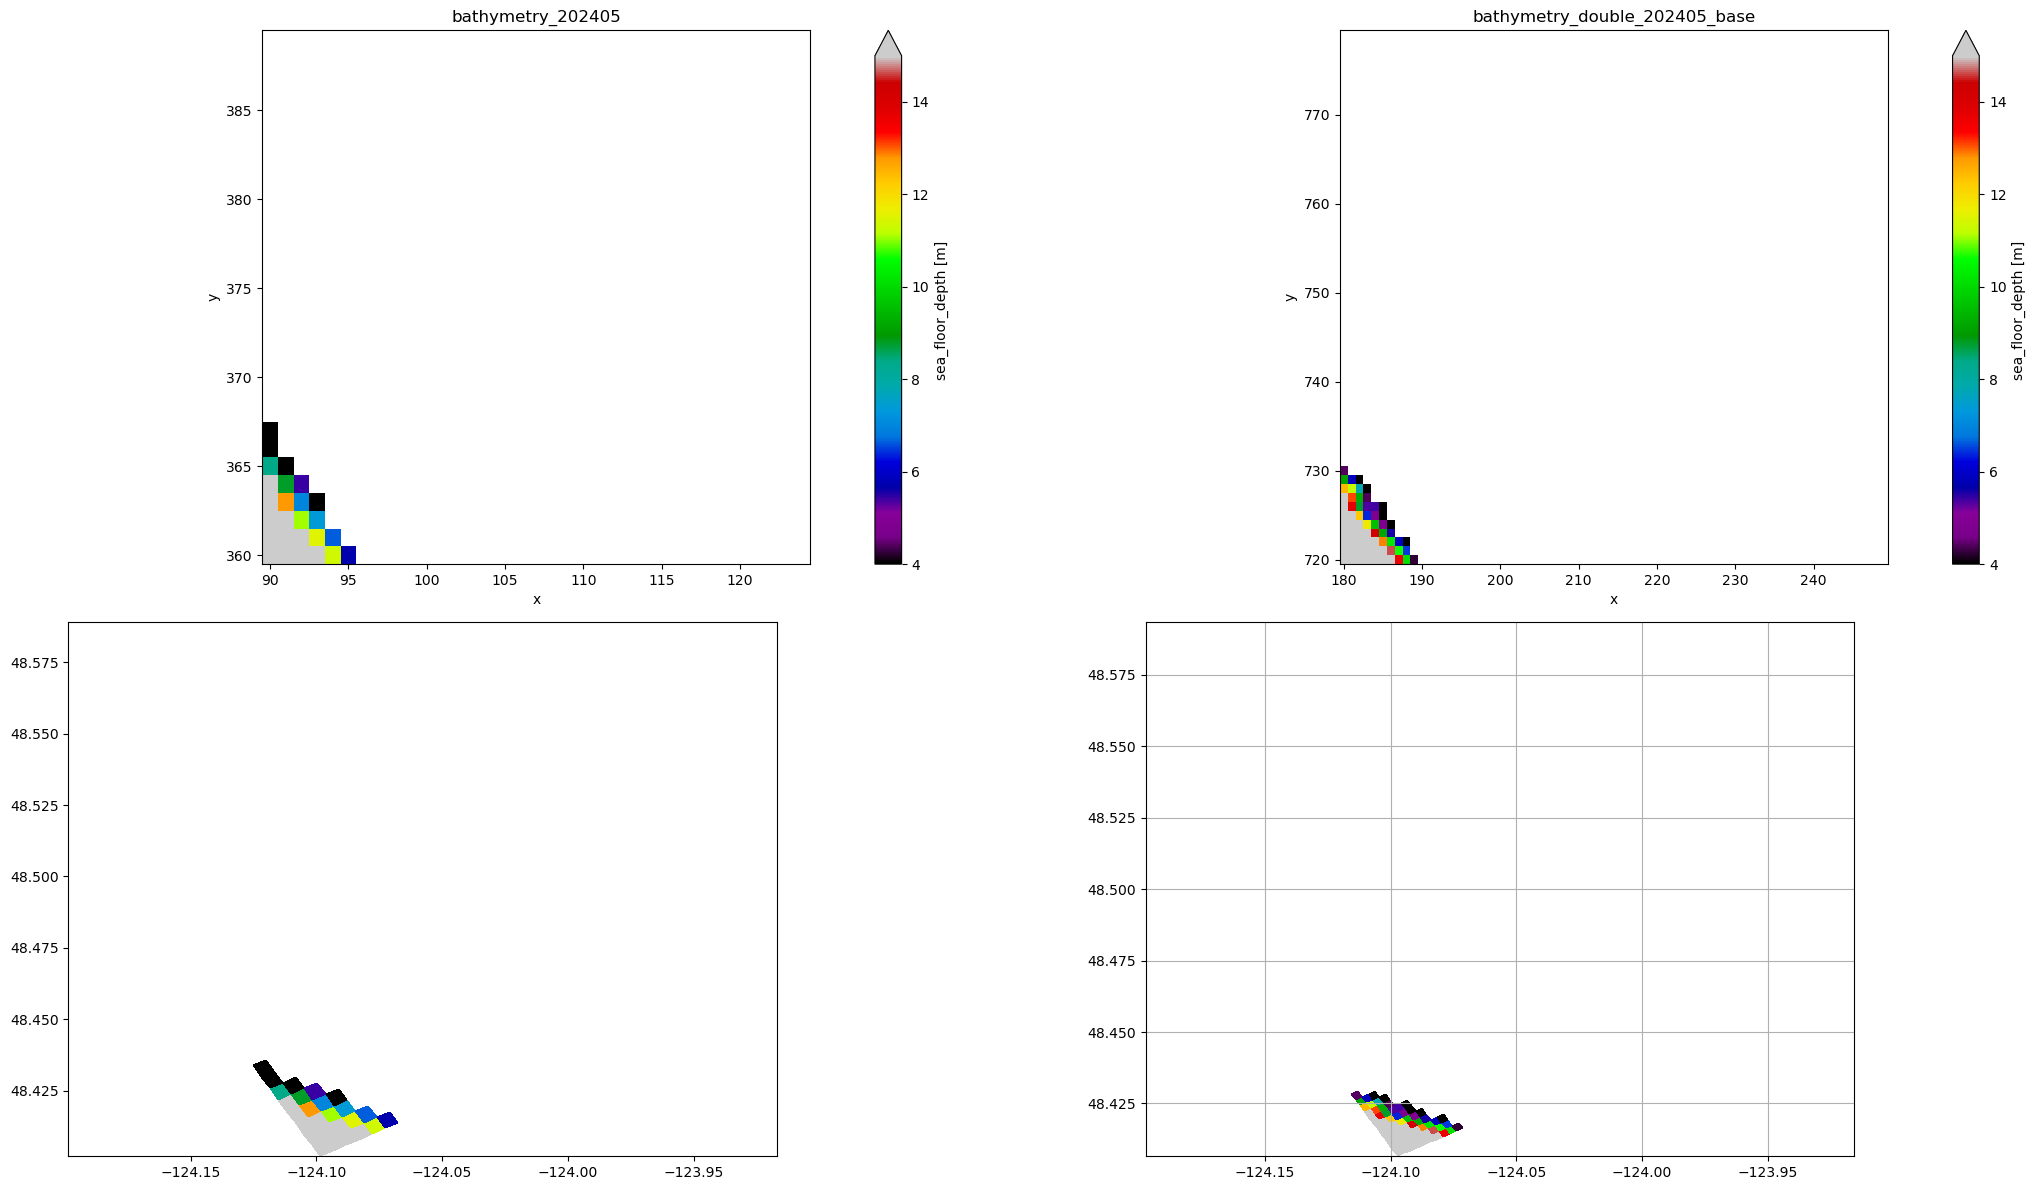

In [49]:
plot_tile(tile_x_min_max[3], y_slices, bathy, dbl_bathy_base)

### Tile 7, 4

* all land

### Tile 7, 5

* all land

### Tile 7, 6 - North Saanish Inlet (Mill Bay to Genoa Bay

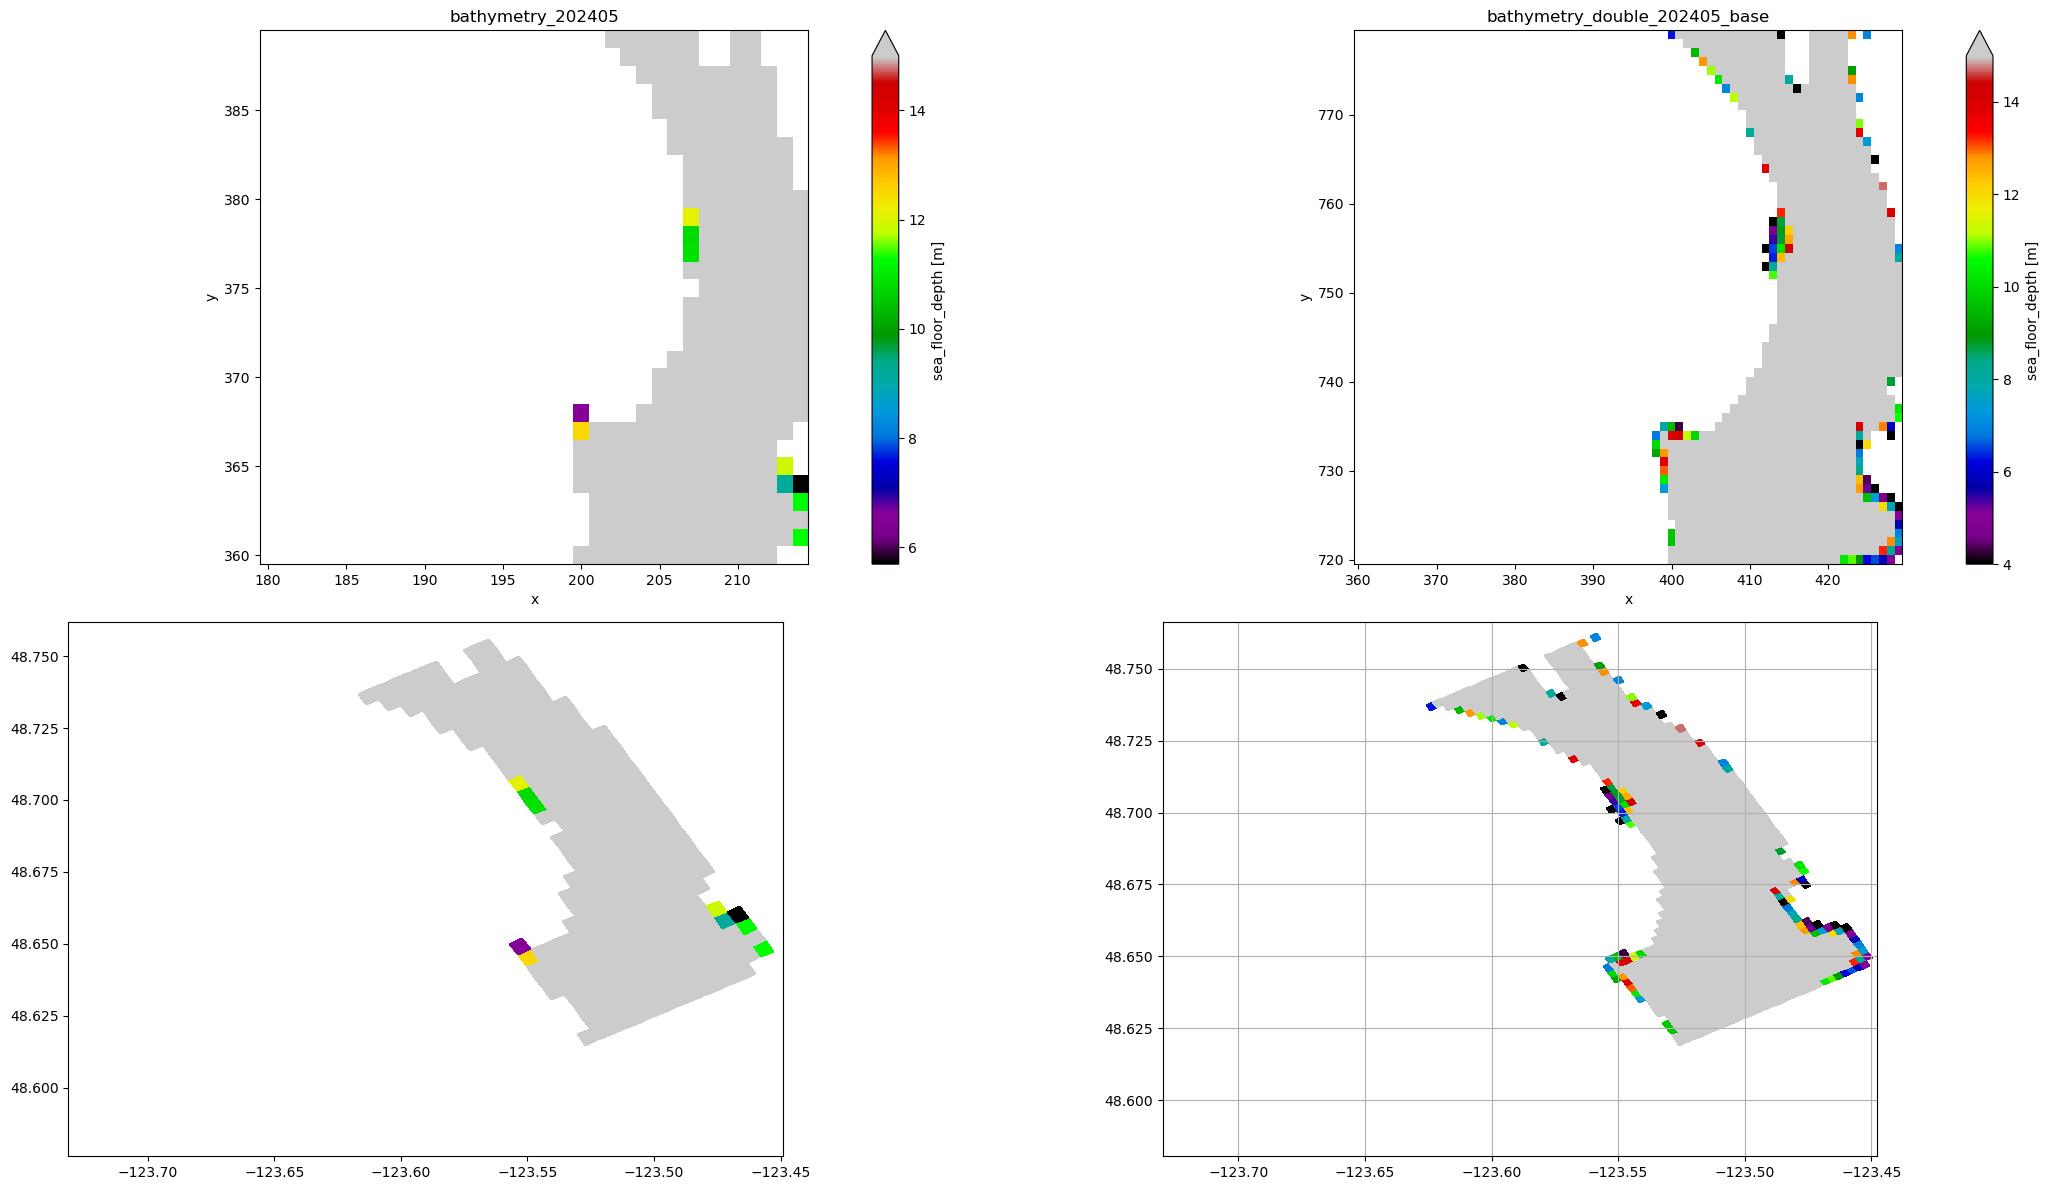

In [50]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base)

### Tile 7, 7 - Fulford Harbour

* surface Piers Island, Knapp Island & Pym Island

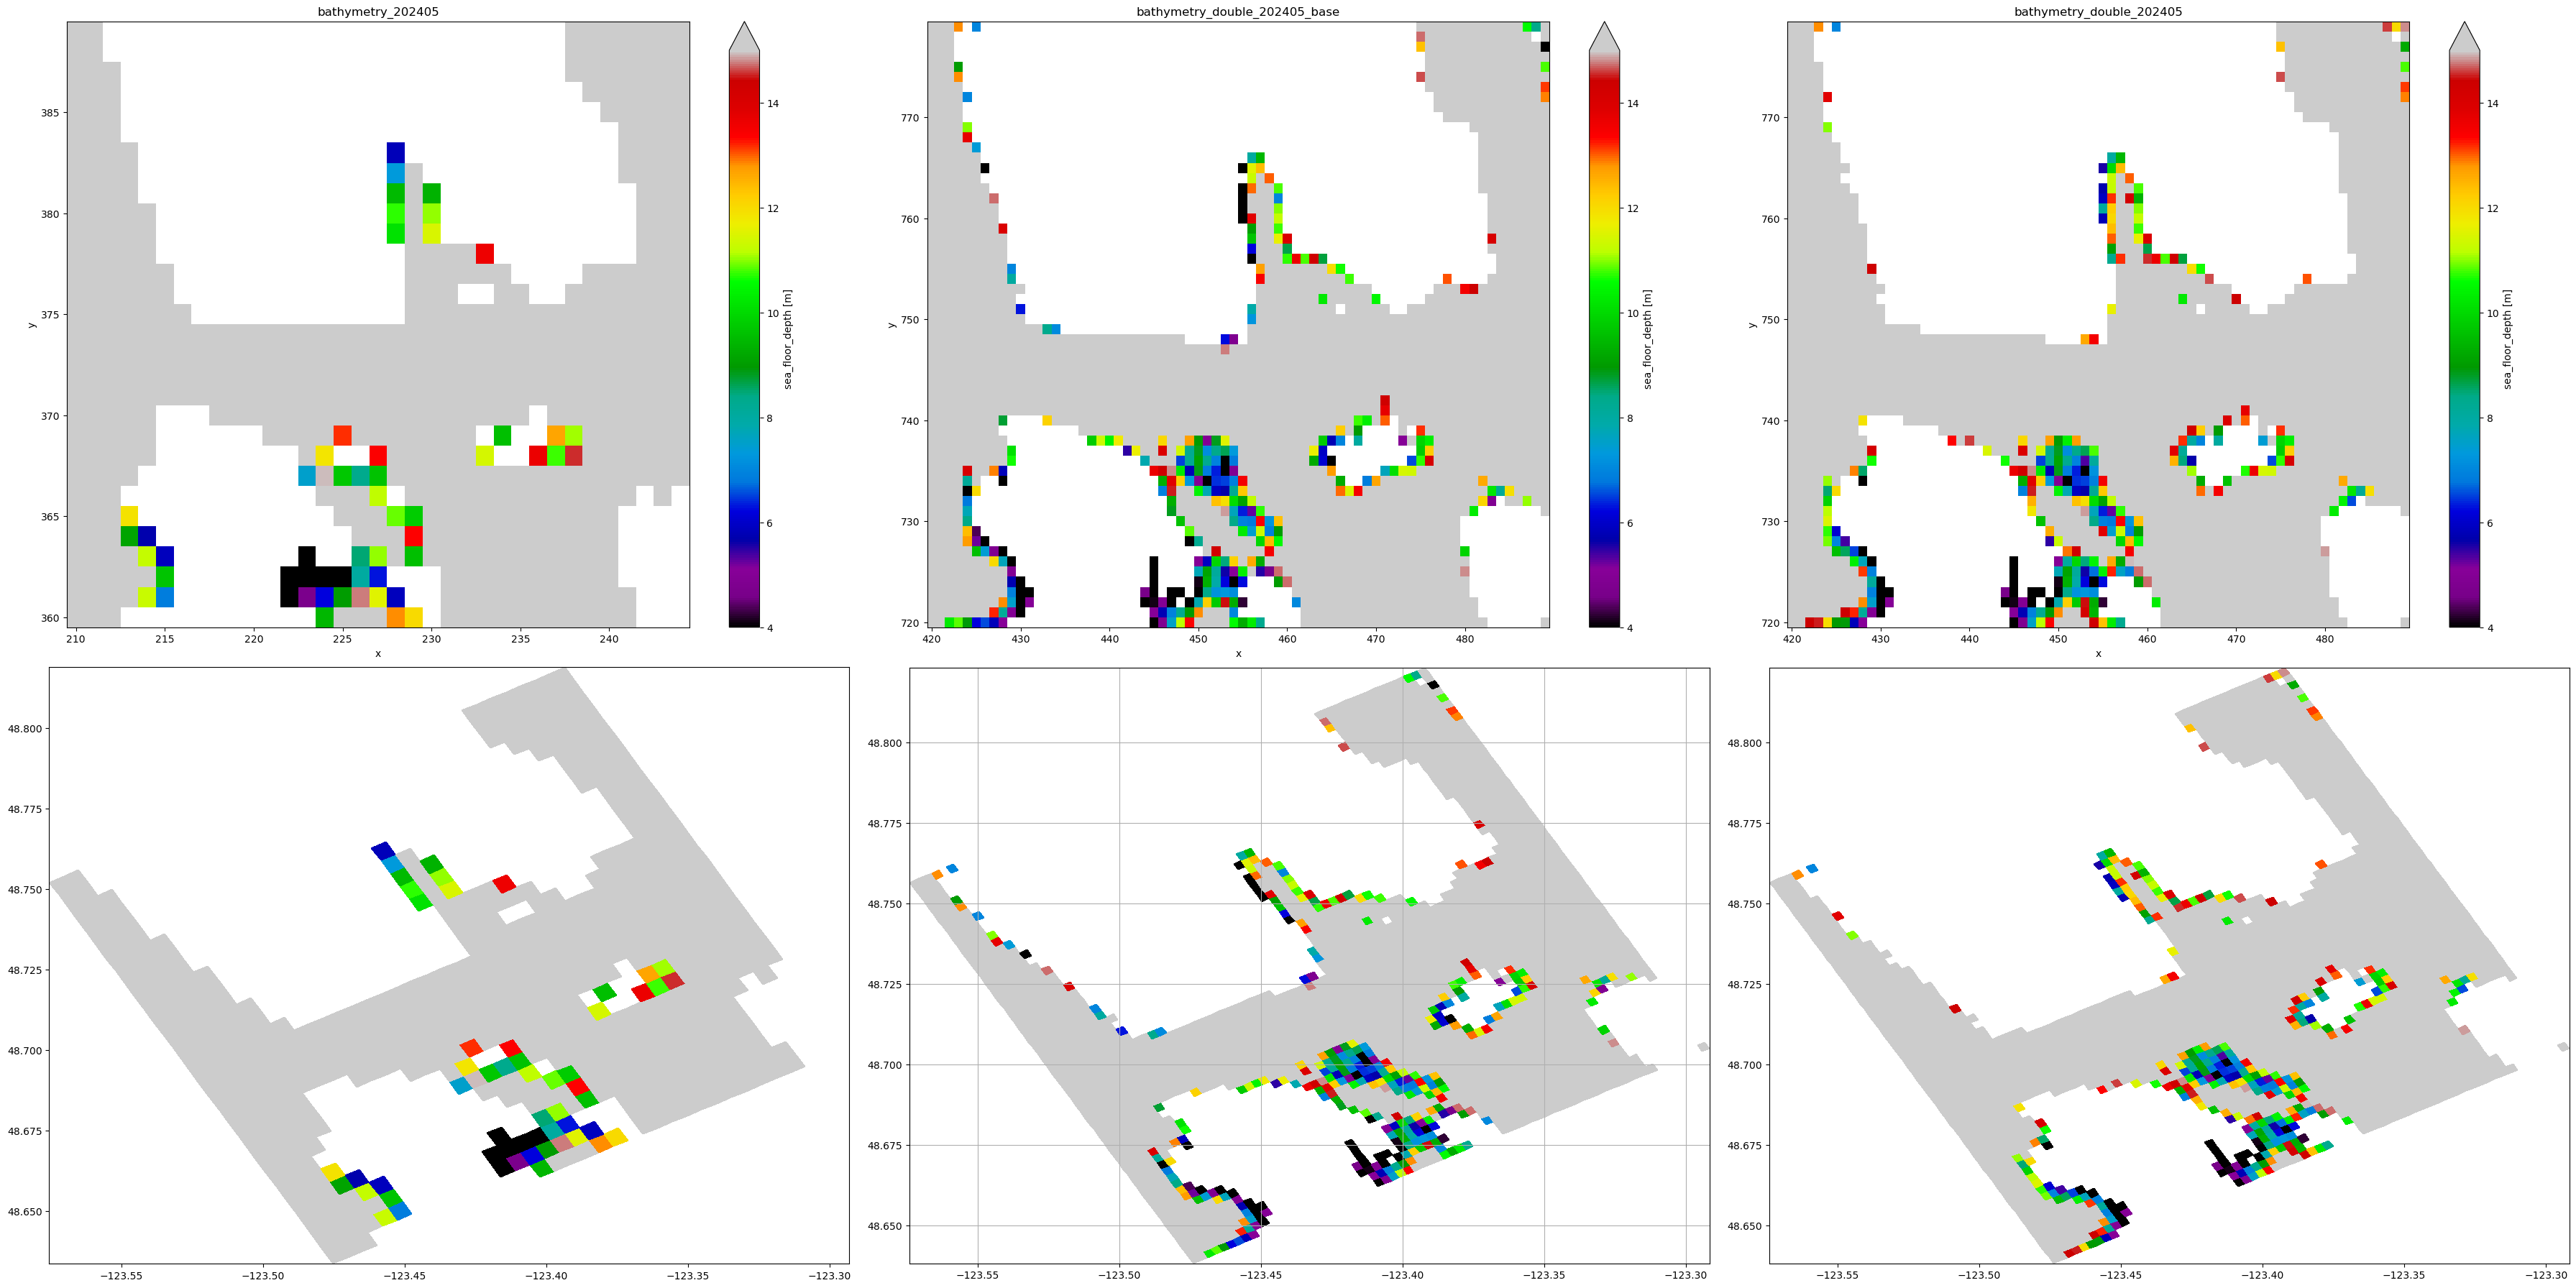

In [58]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 7, 8 - Pender Island, Mayne Island & Saturna Island

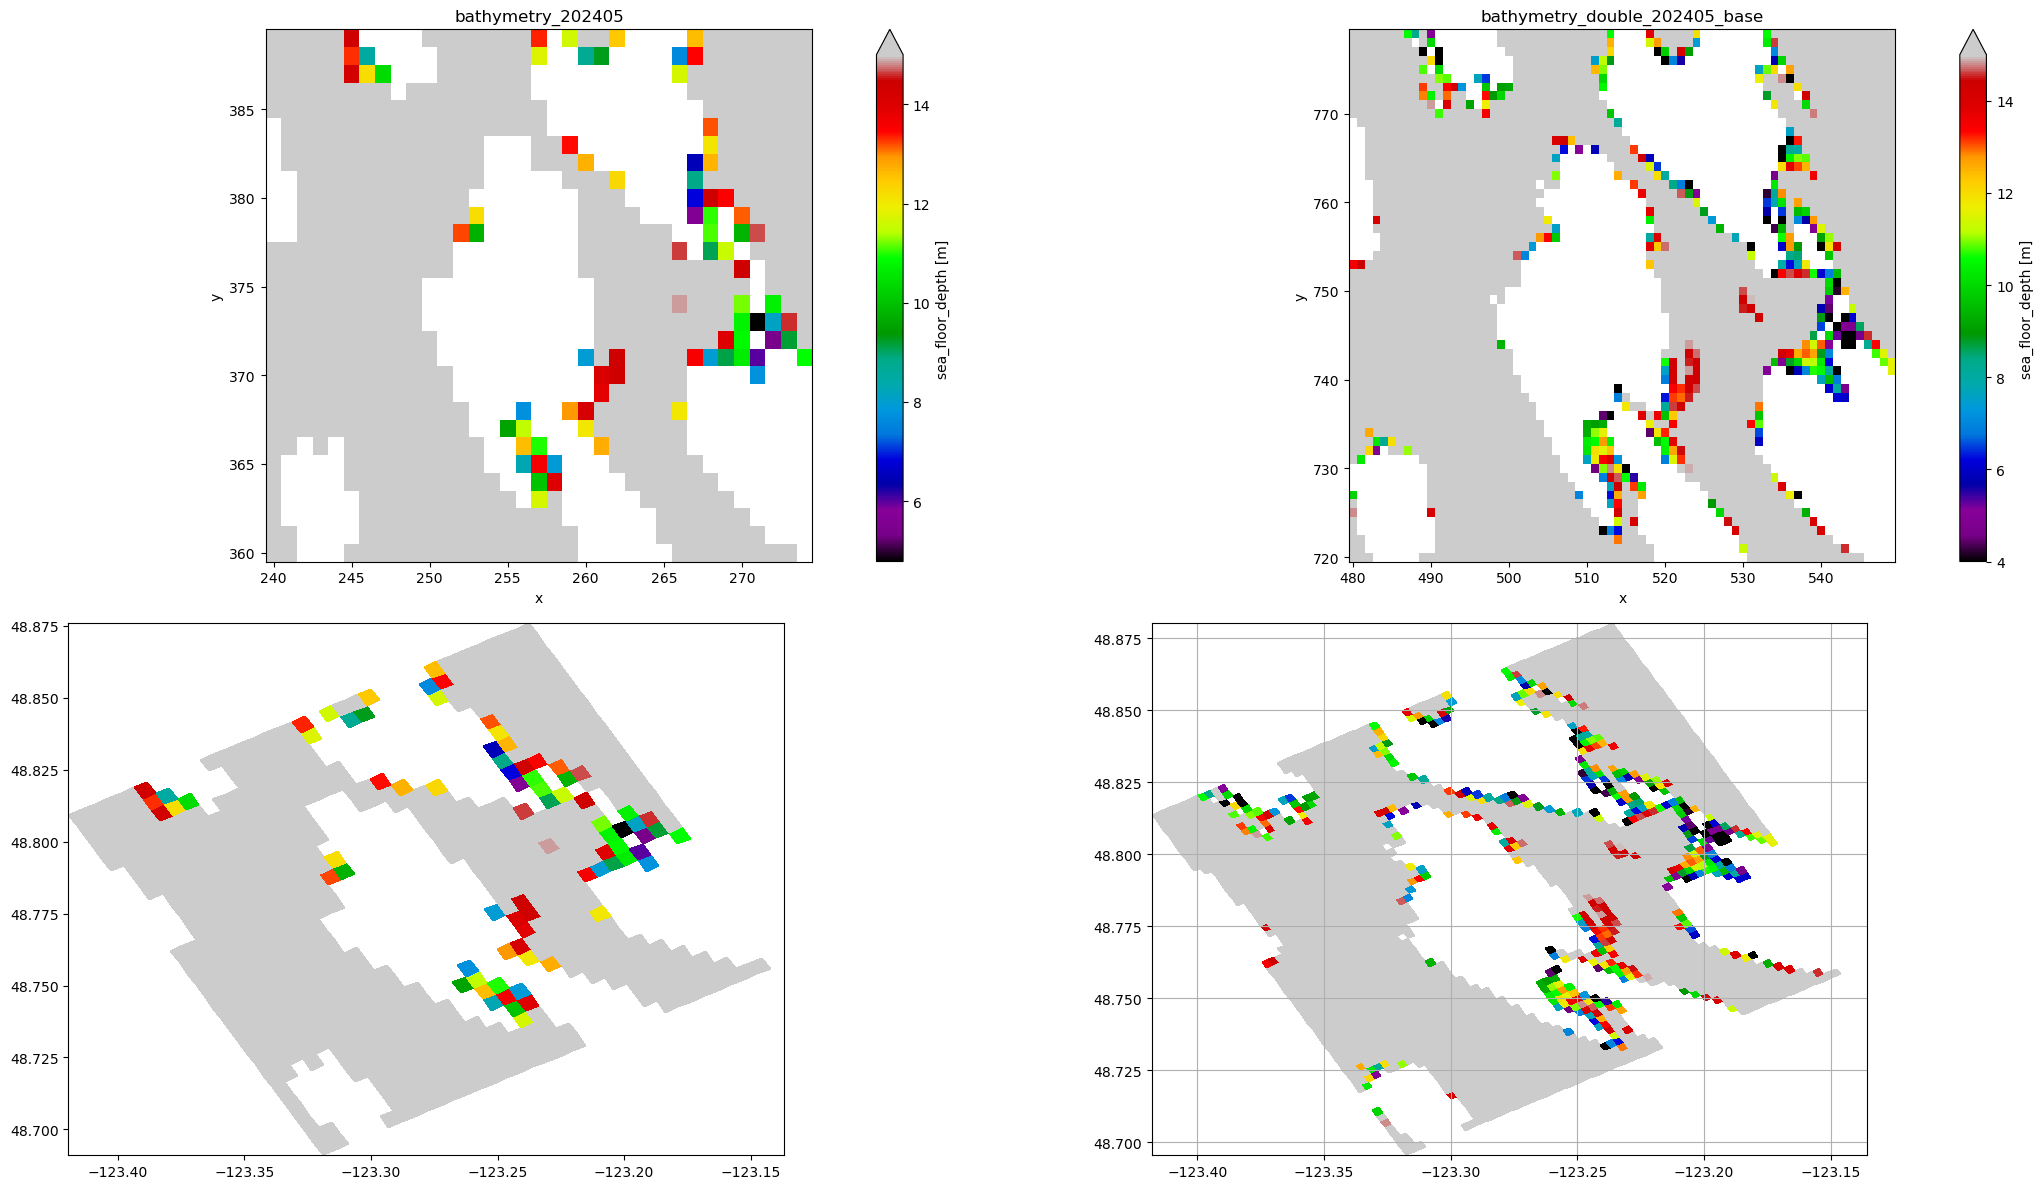

In [52]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base)

### Tile 7, 9 - Saturna Island & Tumbo Island

* surface Tumbo Island
* narrow Boat Passage
* open west entrance to Winter Cove

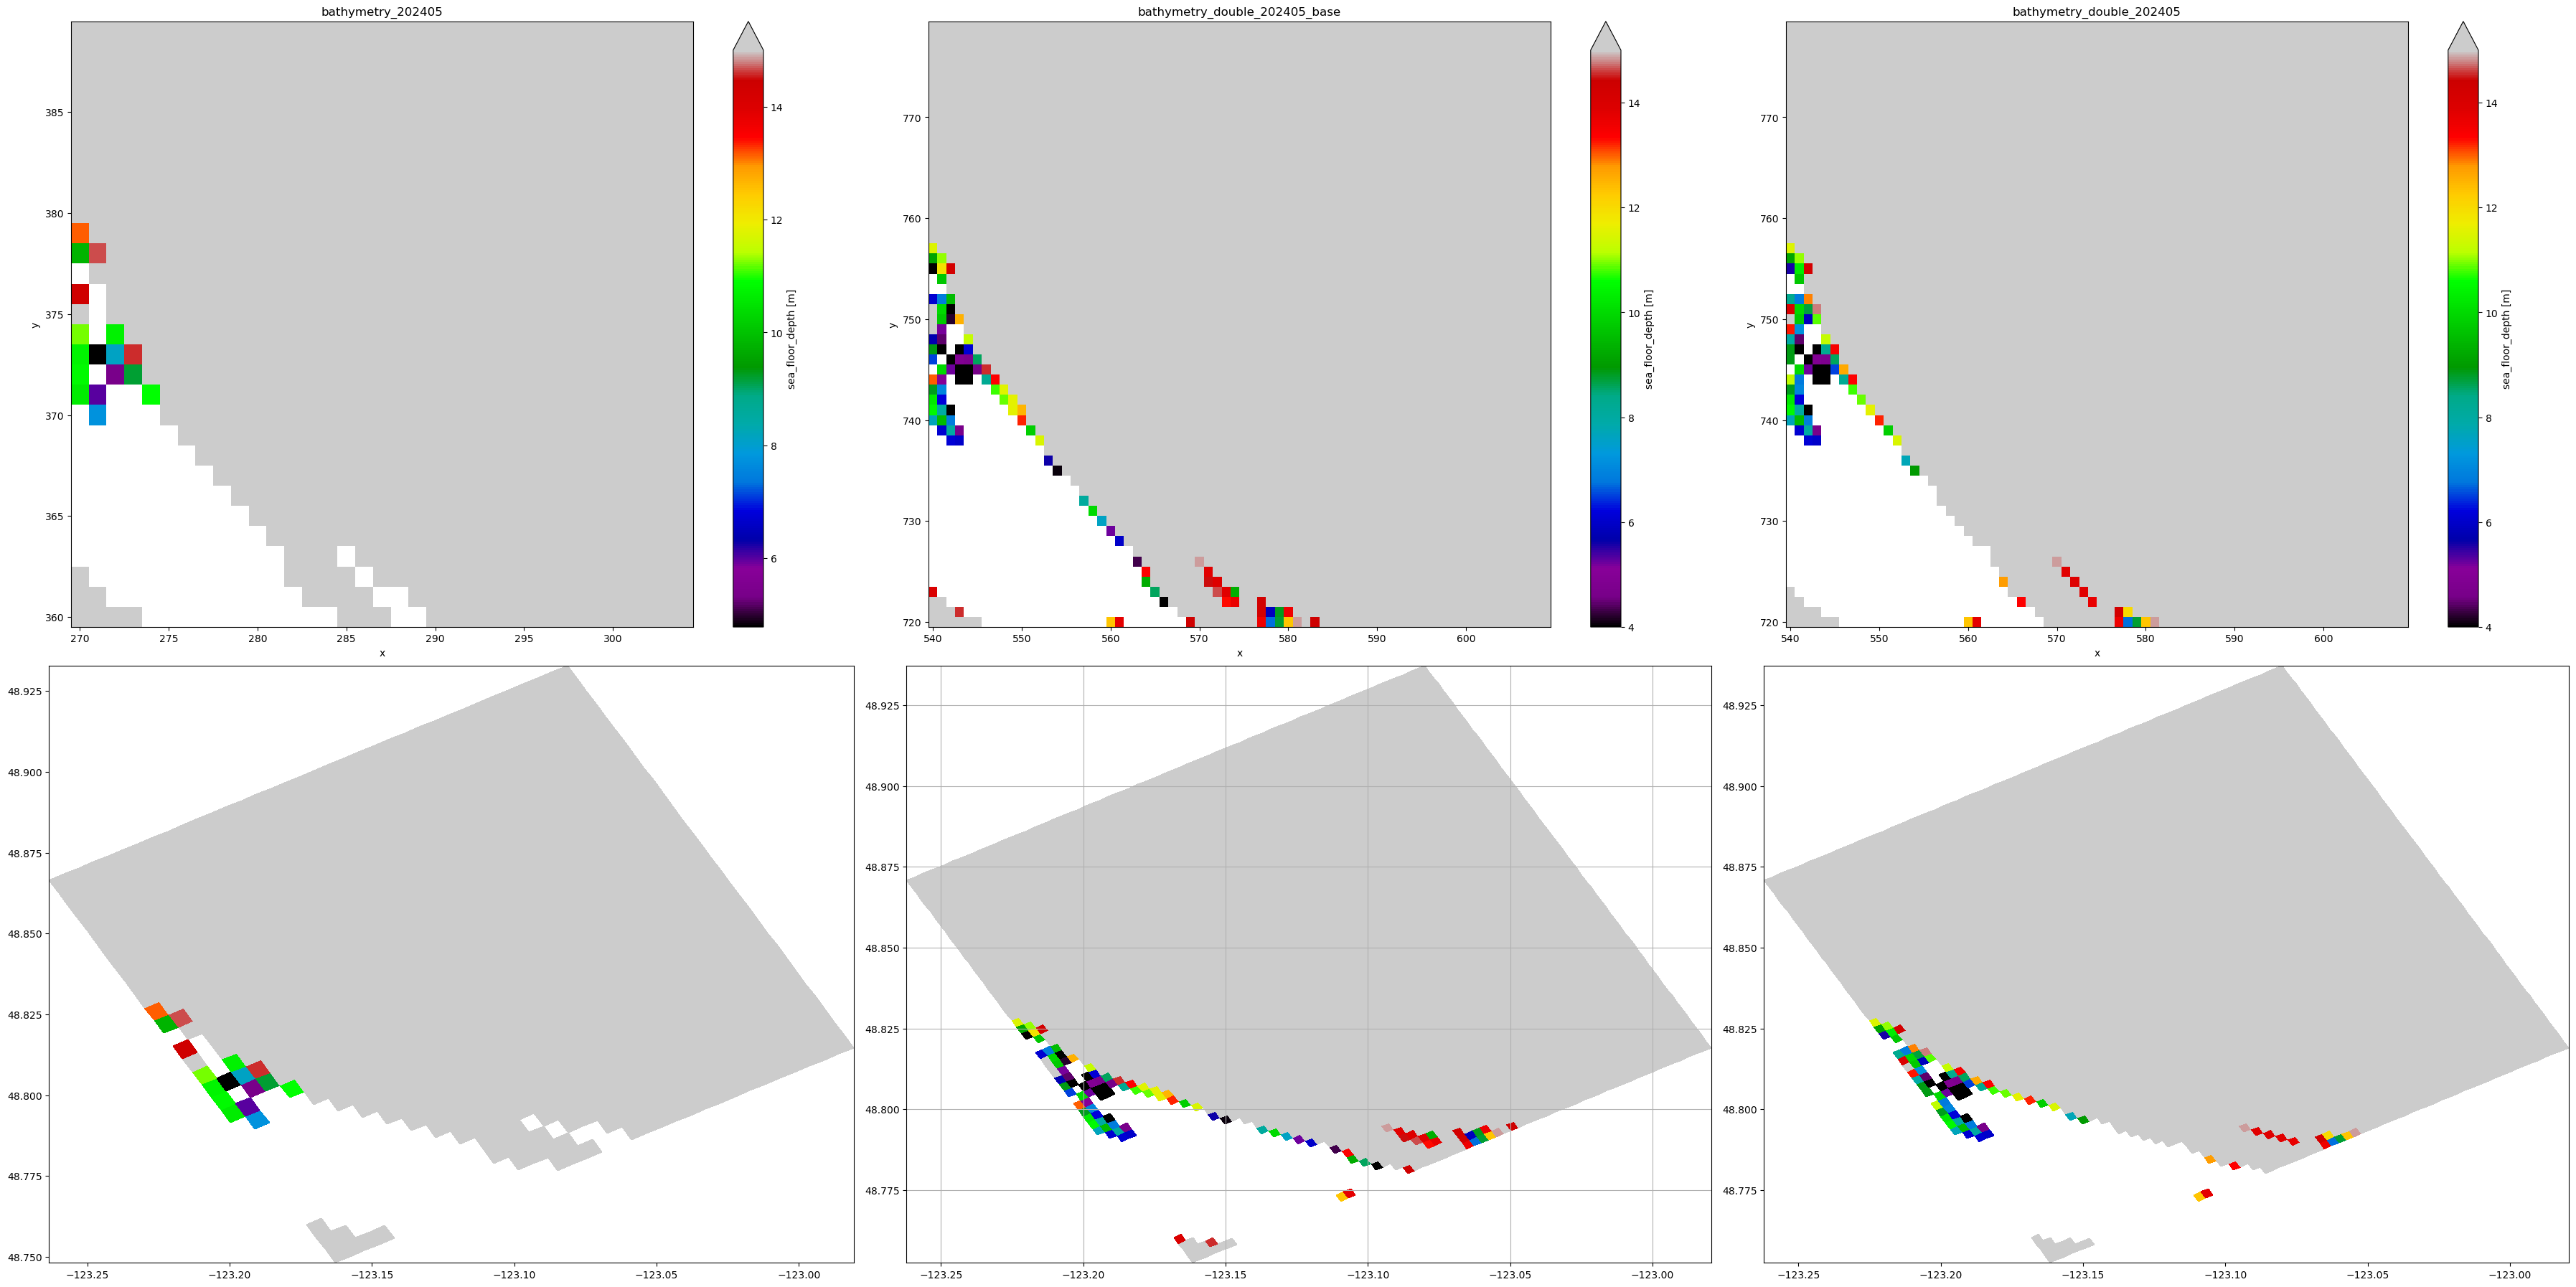

In [57]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base, dbl_bathy)

### Tile 7, 10 - South of Point Roberts

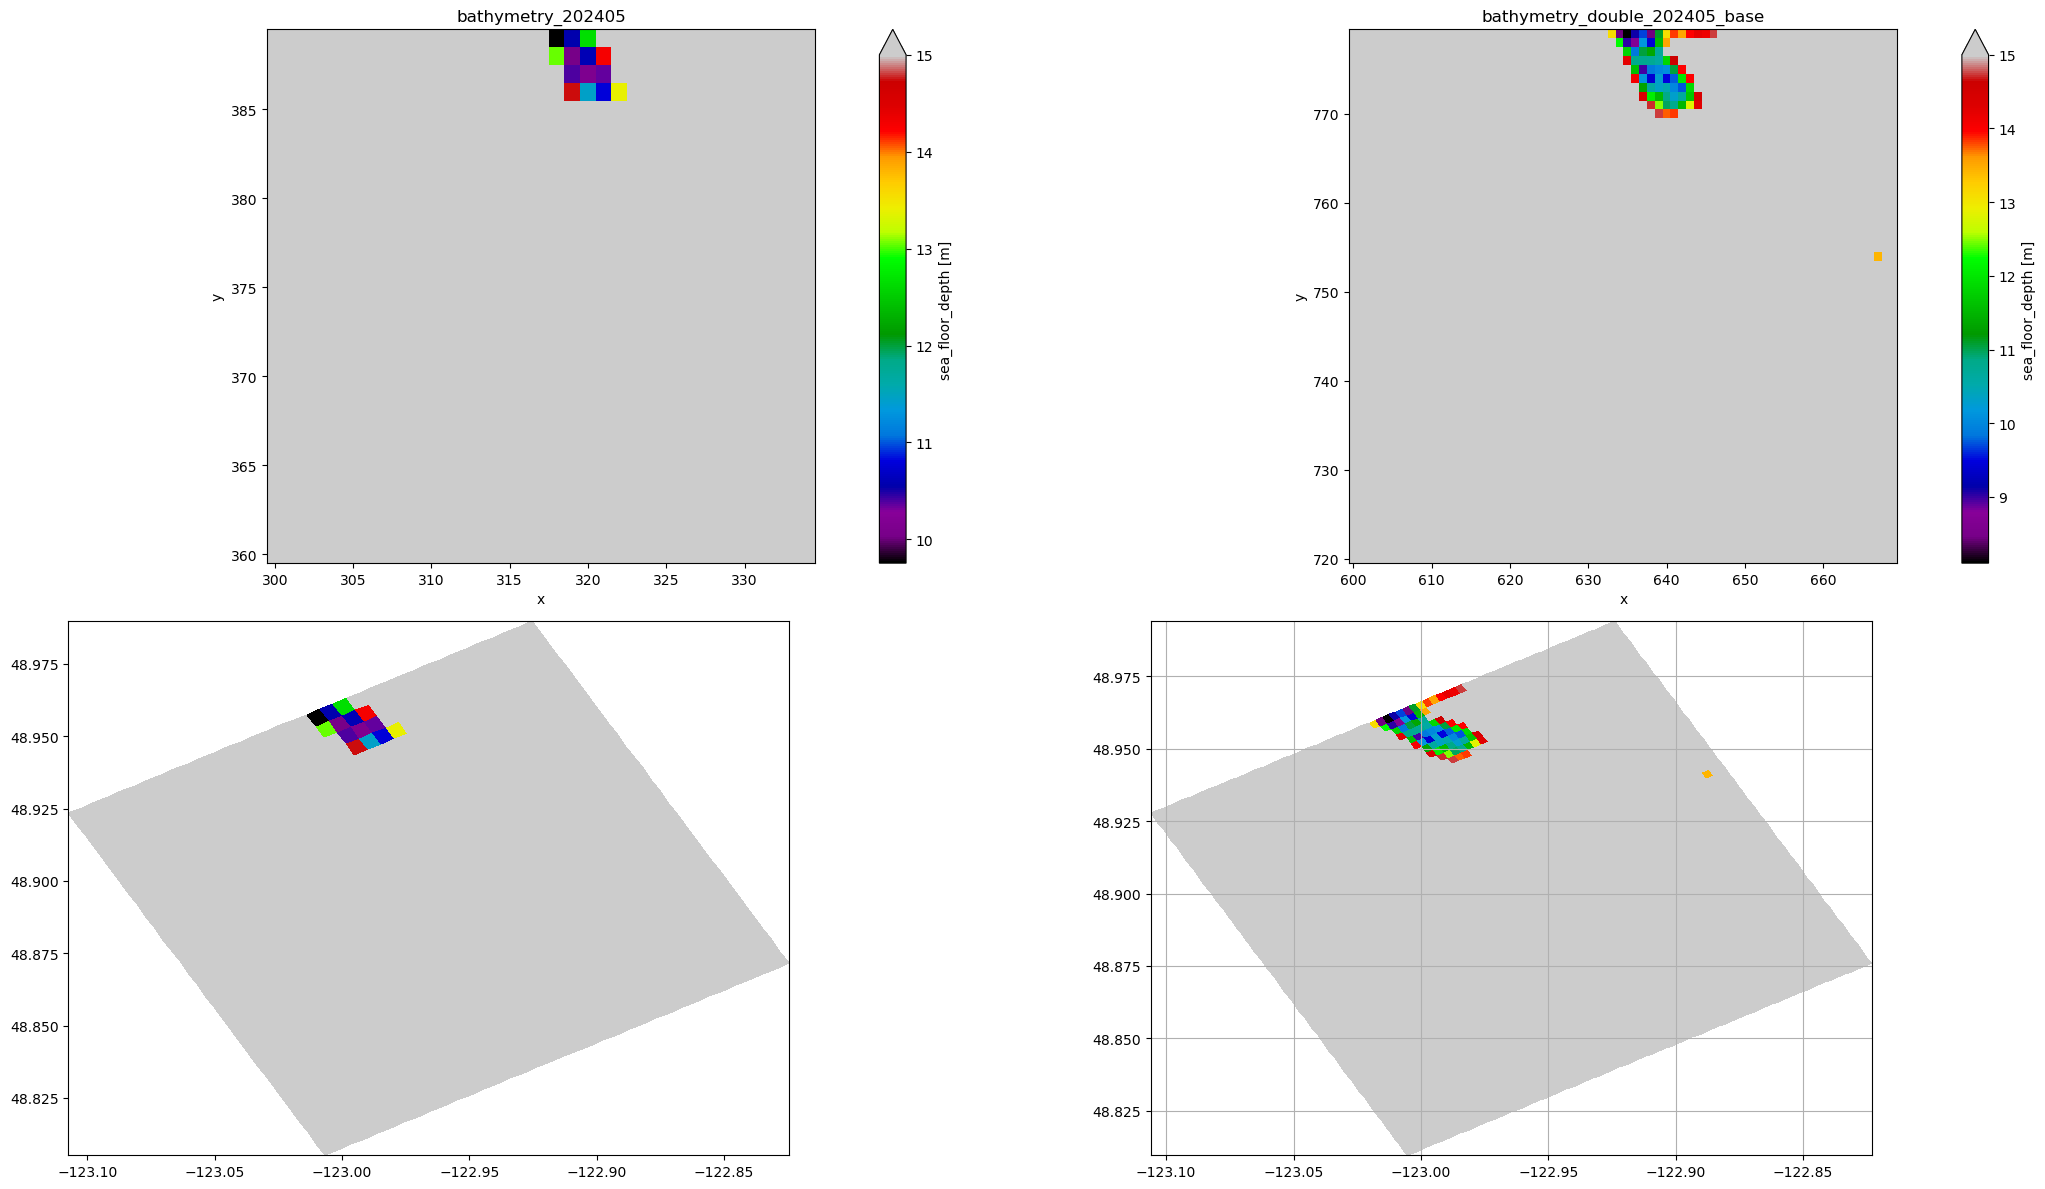

In [54]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base)

### Tile 7, 11 - Semiahmoo Bay & Drayton Harbor

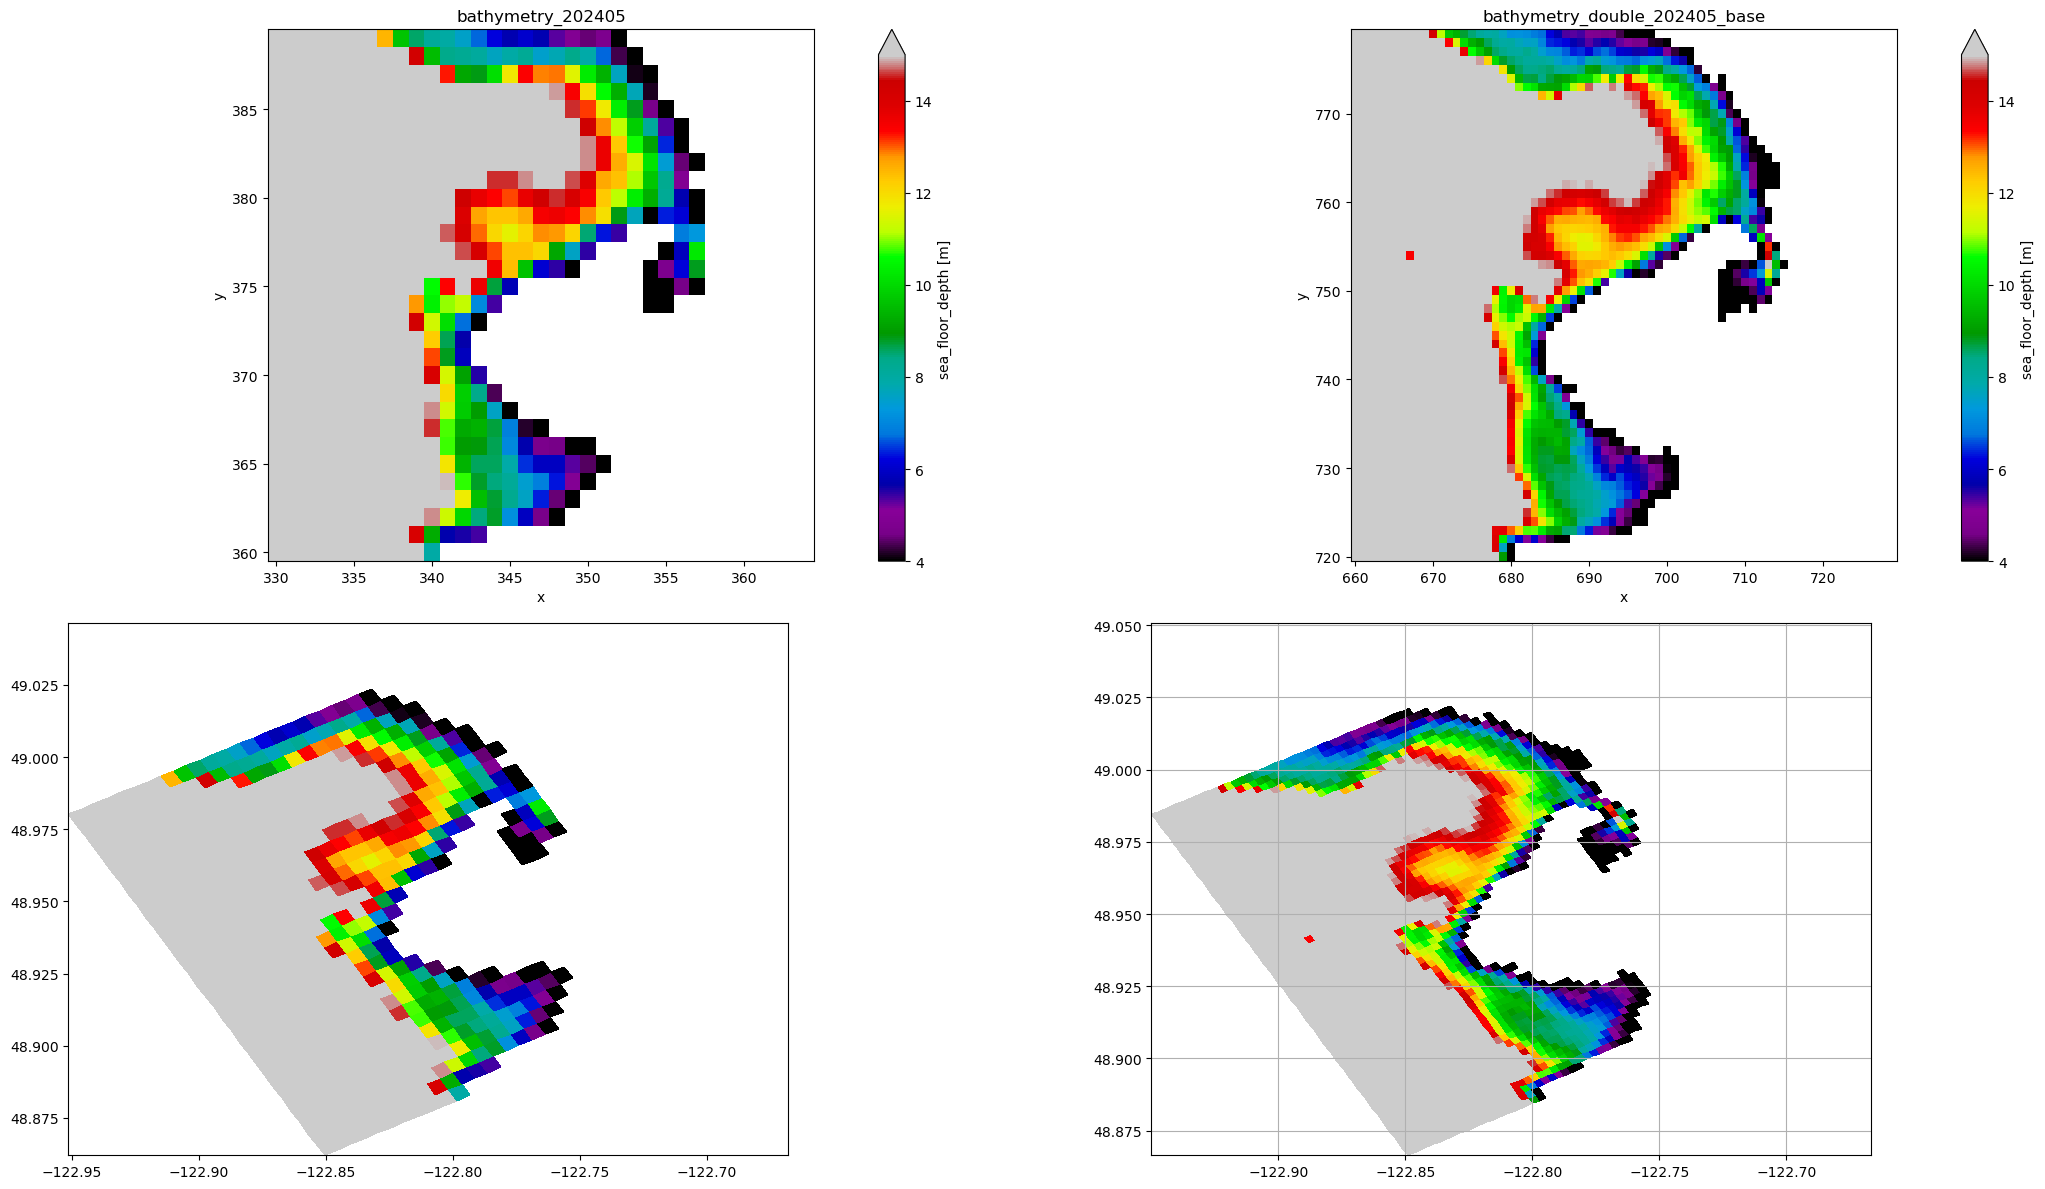

In [60]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base)

### Tile 7, 12

* all land with some Fraser River proxy

## Row 8 - Neah Bay to Surrey

In [61]:
y_min_max = numpy.array([390, 420])
y_slices = {
    "sgl": slice(*y_min_max),
    "dbl": slice(*y_min_max *2),
}

### Tile 8, 0 - Warmhouse Beach & Neah Bay

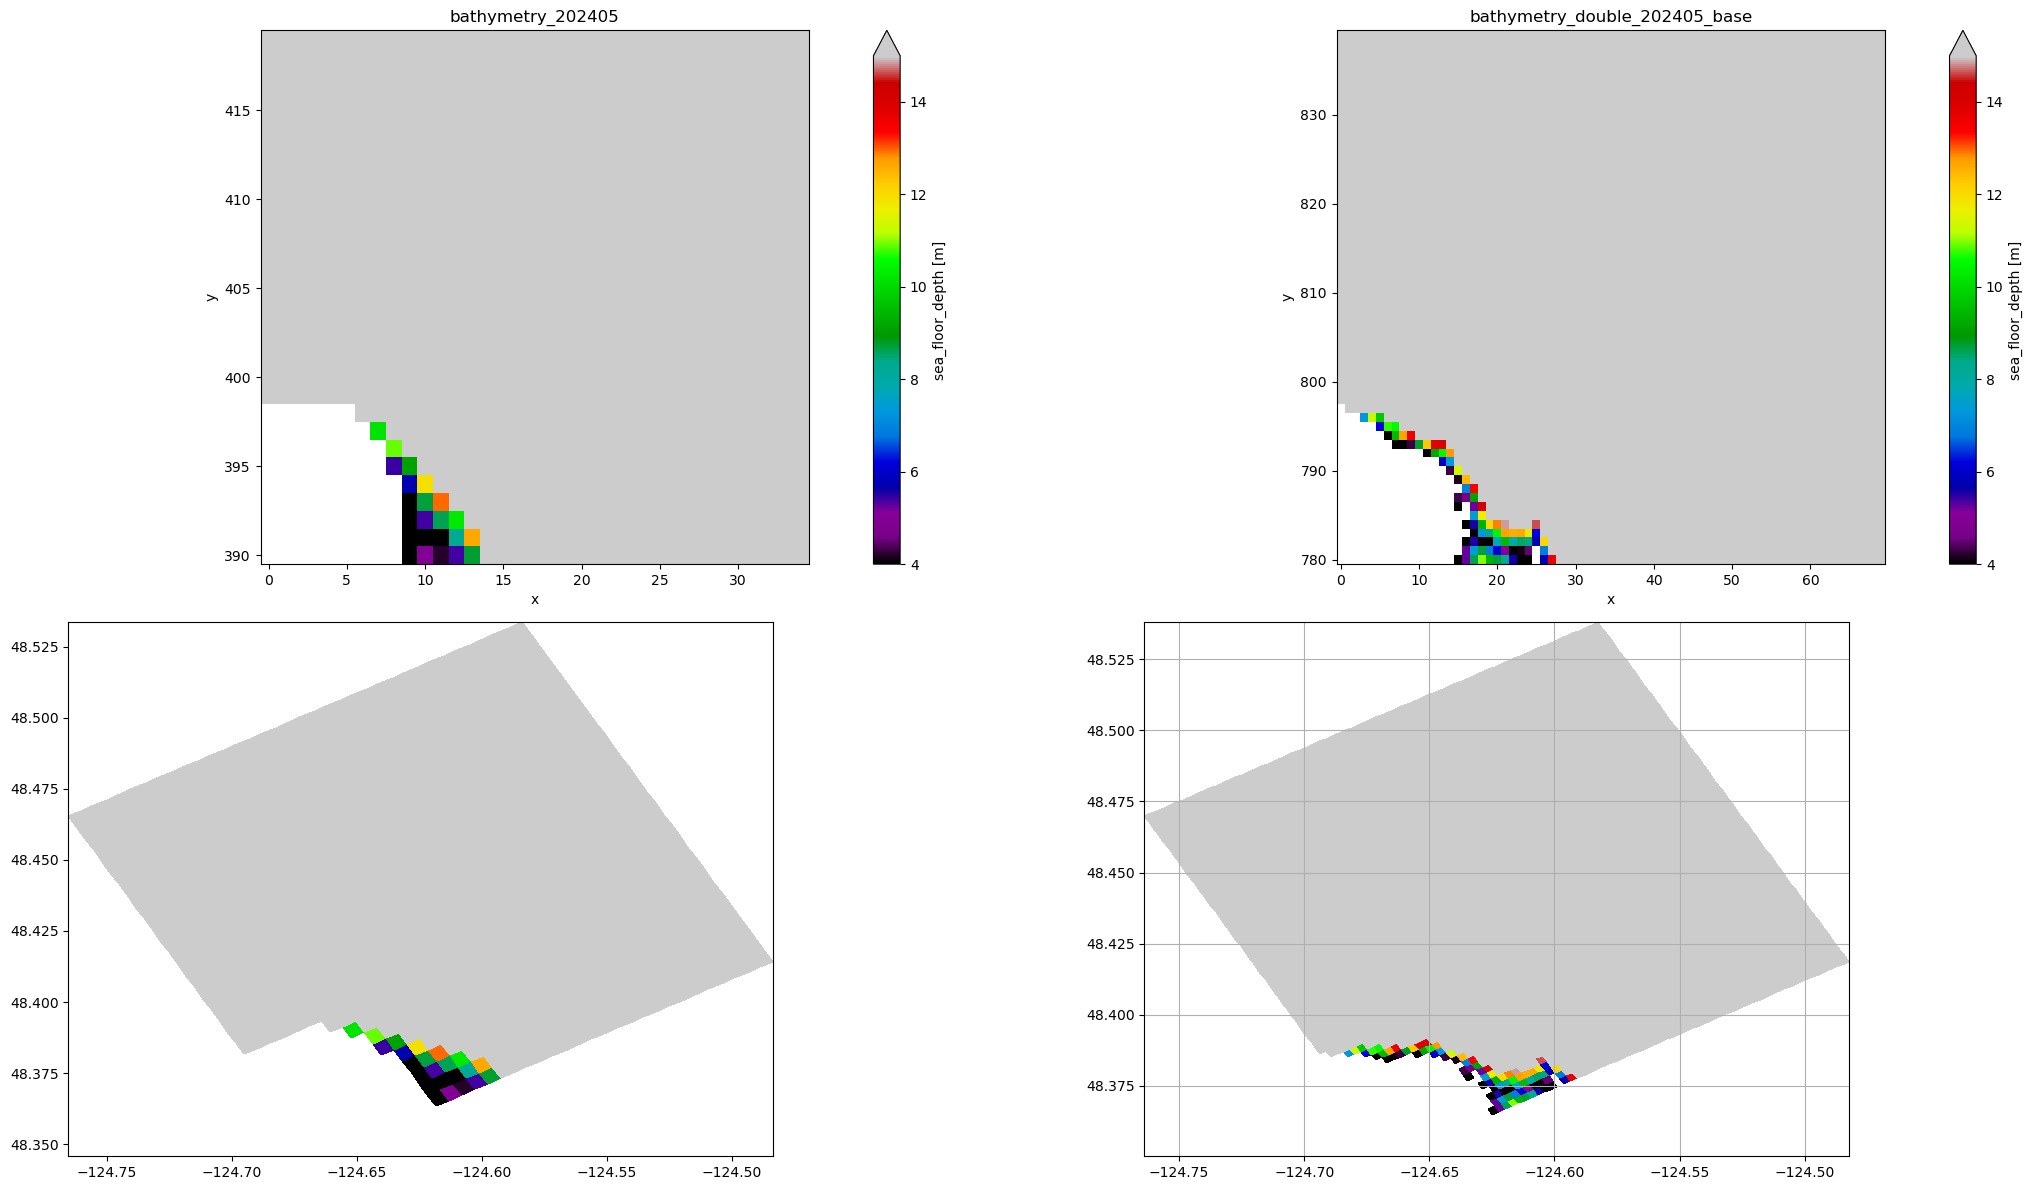

In [62]:
plot_tile(tile_x_min_max[0], y_slices, bathy, dbl_bathy_base)

### Tile 8, 1 - Port Renfrew

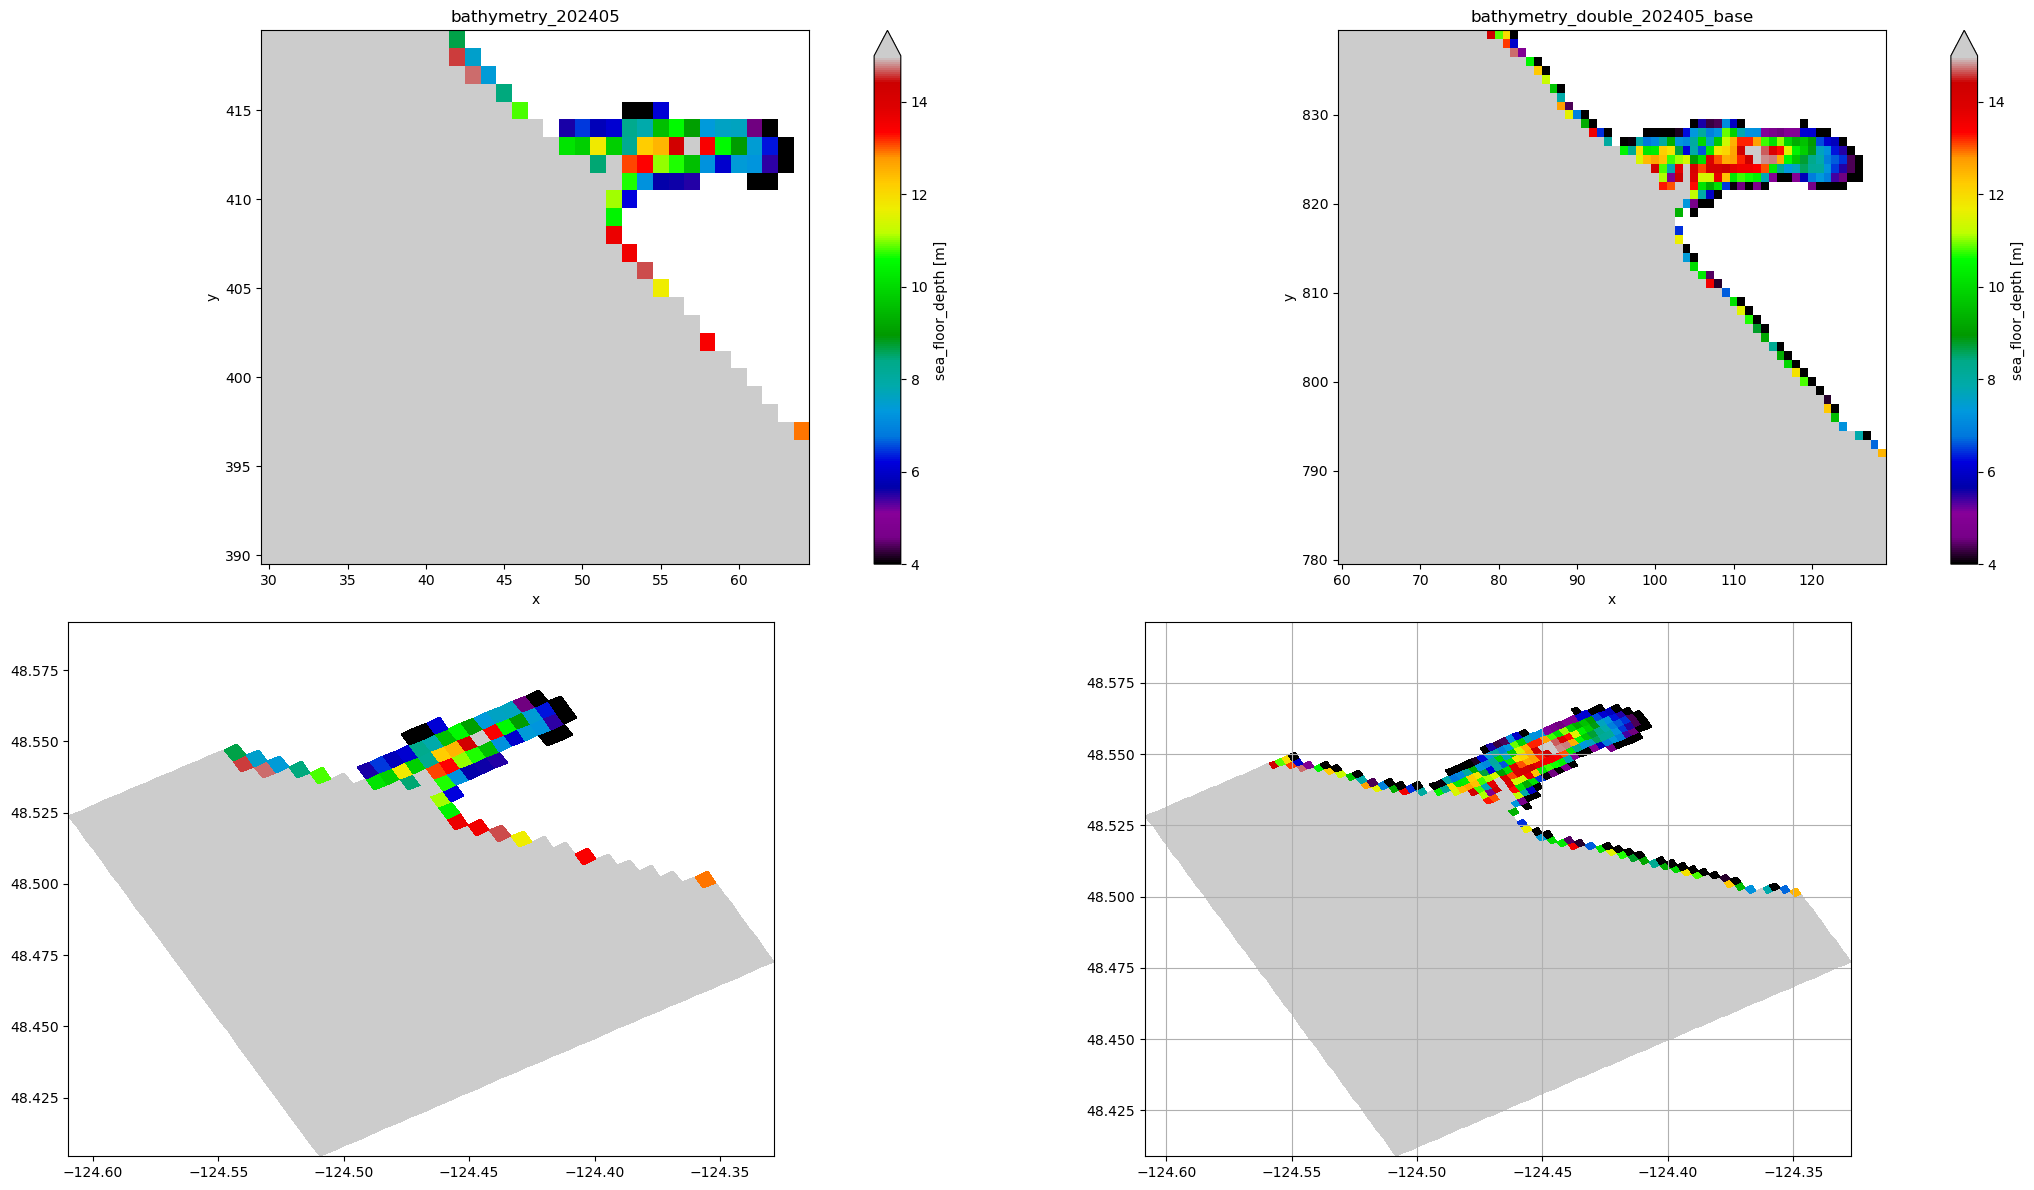

In [63]:
plot_tile(tile_x_min_max[1], y_slices, bathy, dbl_bathy_base)

### Tile 8, 2 - Sombrio Beach

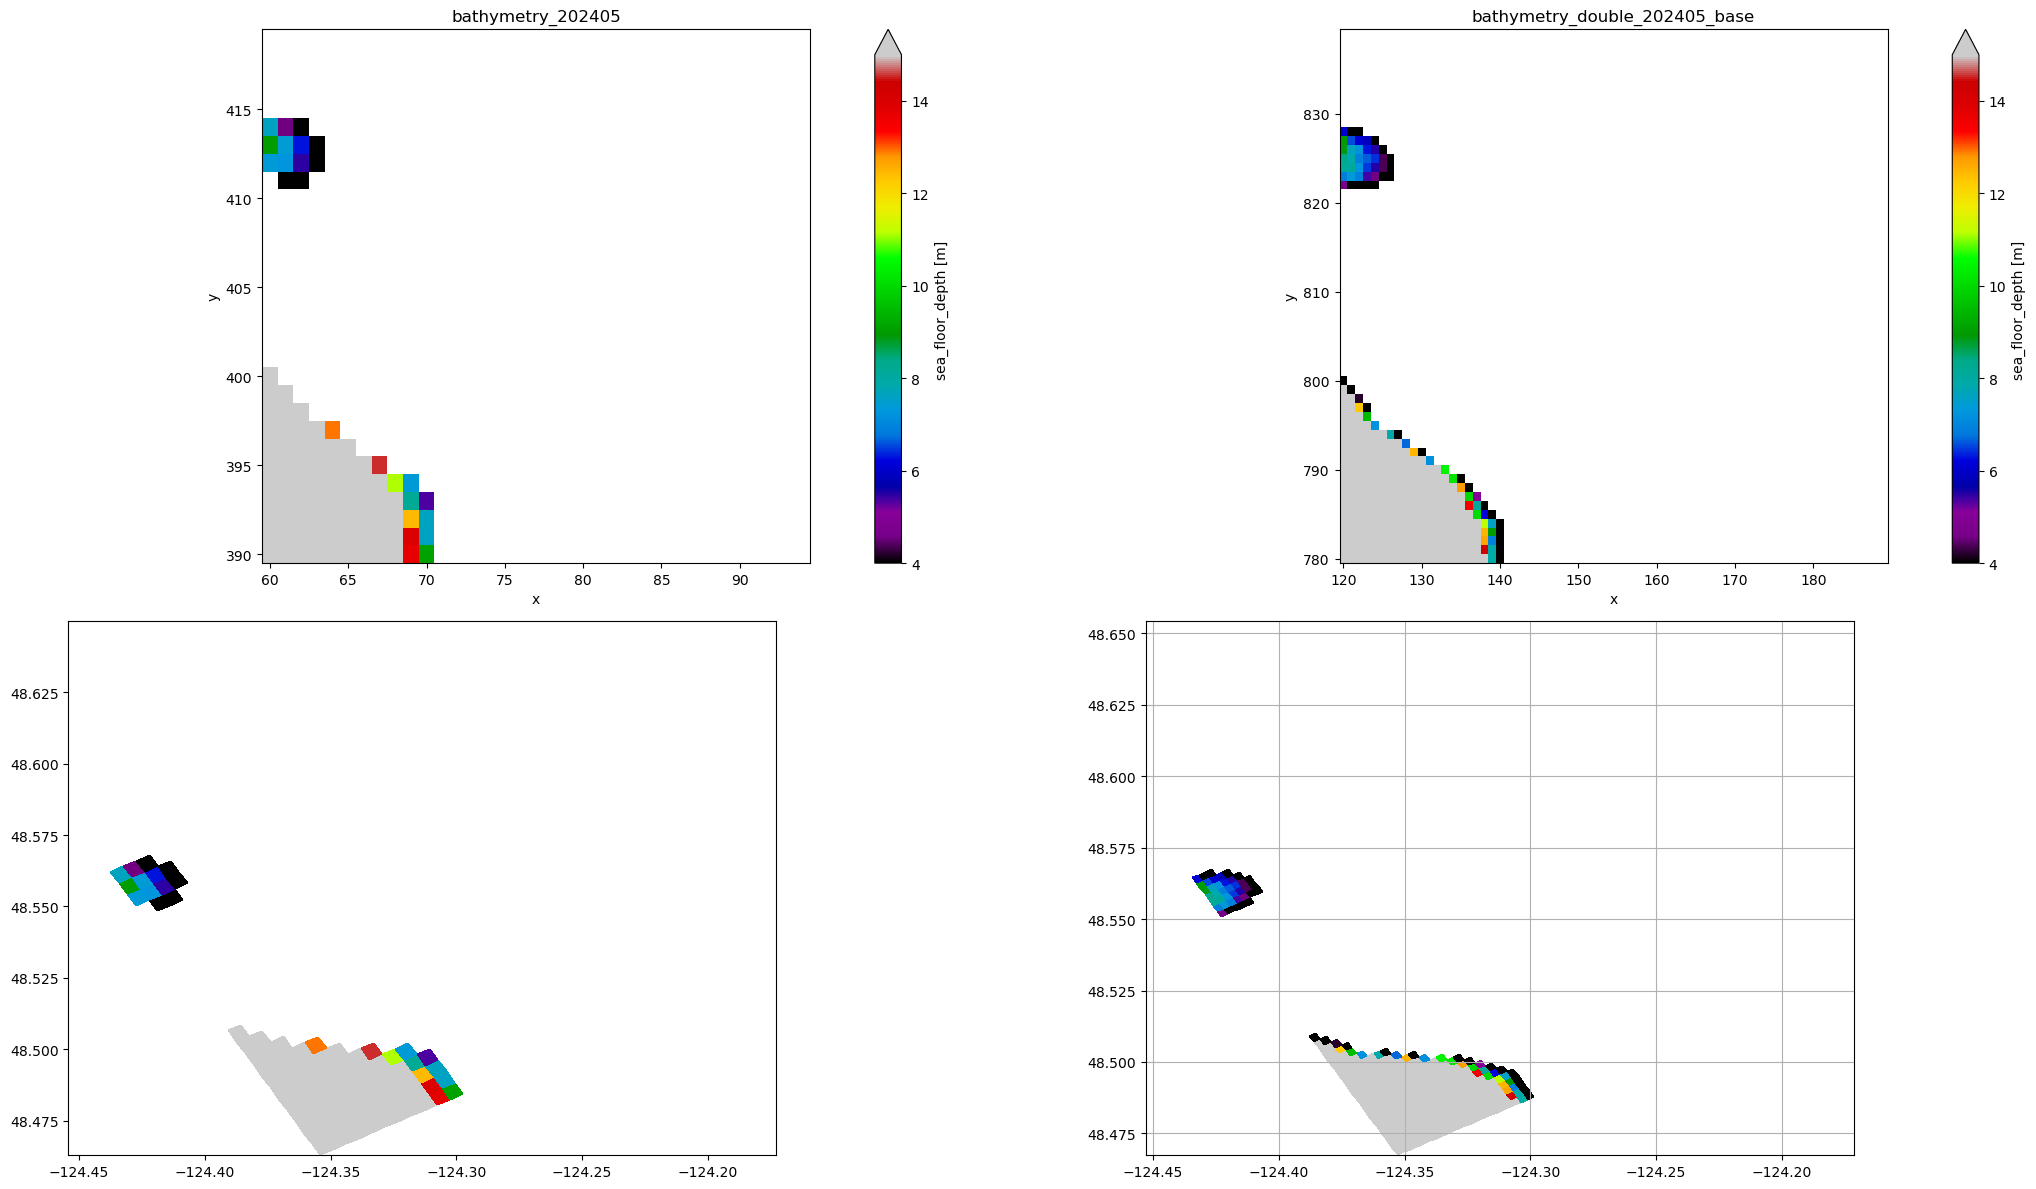

In [64]:
plot_tile(tile_x_min_max[2], y_slices, bathy, dbl_bathy_base)

### Tile 8, 3

* all land

### Tile 8, 4

* all land

### Tile 8, 5

* all land

### Tile 8, 6 - Genoa Bay & Maple Bay

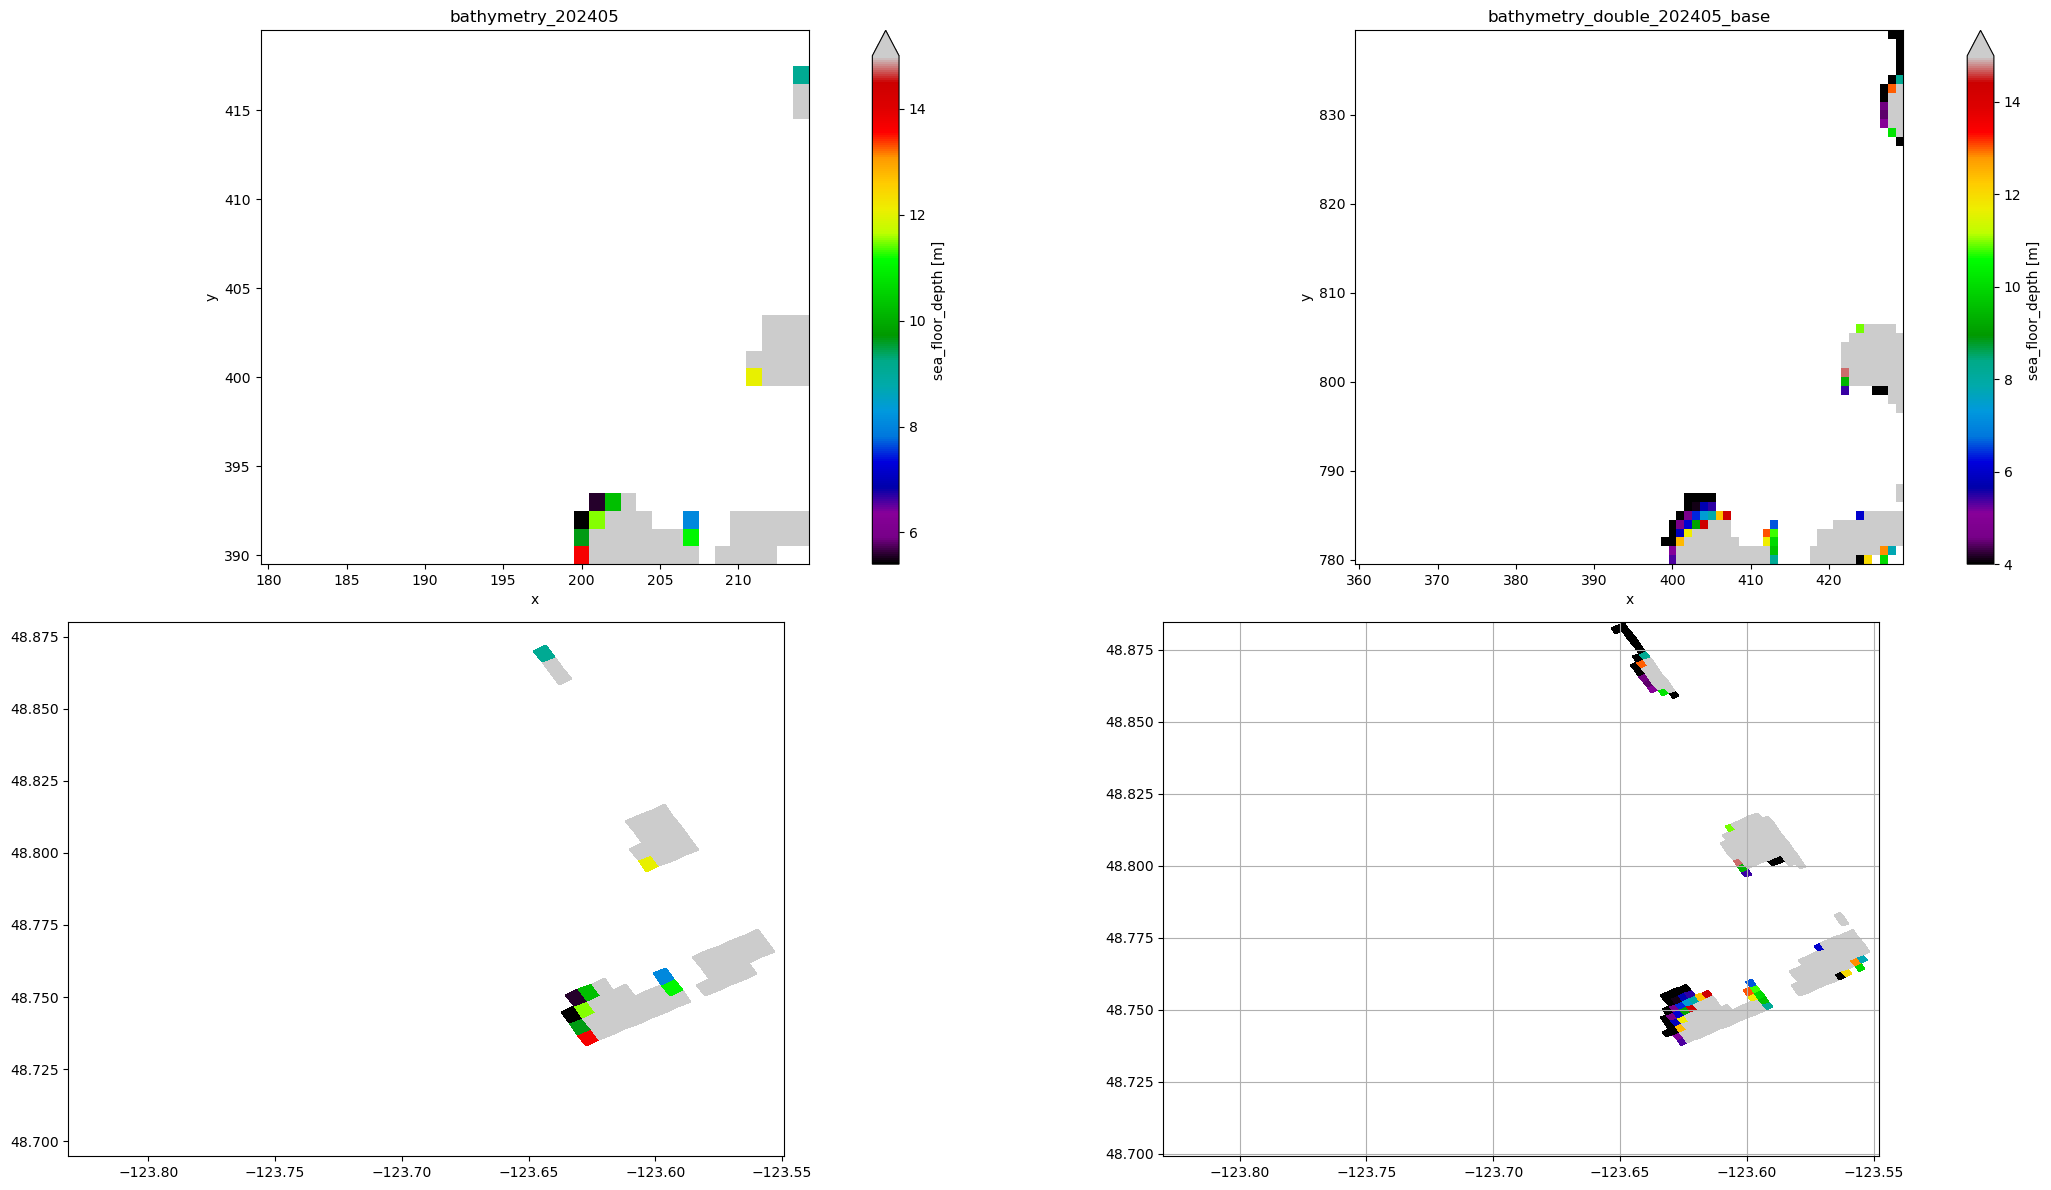

In [68]:
plot_tile(tile_x_min_max[6], y_slices, bathy, dbl_bathy_base)

### Tile 8, 7 - Crofton, Ganges, Long Harbour & Trincomali Channel

* fill in Athol Peninsula

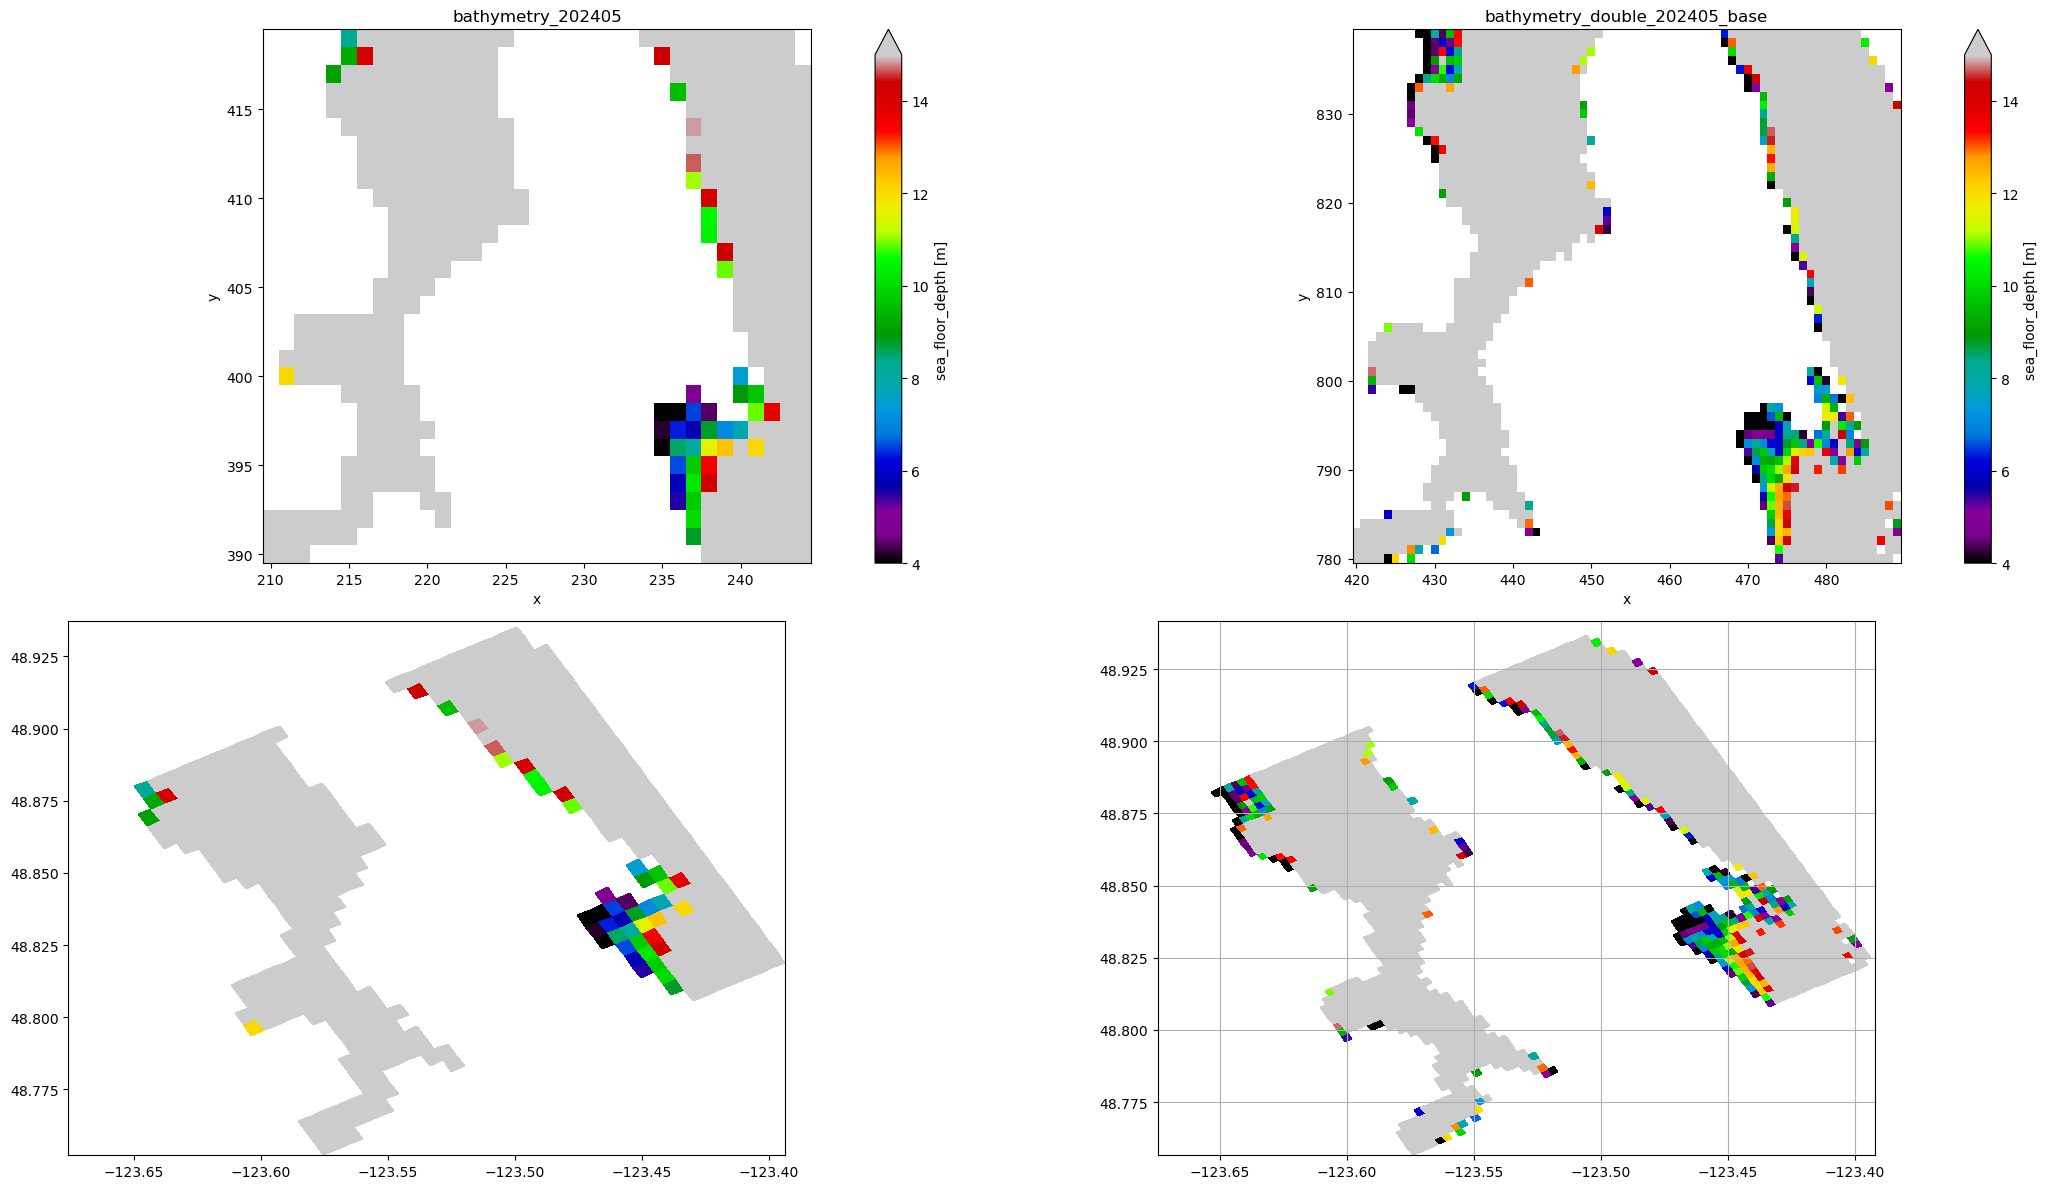

In [69]:
plot_tile(tile_x_min_max[7], y_slices, bathy, dbl_bathy_base)

### Tile 8, 8 - Galiano Island

* separate Parker Island
* connect 2 points on north end of Prevost Island

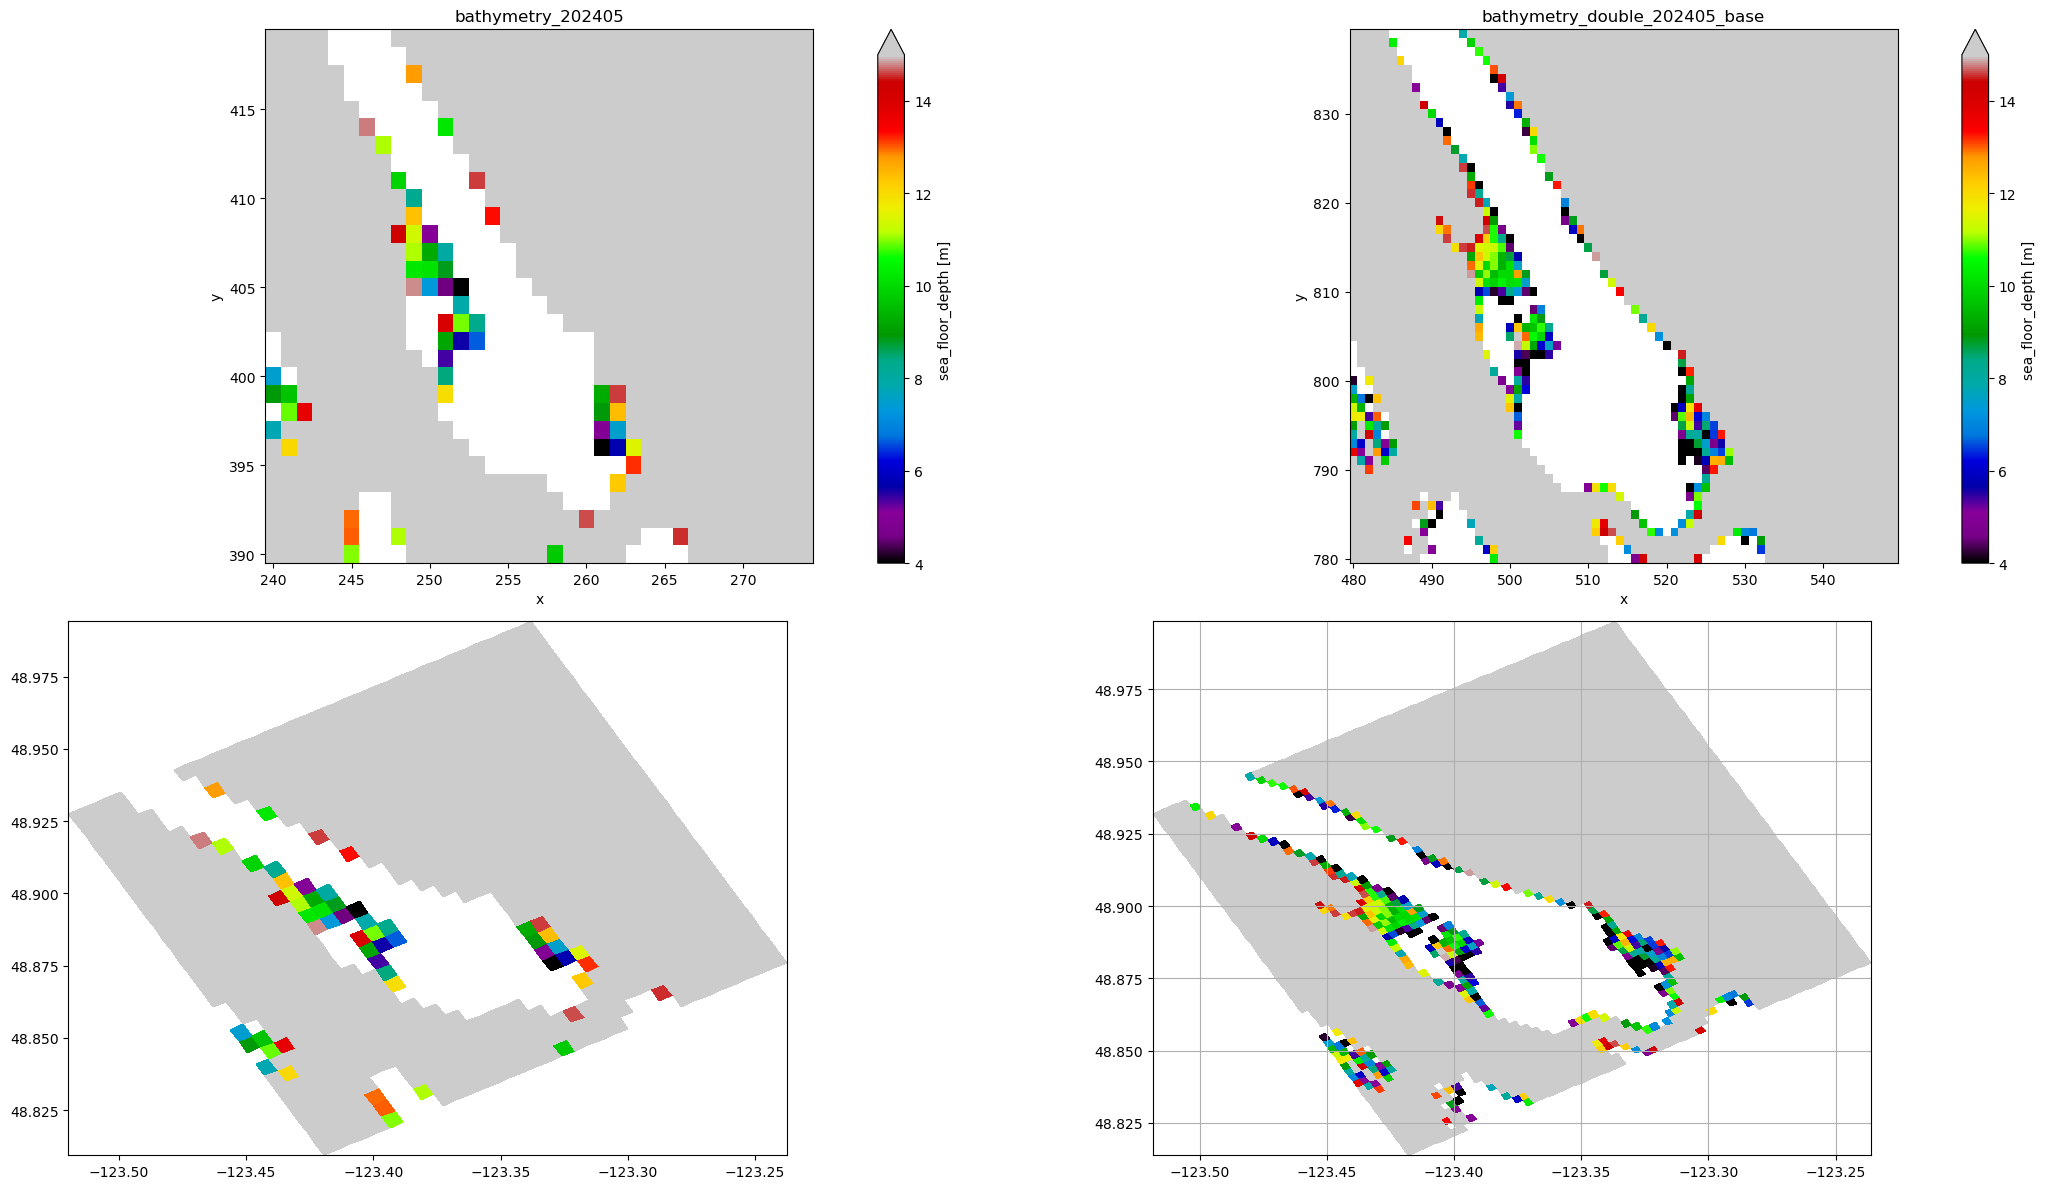

In [70]:
plot_tile(tile_x_min_max[8], y_slices, bathy, dbl_bathy_base)

### Tile 8, 9 - Roberts Bank?

* change 4 fake islands to 4m deep

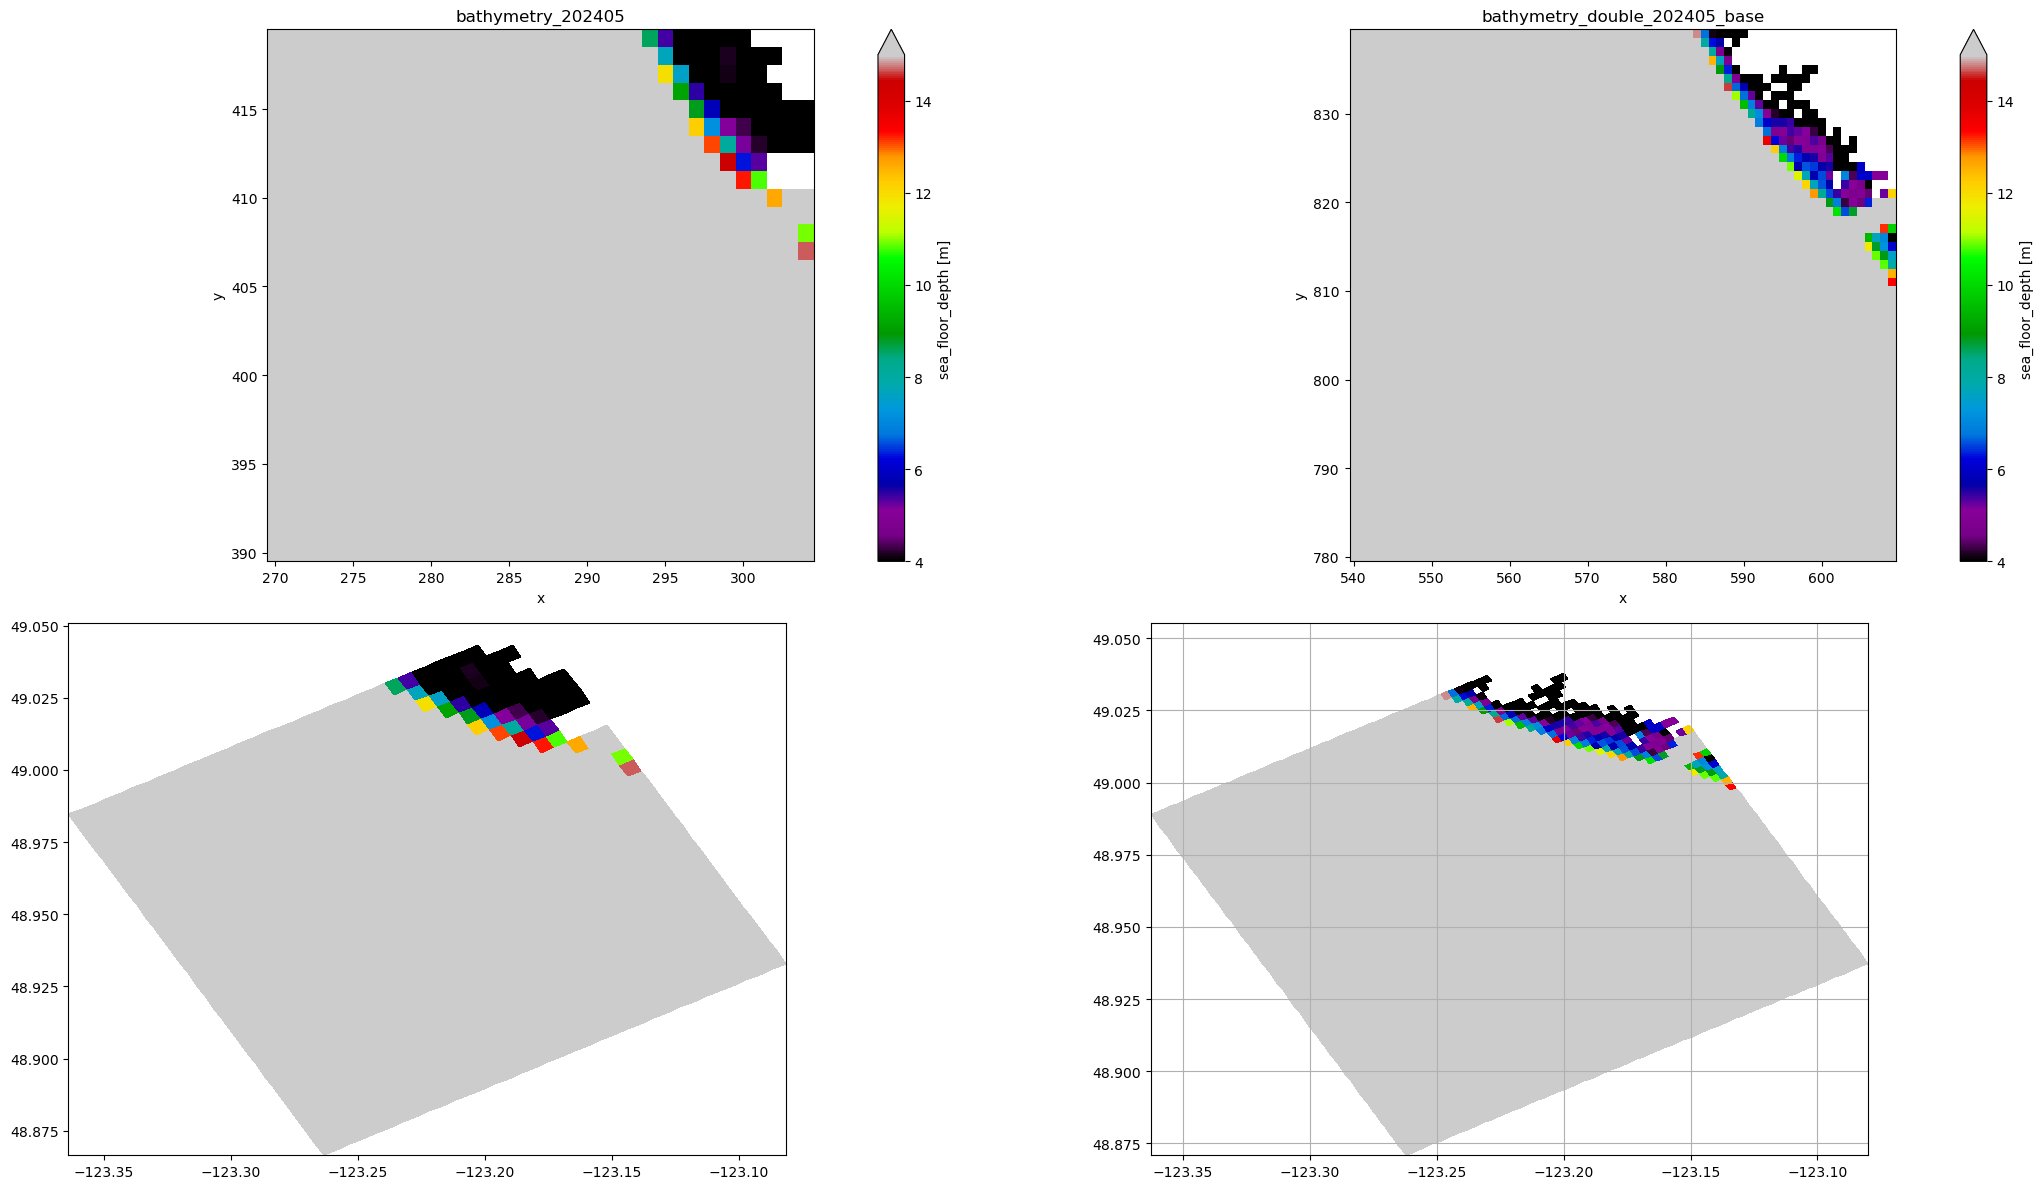

In [71]:
plot_tile(tile_x_min_max[9], y_slices, bathy, dbl_bathy_base)

### Tile 8, 10 - Point Roberts & Tsawwassen

* add Tsawwassen ferry terminal and spit
* add Roberts Bank port and spit
* change fake island SE of Pt. Roberts to 4m deep

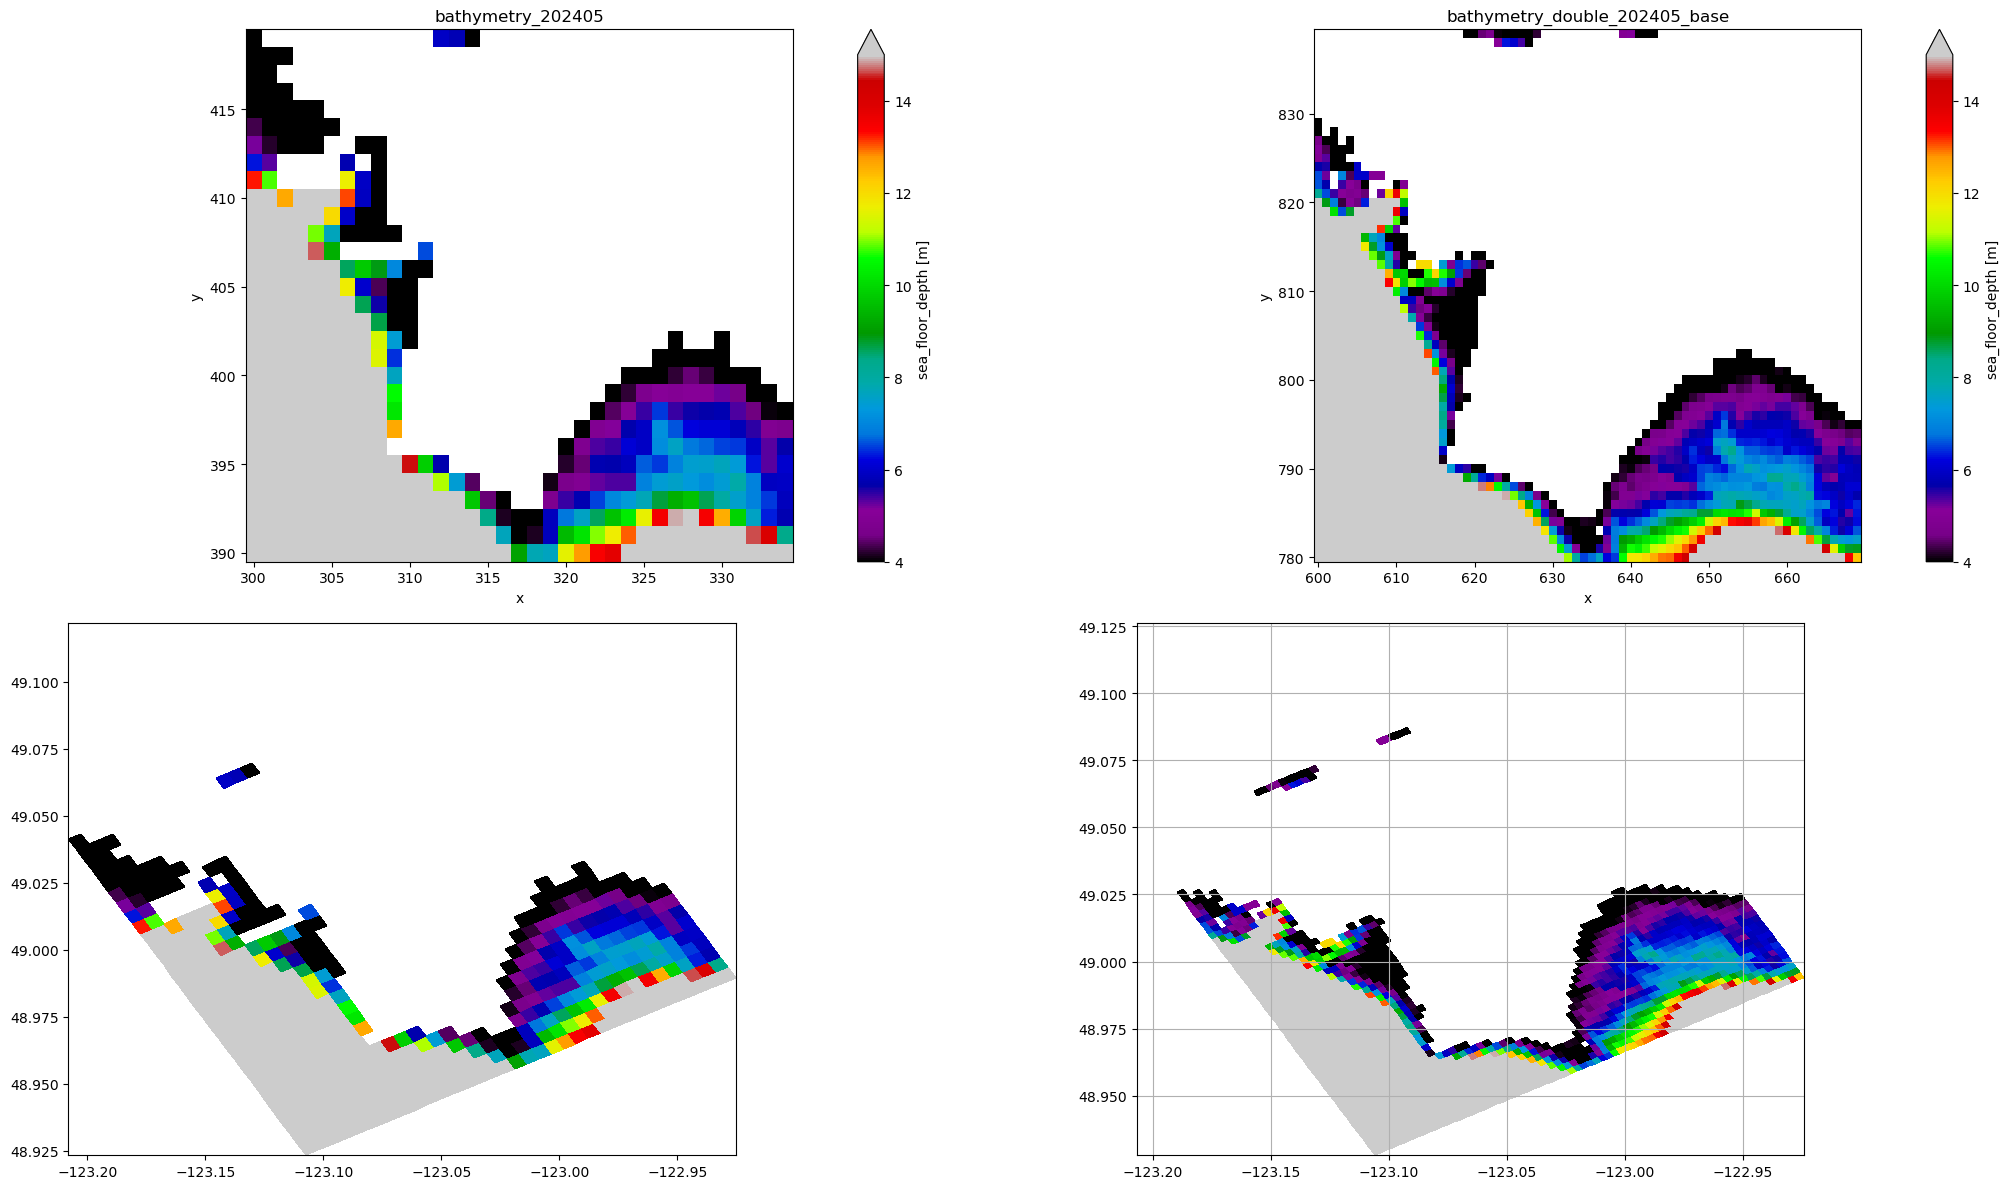

In [72]:
plot_tile(tile_x_min_max[10], y_slices, bathy, dbl_bathy_base)

### Tile 8, 11 - Mud Bay & Crescent Beach

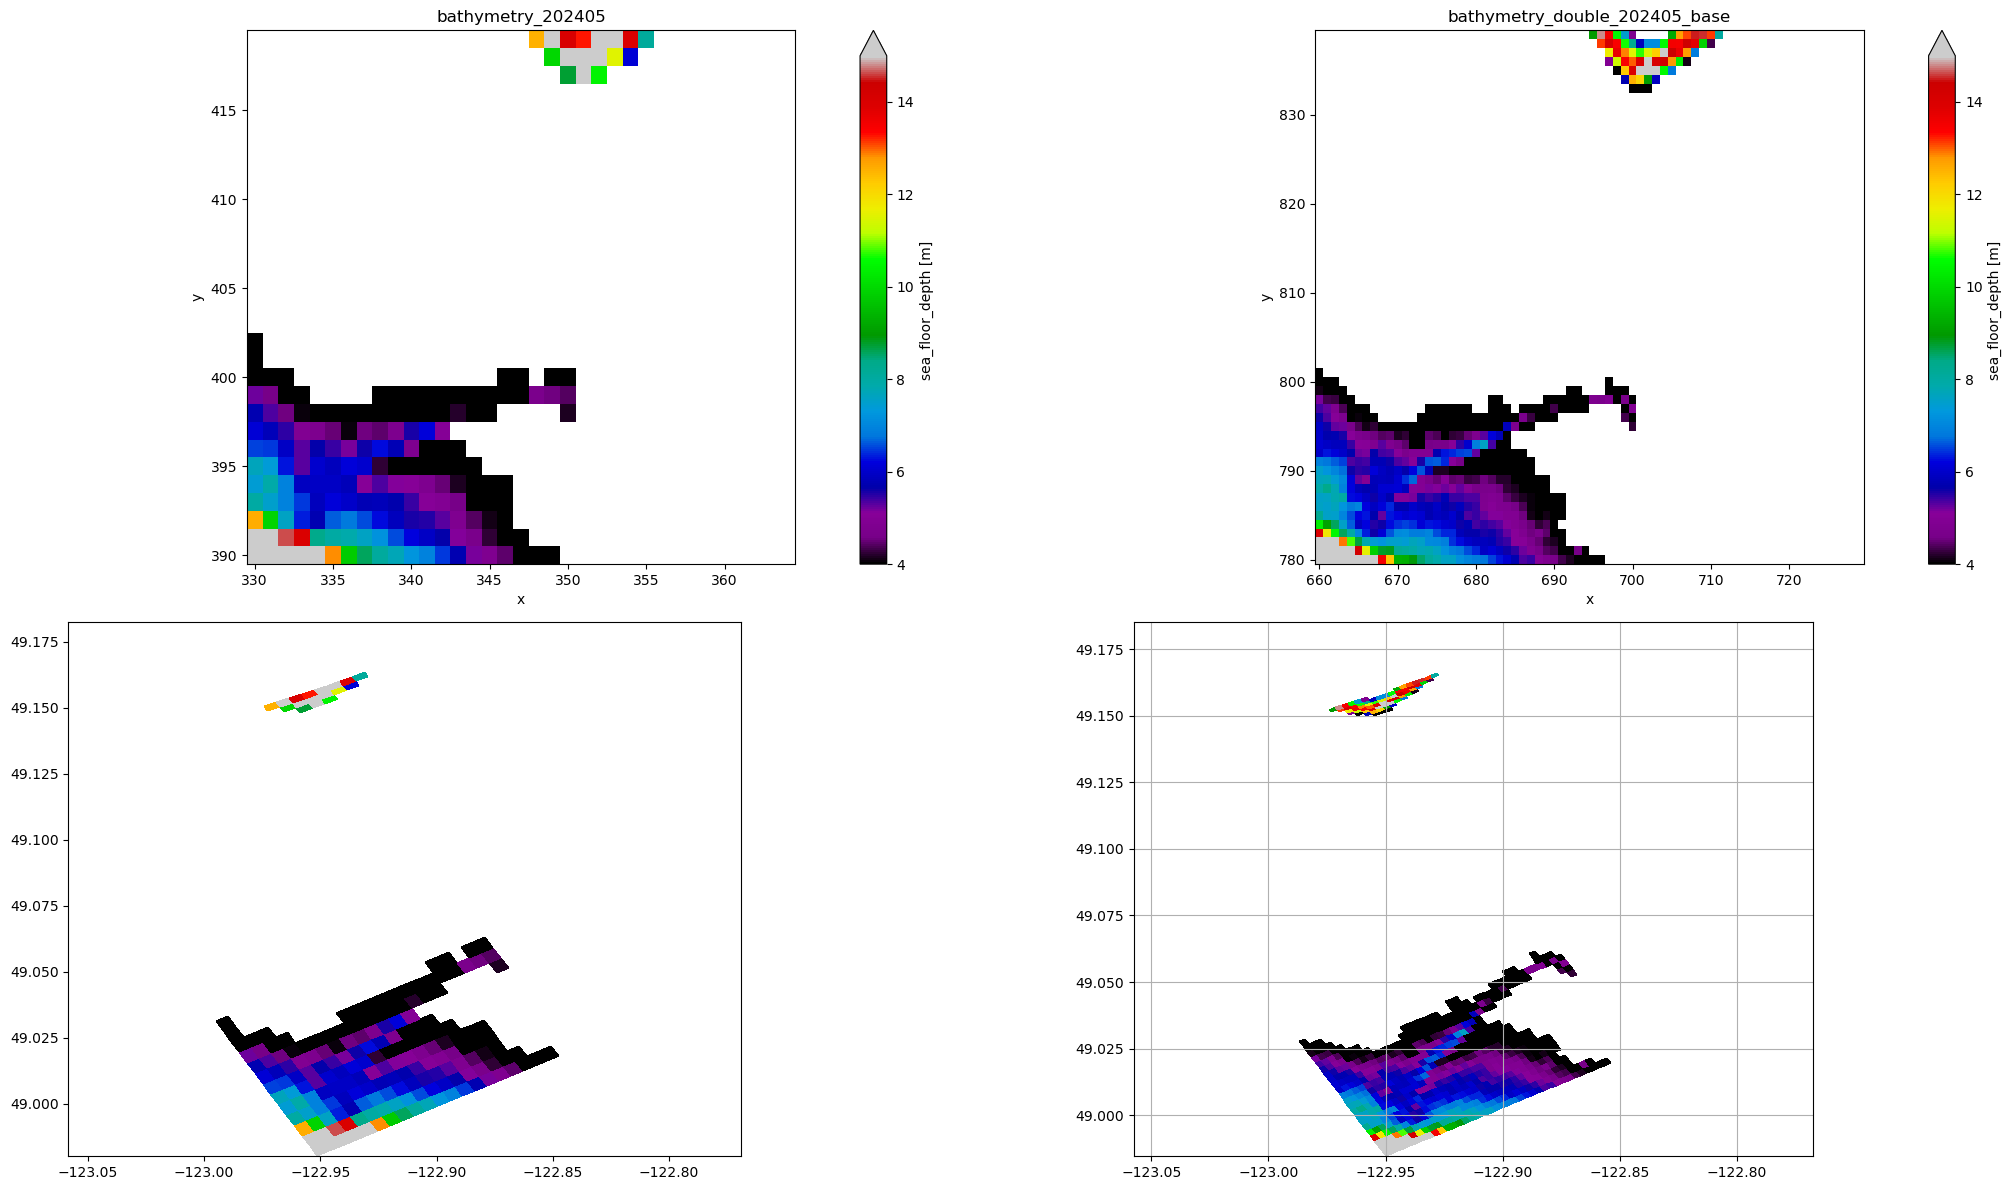

In [73]:
plot_tile(tile_x_min_max[11], y_slices, bathy, dbl_bathy_base)

### Tile 8, 12 - Surrey

* junction of Fraser River proxy and the real river

/tmp/ipykernel_1774949/3254661000.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_sgl_map.pcolormesh(tile_lons, tile_lats, bathy.isel(y=y_slices["sgl"], x=x_slices["sgl"]), cmap=cmap, vmax=15)
/tmp/ipykernel_1774949/3254661000.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_dbl_base_map.pcolormesh(tile_lons, tile_lats, dbl_bathy_base.isel(y=y_slices["dbl"], x=x_slices["dbl"]), cmap=cmap, vmax=15)


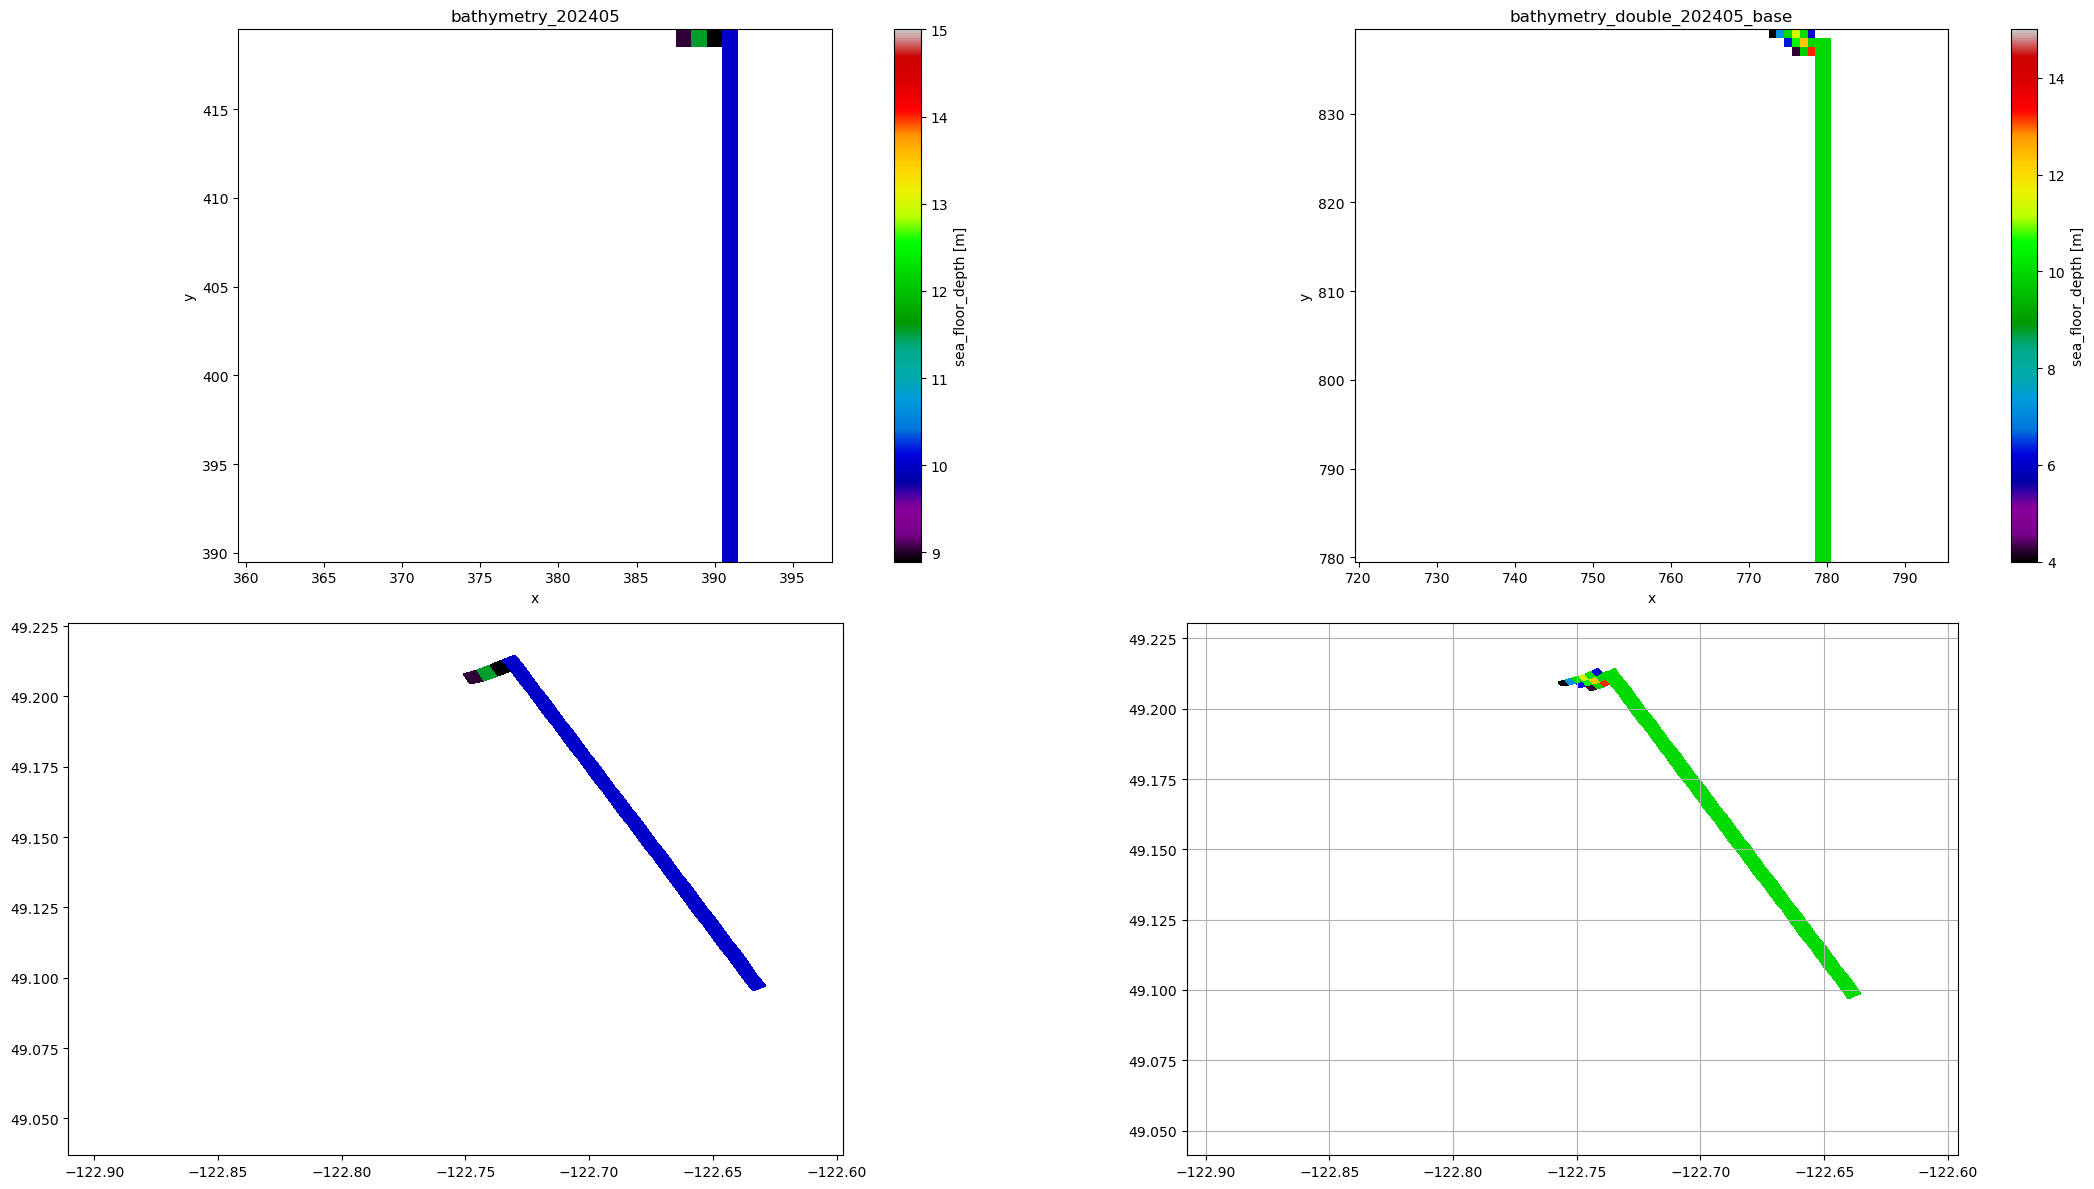

In [74]:
plot_tile(tile_x_min_max[12], y_slices, bathy, dbl_bathy_base)